<!--
If you are reading this, please recognize that this notebook is heavily catered to be PDF export friendly.
There will be large blocks of code in order to keep sections grouped together to minimize spacing, and a lot of markdown.
This will certainly not be a love letter to Jupyter Lab.
-->

In [1]:
import pandas as pd
import os
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
from collections import Counter

import nbconvert
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from IPython.display import Markdown, SVG, display, Image, HTML

# Download the stopwords below through nltk once.
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Defintion to churn out totals/percentages to avoid copy pasta.
def summarize_column(df, column_name):
    non_null_data = df[column_name].dropna()
    summary = non_null_data.value_counts()
    percentages = (non_null_data.value_counts(normalize=True) * 100).round(1)
    summary = pd.DataFrame({'Total': summary, 'Percentage': percentages})
    sample_size = non_null_data.shape[0]
    return summary, sample_size

<div style="text-align: center;">

<h1>Yarn Survey 2024</h1>

<h4>Presented by</h4>

<h2>Premier Needle Arts</h2>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    The 2024 Yarn Survey was put on by Knit Picks, Berroco, and Crochet.com <br> to get more contextual knowledge of knitters, crocheters, and general yarn enthusiasts.
</div>

In [2]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')

In [3]:
# To export the notebook, uncomment the lines below.
# %%capture
# !jupyter nbconvert --to webpdf Yarn_survey.ipynb --output All_PDF_Export --output-dir ./PDF --no-input

## Demographic Summary

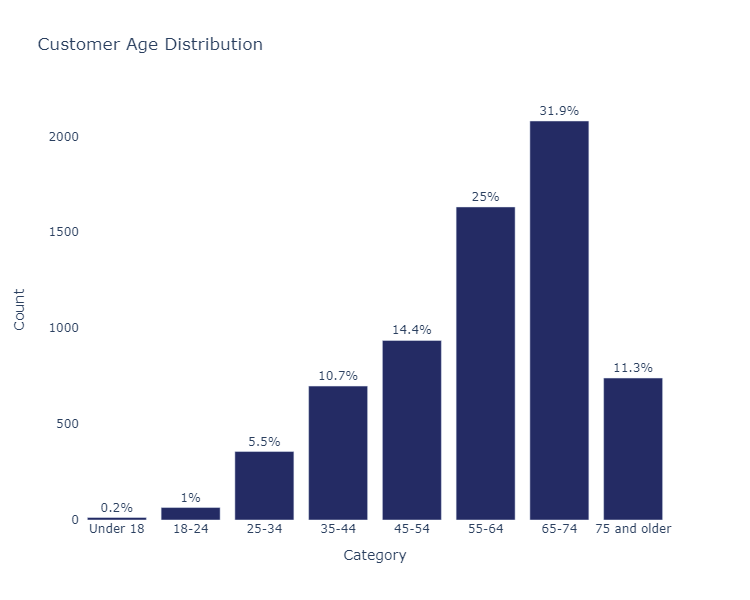

 - Out of **6521** respondants, the average respondant age is: **58** and the median age is: **59**.

- Of these respondants, they identify as:
    - "Woman" (98%)
    - "Non-Conforming / Non-Binary" (1%)
    - "Man" (1%)
    - "Transgender" (0%)


- The average household income is: **\$89,596** and the median household income is: **\$72,499** (From 4527 responses).
  - For ages **Under 18** the average household income is **\\$22,500**, the median household income is **\\$20,000** (From 3 responses.)
  - For ages **18-24** the average household income is **\\$61,250**, the median household income is **\\$42,500** (From 40 responses.)
  - For ages **25-34** the average household income is **\\$87,831**, the median household income is **\\$72,500** (From 287 responses.)
  - For ages **35-44** the average household income is **\\$102,103**, the median household income is **\\$90,000** (From 517 responses.)
  - For ages **45-54** the average household income is **\\$105,719**, the median household income is **\\$112,500** (From 594 responses.)
  - For ages **55-64** the average household income is **\\$97,537**, the median household income is **\\$90,000** (From 997 responses.)
  - For ages **65-74** the average household income is **\\$79,221**, the median household income is **\\$72,500** (From 1185 responses.)
  - For ages **75 and older** the average household income is **\\$74,103**, the median household income is **\\$57,500** (From 393 responses.)


In [4]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=750,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondants, the average respondant age is: **{average_age}** and the median age is: **{median_age}**."))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = "- Of these respondants, they identify as:\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

### Income Section ###

# Income Question
question = all_responses.columns[80]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()

# Define the function to map income ranges to their midpoints
def map_income_to_midpoint(value):
    if value == 'Under $20,000':
        return 20000
    elif value == '$20,000 - $34,999':
        return (20000 + 34999) / 2
    elif value == '$35,000 - $49,999':
        return (35000 + 49999) / 2
    elif value == '$50,000 - $64,999':
        return (50000 + 64999) / 2
    elif value == '$65,000 - $79,999':
        return (65000 + 79999) / 2
    elif value == '$80,000 - $99,999':
        return (80000 + 99999) / 2
    elif value == '$100,000 - $124,999':
        return (100000 + 124999) / 2
    elif value == '$125,000 - $149,999':
        return (125000 + 149999) / 2
    elif value == '$150,000 - $174,999':
        return (150000 + 174999) / 2
    elif value == '$175,000 - $199,999':
        return (175000 + 199999) / 2
    elif value == 'Over $200,000':
        return 200000
    else:
        return np.nan

# Apply the function to the column data
income_data = column_data.map(map_income_to_midpoint)
# Calculate the average income
average_income = income_data.mean().astype(int)
# Calculate the median income
median_income = income_data.median().astype(int)
# Total count of responses
total_responses = income_data.dropna().count()
# Format the average and median income for readability with $ and commas
formatted_average_income = "\${:,.0f}".format(average_income)
formatted_median_income = "\${:,.0f}".format(median_income)

## Break down by age group. ##

age_question = all_responses.columns[75]

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[age_question] != 'Prefer not to answer') & 
                                        (all_responses[question] != 'Prefer not to answer')]

# Apply categorization and mapping for income midpoint again if necessary
filtered_responses['income_midpoint'] = filtered_responses[question].map(map_income_to_midpoint)
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Now group by the 'age_range' with the specified order
statistics = filtered_responses.groupby('age_range', observed=True)['income_midpoint'].agg(['mean', 'median', 'count']).dropna()

# First part of the markdown about average and median income
markdown_part1 = f"- The average household income is: **{formatted_average_income}** and the median household income is: **{formatted_median_income}** (From {total_responses} responses)."

# Generating the second part with the breakdown by age group
markdown_part2 = ""
for age, row in statistics.iterrows():
    avg_income = "\${:,.0f}".format(row['mean'])
    median_income = "\${:,.0f}".format(row['median'])
    responses = row['count'].astype(int)
    markdown_part2 += f"  - For ages **{age}** the average household income is **\{avg_income}**, the median household income is **\{median_income}** (From {responses} responses.)\n"

# Combine the two parts into a single Markdown display, with the second part indented as a sub-list
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

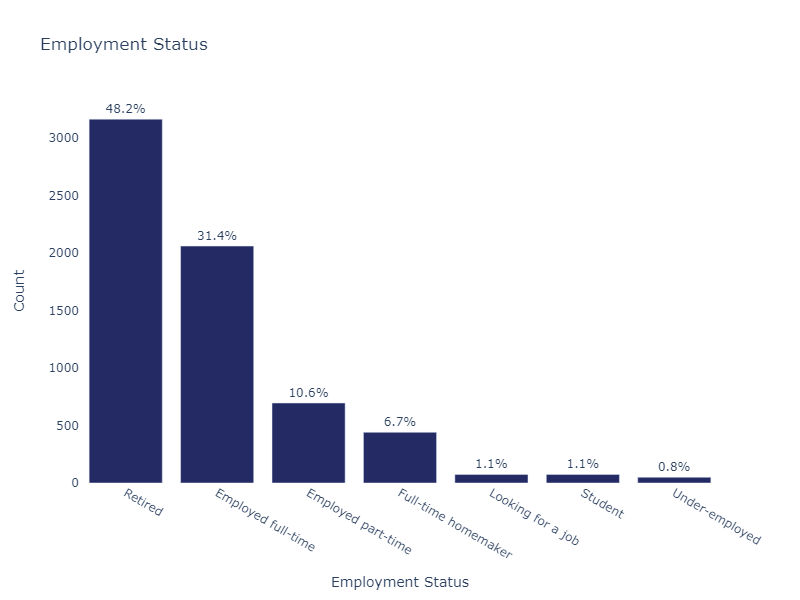

- Of the respondents, their employment statuses are as follows:  (From 6563 responses)
    - "Retired" (48%)
    - "Employed full-time" (31%)
    - "Employed part-time" (11%)
    - "Full-time homemaker" (7%)
    - "Looking for a job" (1%)
    - "Student" (1%)
    - "Under-employed" (1%)


In [5]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

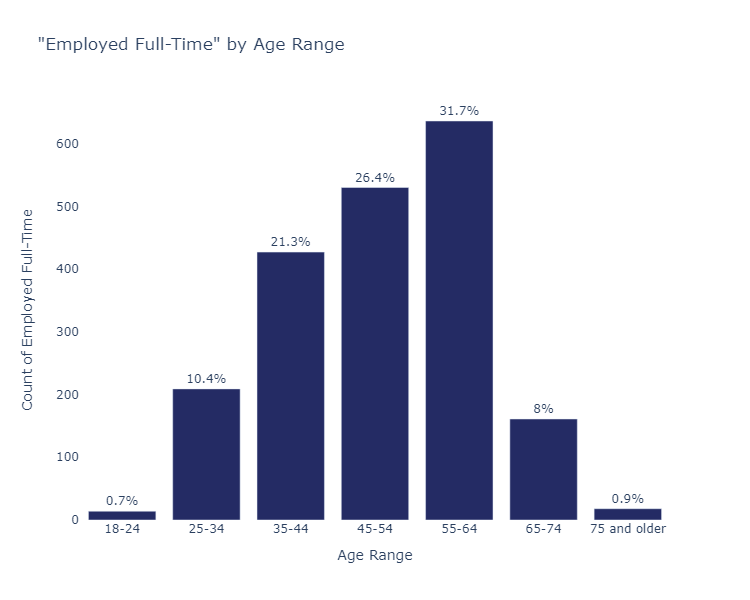

- Of those who responded 'Employed Full-Time': (From 2061 responses.)
    - "55-64" (31.7%)
    - "45-54" (26.4%)
    - "35-44" (21.3%)
    - "25-34" (10.4%)
    - "65-74" (8.0%)
    - "75 and older" (0.9%)
    - "18-24" (0.7%)


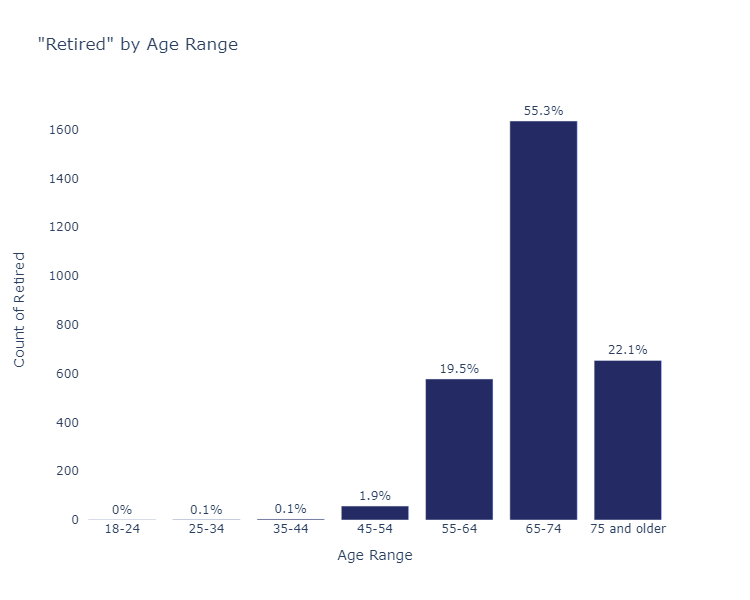

- Of those who responded 'Retired': (From 3165 responses.)
    - "65-74" (55.3%)
    - "75 and older" (22.1%)
    - "55-64" (19.5%)
    - "45-54" (1.9%)
    - "25-34" (0.1%)
    - "35-44" (0.1%)
    - "18-24" (0.0%)


In [6]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))


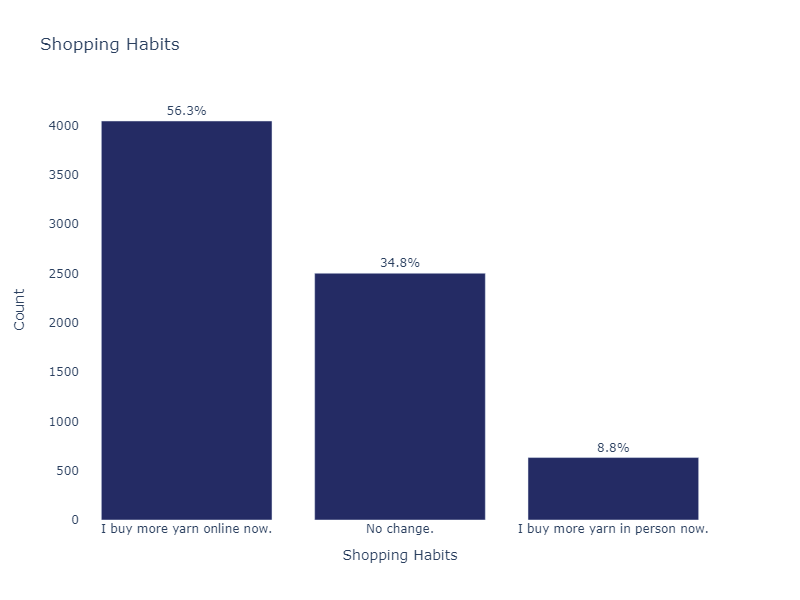

- Of the respondents, they reported that their shopping habbits have changed:  (From 7178 responses)
    - "I buy more yarn online now." (56%)
    - "No change." (35%)
    - "I buy more yarn in person now." (9%)


In [7]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

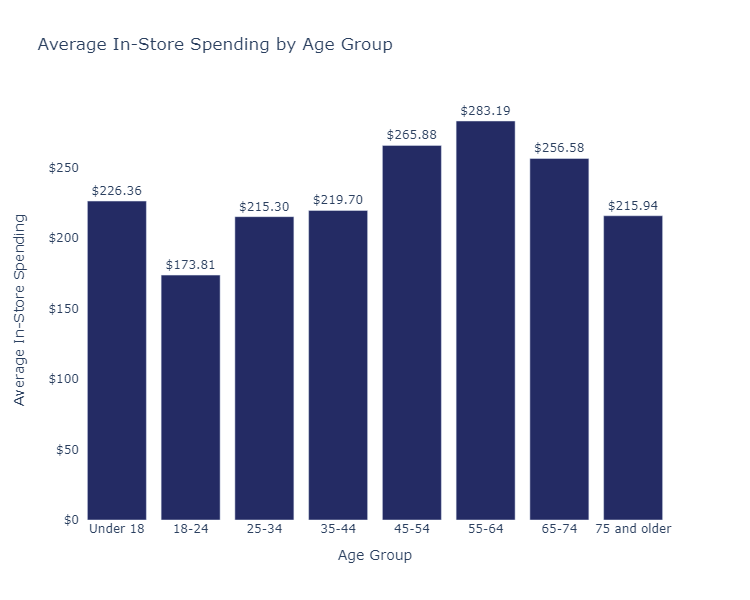

- Respondents reported making **4.7** purchases in-store per year on average, spending an average **\$53.28** per visit. On average spending **\$250.41** a year. (From 6673 responses.)
     - For the group 'Under 18', respondents reported making **6.0** purchases in-store per year on average, spending an average **\$37.73** per visit. On average spending **\$226.36** a year.
     - For the group '18-24', respondents reported making **4.9** purchases in-store per year on average, spending an average **\$35.46** per visit. On average spending **\$173.81** a year.
     - For the group '25-34', respondents reported making **4.6** purchases in-store per year on average, spending an average **\$46.88** per visit. On average spending **\$215.30** a year.
     - For the group '35-44', respondents reported making **4.4** purchases in-store per year on average, spending an average **\$50.26** per visit. On average spending **\$219.70** a year.
     - For the group '45-54', respondents reported making **5.1** purchases in-store per year on average, spending an average **\$52.54** per visit. On average spending **\$265.88** a year.
     - For the group '55-64', respondents reported making **5.0** purchases in-store per year on average, spending an average **\$57.01** per visit. On average spending **\$283.19** a year.
     - For the group '65-74', respondents reported making **4.7** purchases in-store per year on average, spending an average **\$54.74** per visit. On average spending **\$256.58** a year.
     - For the group '75 and older', respondents reported making **4.3** purchases in-store per year on average, spending an average **\$50.13** per visit. On average spending **\$215.94** a year.

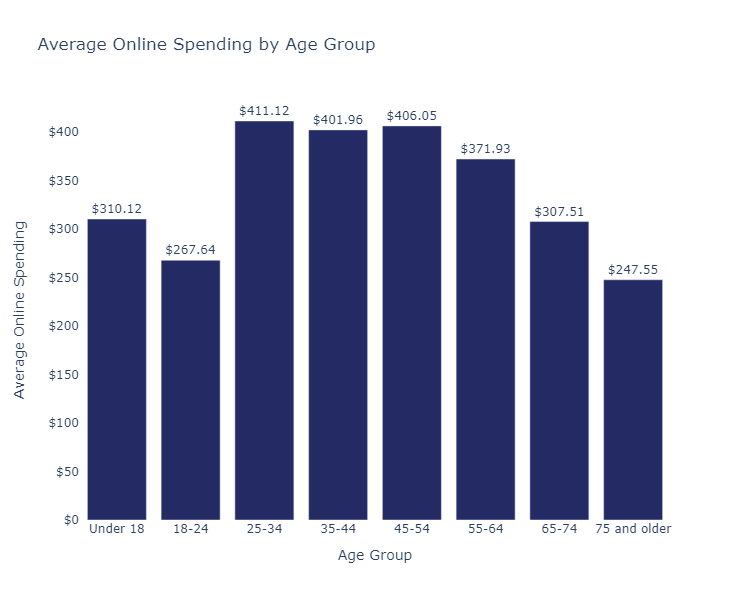

- Respondents reported making **5.0** purchases online per year on average, spending an average **\$67.33** per visit. On average spending **\$338.77** a year. (From 6799 responses.)
     - For the group 'Under 18', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$57.82** per visit. On average spending **\$310.12** a year.
     - For the group '18-24', respondents reported making **5.0** purchases in-store per year on average, spending an average **\$53.70** per visit. On average spending **\$267.64** a year.
     - For the group '25-34', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$76.23** per visit. On average spending **\$411.12** a year.
     - For the group '35-44', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$74.90** per visit. On average spending **\$401.96** a year.
     - For the group '45-54', respondents reported making **5.5** purchases in-store per year on average, spending an average **\$73.95** per visit. On average spending **\$406.05** a year.
     - For the group '55-64', respondents reported making **5.3** purchases in-store per year on average, spending an average **\$70.55** per visit. On average spending **\$371.93** a year.
     - For the group '65-74', respondents reported making **4.8** purchases in-store per year on average, spending an average **\$63.54** per visit. On average spending **\$307.51** a year.
     - For the group '75 and older', respondents reported making **4.3** purchases in-store per year on average, spending an average **\$57.42** per visit. On average spending **\$247.55** a year.

In [8]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_online:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

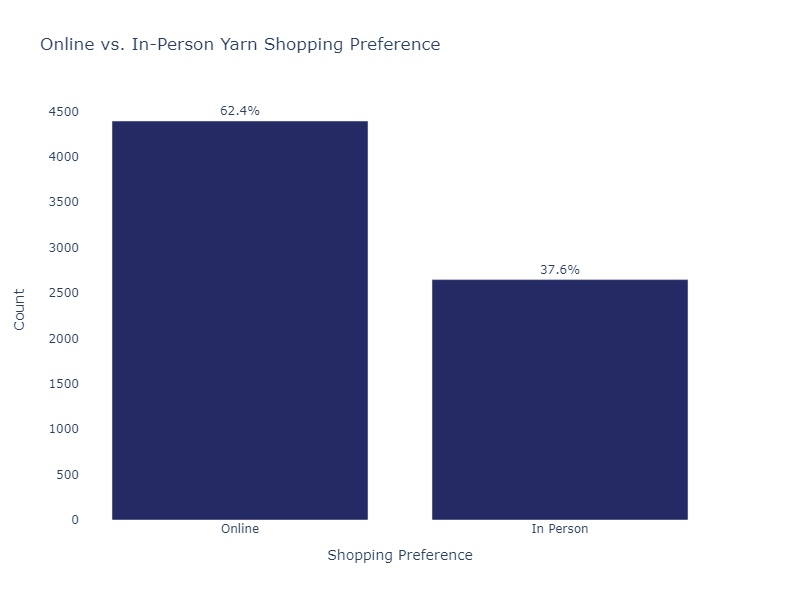

- Of the respondants **58.2%** preferred online shopping for yarn, while **35.04%** preferred shopping in person for yarn. (From 7043 responses.)
     - For the group 'Under 18', **30.8%** preferred shopping online, **69.2%** preferred shopping in person.
     - For the group '18-24', **67.7%** preferred shopping online, **32.3%** preferred shopping in person.
     - For the group '25-34', **72.5%** preferred shopping online, **26.1%** preferred shopping in person.
     - For the group '35-44', **71.5%** preferred shopping online, **27.2%** preferred shopping in person.
     - For the group '45-54', **65.5%** preferred shopping online, **31.3%** preferred shopping in person.
     - For the group '55-64', **60.1%** preferred shopping online, **37.4%** preferred shopping in person.
     - For the group '65-74', **57.9%** preferred shopping online, **39.8%** preferred shopping in person.
     - For the group '75 and older', **53.1%** preferred shopping online, **43.8%** preferred shopping in person.

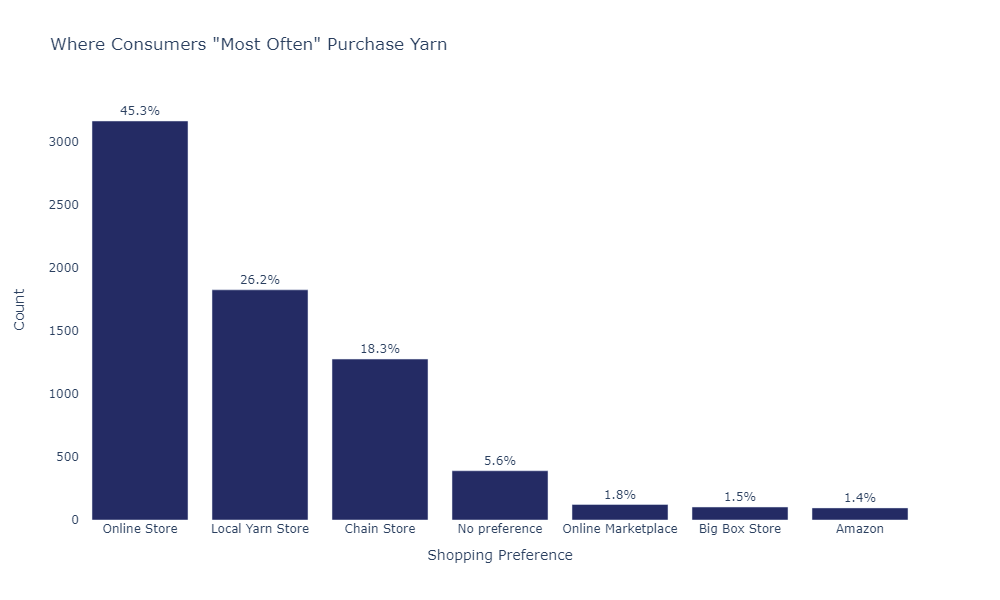

In [9]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

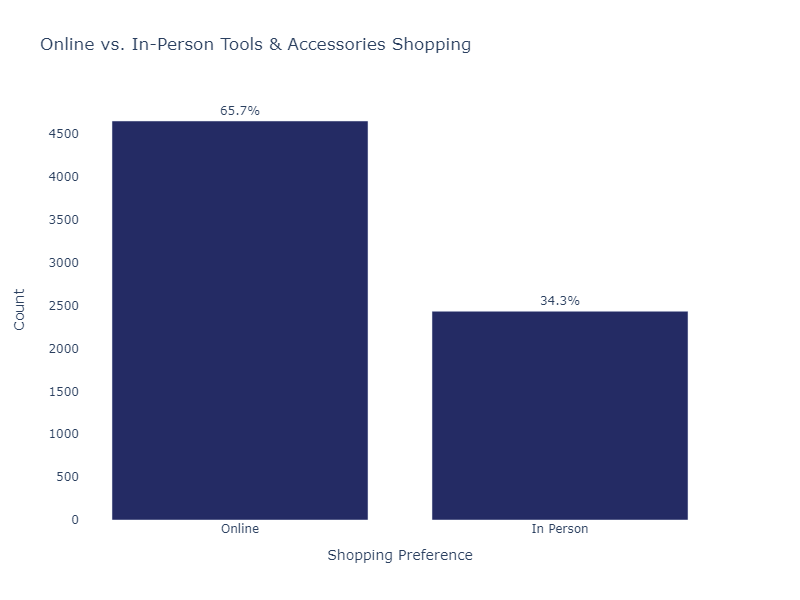

- Of the respondants **61.6%** preferred online shopping for tools & accessories, while **32.22%** preferred shopping in person for tools & accessories. (From 7090 responses.)
     - For the group 'Under 18', **53.8%** preferred shopping online, **46.2%** preferred shopping in person.
     - For the group '18-24', **69.2%** preferred shopping online, **30.8%** preferred shopping in person.
     - For the group '25-34', **73.1%** preferred shopping online, **25.8%** preferred shopping in person.
     - For the group '35-44', **77.8%** preferred shopping online, **21.1%** preferred shopping in person.
     - For the group '45-54', **71.2%** preferred shopping online, **26.7%** preferred shopping in person.
     - For the group '55-64', **64.1%** preferred shopping online, **34.2%** preferred shopping in person.
     - For the group '65-74', **61.2%** preferred shopping online, **37.1%** preferred shopping in person.
     - For the group '75 and older', **54.3%** preferred shopping online, **43.2%** preferred shopping in person.

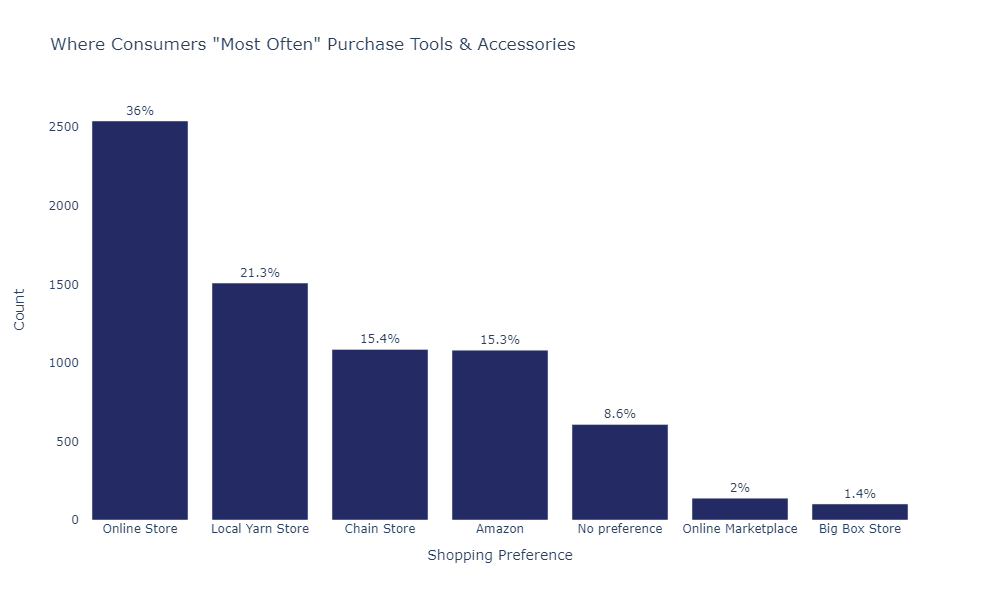

In [10]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

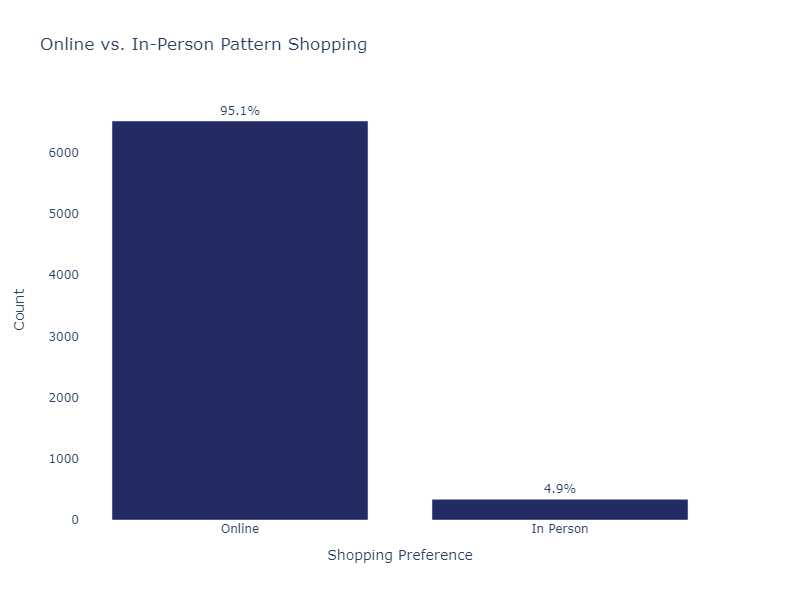

- Of the respondants **86.2%** preferred online shopping for patterns, while **4.47%** preferred shopping in person for patterns. (From 6856 responses.)
     - For the group 'Under 18', **69.2%** preferred shopping online, **7.7%** preferred shopping in person.
     - For the group '18-24', **95.4%** preferred shopping online, **0.0%** preferred shopping in person.
     - For the group '25-34', **95.0%** preferred shopping online, **1.1%** preferred shopping in person.
     - For the group '35-44', **95.8%** preferred shopping online, **2.1%** preferred shopping in person.
     - For the group '45-54', **94.9%** preferred shopping online, **1.7%** preferred shopping in person.
     - For the group '55-64', **92.4%** preferred shopping online, **2.9%** preferred shopping in person.
     - For the group '65-74', **88.5%** preferred shopping online, **5.9%** preferred shopping in person.
     - For the group '75 and older', **82.7%** preferred shopping online, **10.4%** preferred shopping in person.

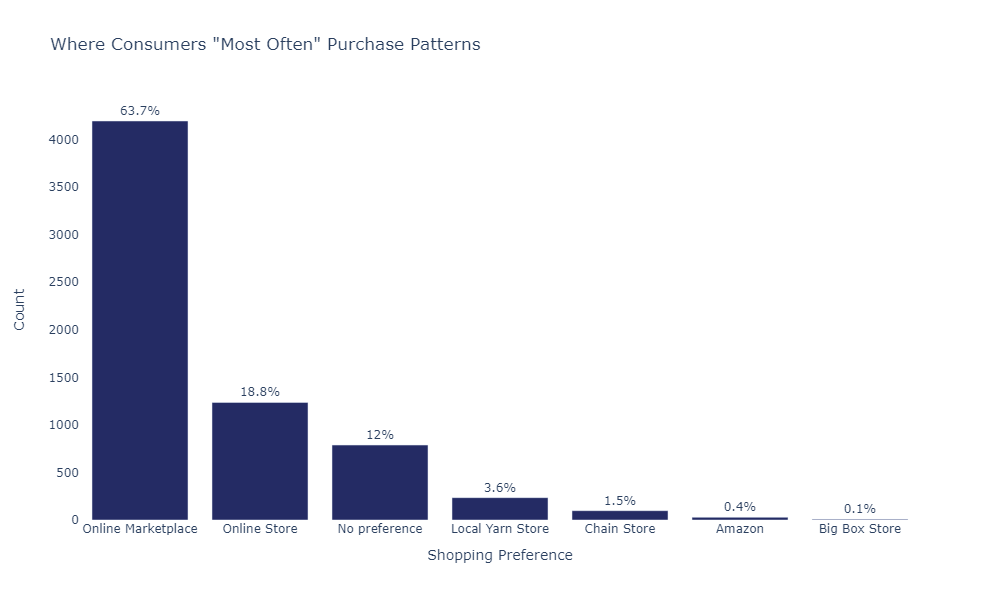

In [11]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

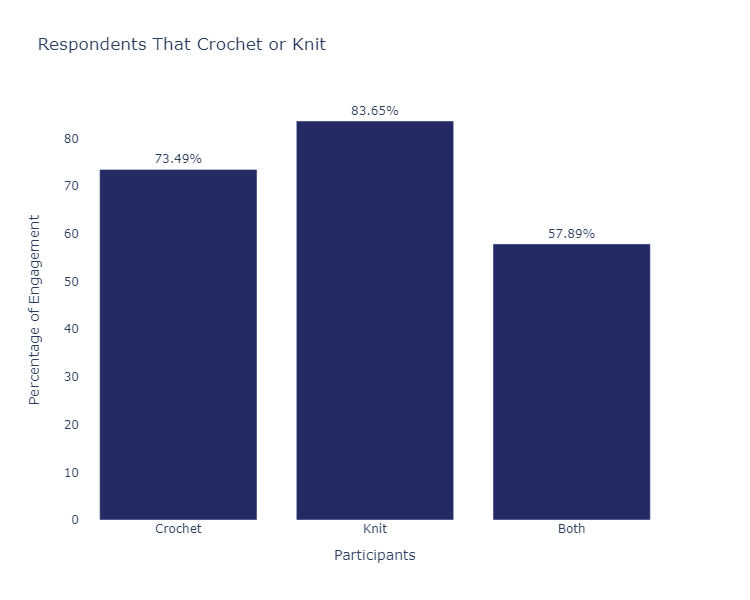

- Of the respondants, **73.5%** responded 'Yes' to crocheting, **83.65%** responded 'Yes' to knitting, while **57.89%** of respondants engage in both. (From 7558 responses.)
     - For the group 'Under 18', **100.0%** responded 'Yes' to crocheting, **61.5%** responded 'Yes' to knitting, and **61.5%** to both.
     - For the group '18-24', **90.8%** responded 'Yes' to crocheting, **67.7%** responded 'Yes' to knitting, and **58.5%** to both.
     - For the group '25-34', **82.6%** responded 'Yes' to crocheting, **73.4%** responded 'Yes' to knitting, and **56.3%** to both.
     - For the group '35-44', **79.1%** responded 'Yes' to crocheting, **78.9%** responded 'Yes' to knitting, and **58.0%** to both.
     - For the group '45-54', **78.5%** responded 'Yes' to crocheting, **78.6%** responded 'Yes' to knitting, and **57.2%** to both.
     - For the group '55-64', **77.5%** responded 'Yes' to crocheting, **81.6%** responded 'Yes' to knitting, and **59.0%** to both.
     - For the group '65-74', **69.7%** responded 'Yes' to crocheting, **89.9%** responded 'Yes' to knitting, and **59.7%** to both.
     - For the group '75 and older', **62.3%** responded 'Yes' to crocheting, **94.2%** responded 'Yes' to knitting, and **56.6%** to both.

In [12]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondants, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondants engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.1f}%** responded 'Yes' to knitting, and **{both_yes_percent:.1f}%** to both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

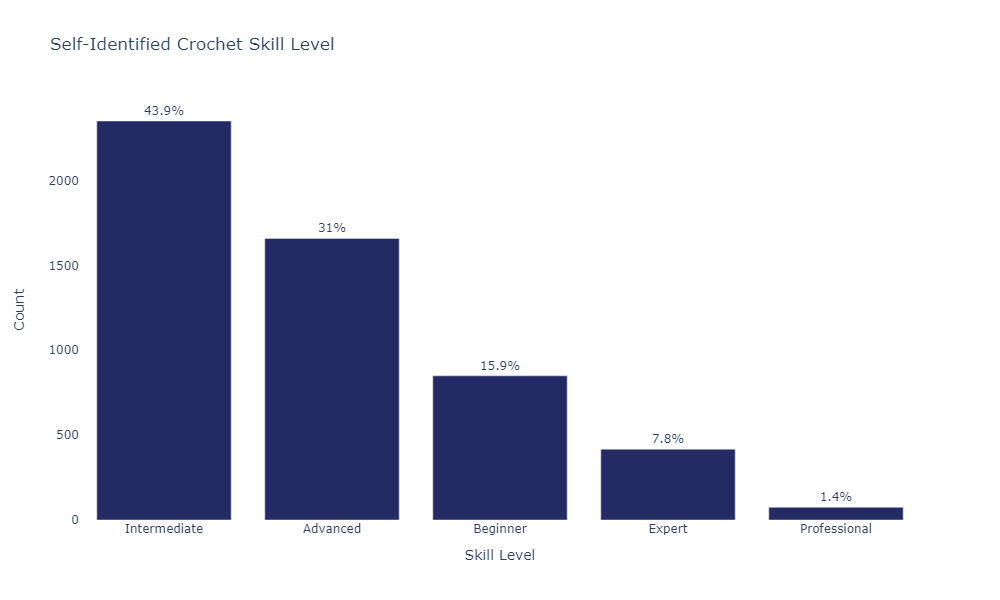

- Of the respondants who crochet, they rate their skill level as the following: (From 5554 responses.)
    - **43.93%** of respondents answered 'Intermediate'.
    - **31.00%** of respondents answered 'Advanced'.
    - **15.87%** of respondents answered 'Beginner'.
    - **7.80%** of respondents answered 'Expert'.
    - **1.40%** of respondents answered 'Professional'.


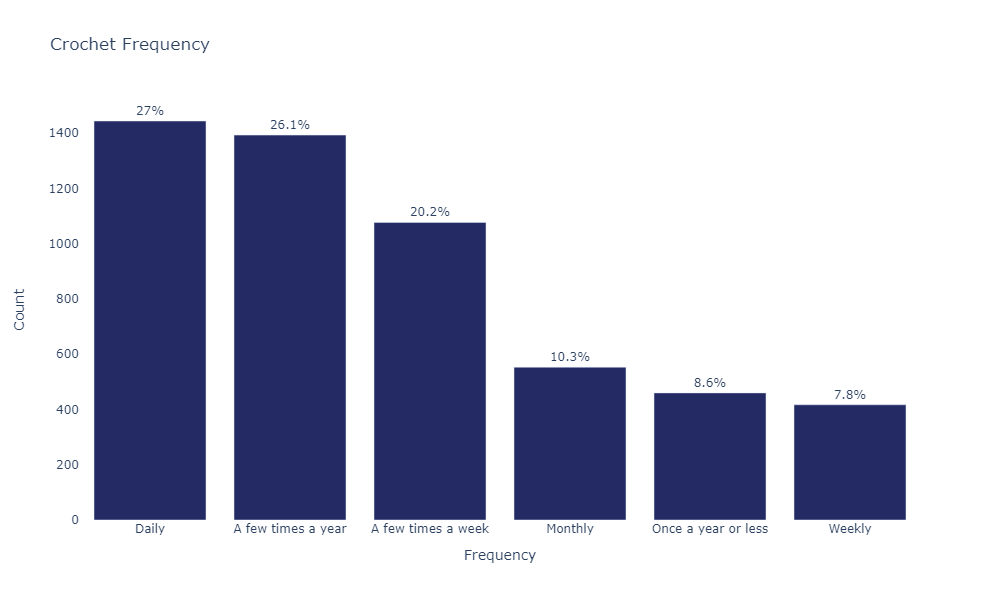

- Of the respondants who crochet, the frequency they do so is: (From 5554 responses.)
    - **27.02%** of respondents answered 'Daily'.
    - **26.07%** of respondents answered 'A few times a year'.
    - **20.15%** of respondents answered 'A few times a week'.
    - **10.35%** of respondents answered 'Monthly'.
    - **8.61%** of respondents answered 'Once a year or less'.
    - **7.80%** of respondents answered 'Weekly'.


In [13]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



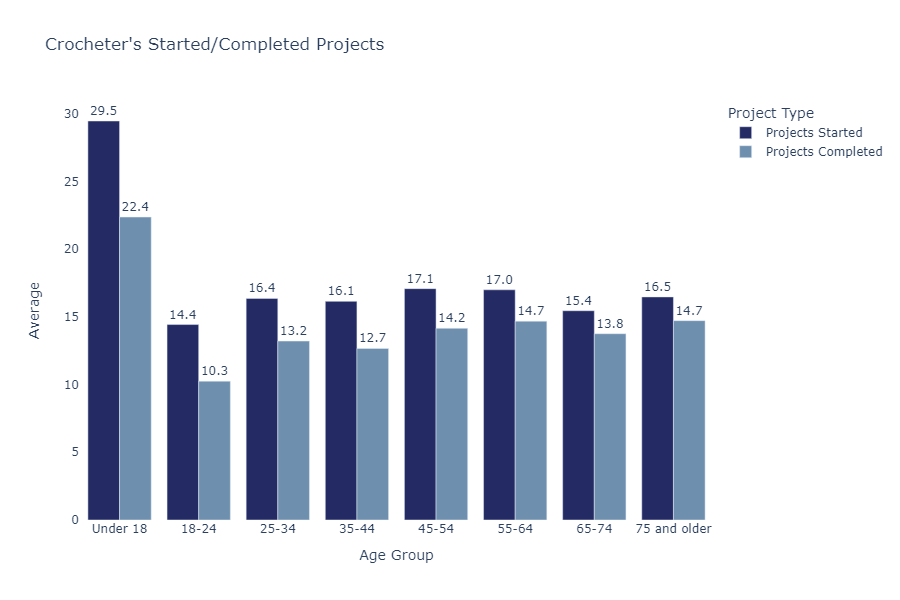

- Of the respondants, on average they start **16.4** crochet projects a year, and on average they complete **14.0** crochet projects a year. (From 5554 responses.)
     - For the group 'Under 18', they start **29.5** crochet projects a year, and on average they complete **22.4** crochet projects a year.
     - For the group '18-24', they start **14.4** crochet projects a year, and on average they complete **10.2** crochet projects a year.
     - For the group '25-34', they start **16.4** crochet projects a year, and on average they complete **13.2** crochet projects a year.
     - For the group '35-44', they start **16.1** crochet projects a year, and on average they complete **12.7** crochet projects a year.
     - For the group '45-54', they start **17.1** crochet projects a year, and on average they complete **14.2** crochet projects a year.
     - For the group '55-64', they start **17.0** crochet projects a year, and on average they complete **14.7** crochet projects a year.
     - For the group '65-74', they start **15.4** crochet projects a year, and on average they complete **13.8** crochet projects a year.
     - For the group '75 and older', they start **16.5** crochet projects a year, and on average they complete **14.7** crochet projects a year.

In [14]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondants, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

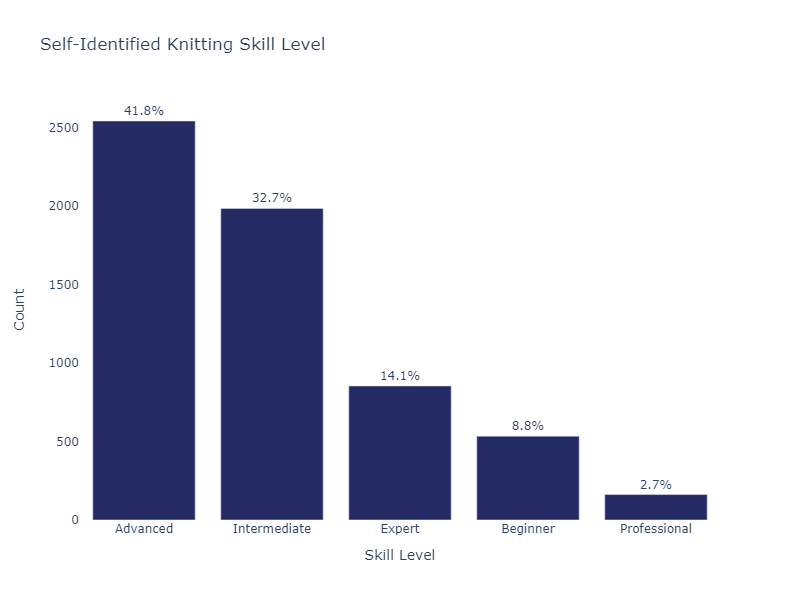

- Of the respondants who knit, they rate their skill level as the following: (From 6322 responses.)
    - **41.83%** of respondents answered 'Advanced'.
    - **32.66%** of respondents answered 'Intermediate'.
    - **14.05%** of respondents answered 'Expert'.
    - **8.79%** of respondents answered 'Beginner'.
    - **2.67%** of respondents answered 'Professional'.


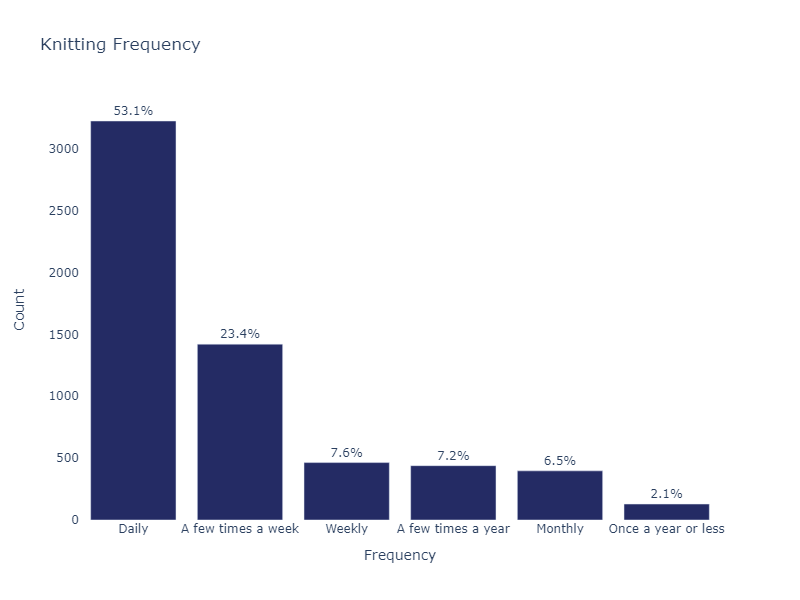

- Of the respondants who knit, the frequency they do so is: (From 6322 responses.)
    - **53.08%** of respondents answered 'Daily'.
    - **23.39%** of respondents answered 'A few times a week'.
    - **7.64%** of respondents answered 'Weekly'.
    - **7.23%** of respondents answered 'A few times a year'.
    - **6.54%** of respondents answered 'Monthly'.
    - **2.12%** of respondents answered 'Once a year or less'.


In [15]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



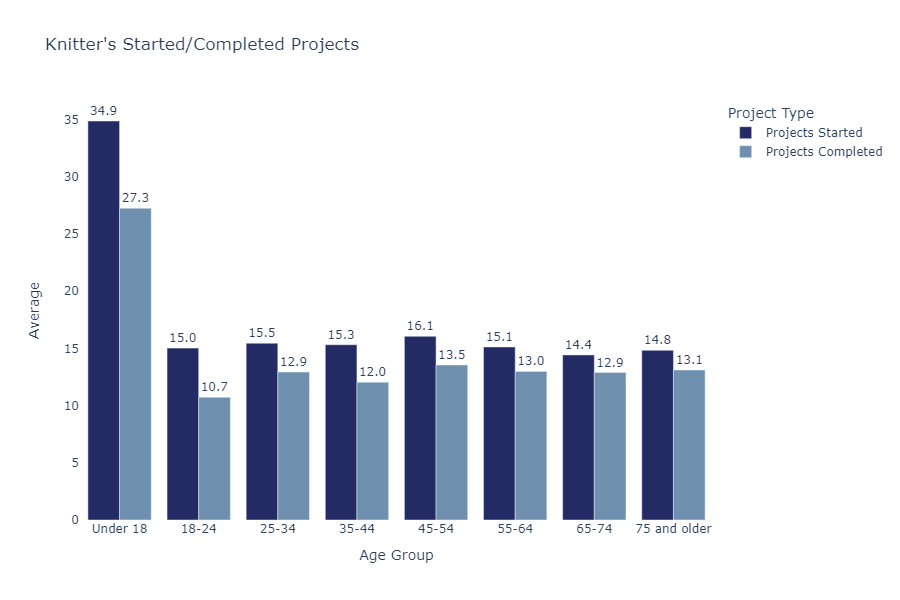

- Of the respondants, on average they start **15.0** knitting projects a year, and on average they complete **12.9** knitting projects a year. (From 6322 responses.)
     - For the group 'Under 18', they start **34.9** knitting projects a year, and on average they complete **27.2** knitting projects a year.
     - For the group '18-24', they start **15.0** knitting projects a year, and on average they complete **10.7** knitting projects a year.
     - For the group '25-34', they start **15.5** knitting projects a year, and on average they complete **12.9** knitting projects a year.
     - For the group '35-44', they start **15.3** knitting projects a year, and on average they complete **12.0** knitting projects a year.
     - For the group '45-54', they start **16.1** knitting projects a year, and on average they complete **13.5** knitting projects a year.
     - For the group '55-64', they start **15.1** knitting projects a year, and on average they complete **13.0** knitting projects a year.
     - For the group '65-74', they start **14.4** knitting projects a year, and on average they complete **12.9** knitting projects a year.
     - For the group '75 and older', they start **14.8** knitting projects a year, and on average they complete **13.1** knitting projects a year.

In [16]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondants, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

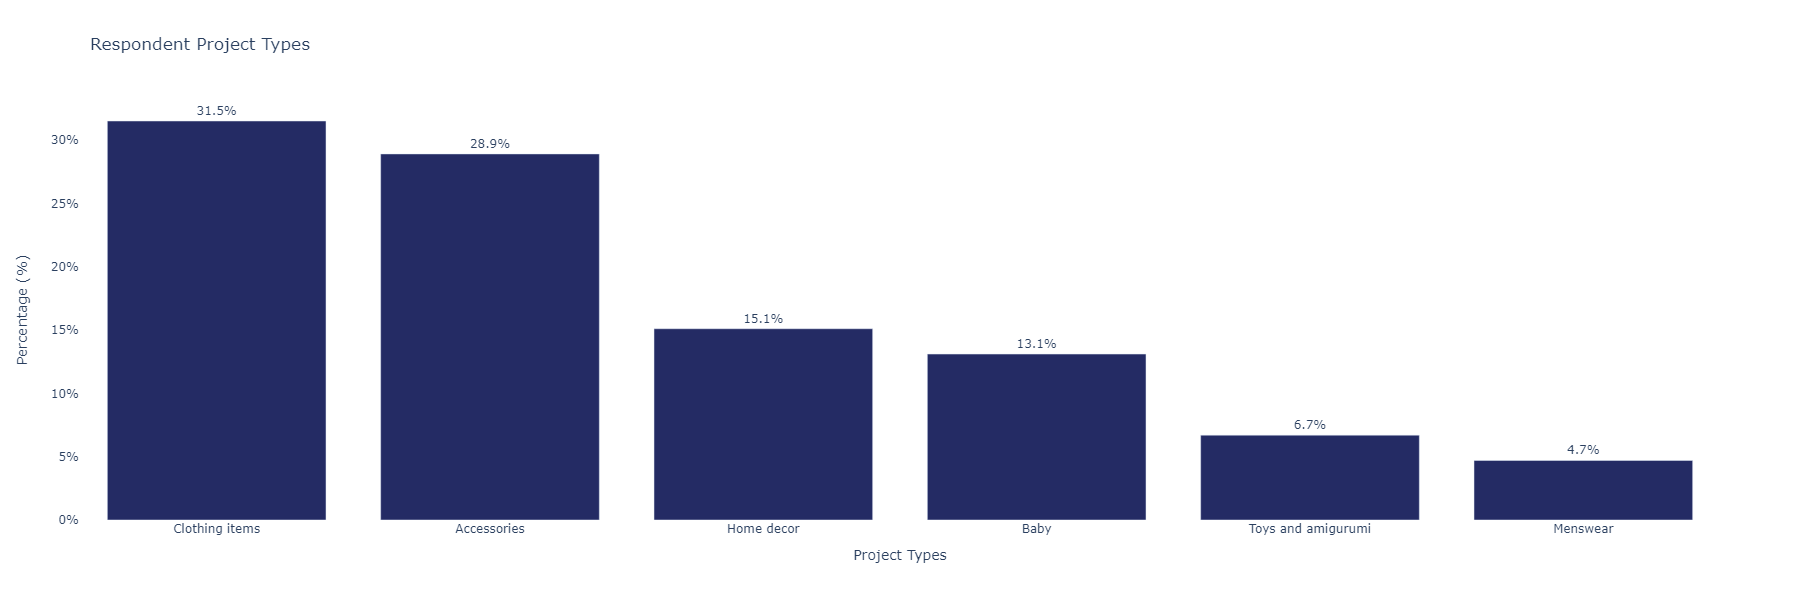

- Of the respondents, the most popular project type for all yarn crafts is: (From 6322 responses.)
     - For the group 'Under 18', the most popular project type is **Clothing items** at **44.0%**, **Accessories** at **28.0%**, **Toys and amigurumi** at **16.0%**, and finally **Home decor** at **12.0%**.
     - For the group '18-24', the most popular project type is **Clothing items** at **37.4%**, **Accessories** at **20.9%**, **Toys and amigurumi** at **15.1%**, and finally **Home decor** at **13.7%**.
     - For the group '25-34', the most popular project type is **Clothing items** at **32.9%**, **Accessories** at **25.7%**, **Home decor** at **16.1%**, and finally **Toys and amigurumi** at **11.2%**.
     - For the group '35-44', the most popular project type is **Clothing items** at **30.4%**, **Accessories** at **27.9%**, **Home decor** at **16.5%**, and finally **Baby** at **10.2%**.
     - For the group '45-54', the most popular project type is **Clothing items** at **31.3%**, **Accessories** at **28.4%**, **Home decor** at **16.9%**, and finally **Baby** at **9.9%**.
     - For the group '55-64', the most popular project type is **Clothing items** at **30.7%**, **Accessories** at **29.1%**, **Home decor** at **16.4%**, and finally **Baby** at **13.2%**.
     - For the group '65-74', the most popular project type is **Clothing items** at **32.0%**, **Accessories** at **29.5%**, **Baby** at **15.1%**, and finally **Home decor** at **13.9%**.
     - For the group '75 and older', the most popular project type is **Clothing items** at **31.5%**, **Accessories** at **30.0%**, **Baby** at **17.0%**, and finally **Home decor** at **11.8%**.

In [17]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check if there are at least two project types to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular project types
            markdown_summary += f"\n     - For the group '{age}', the most popular project type is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**, **{percentages.iloc[2, 0]}** at **{percentages.iloc[2, 1]}%**, and finally **{percentages.iloc[3, 0]}** at **{percentages.iloc[3, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular project type is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

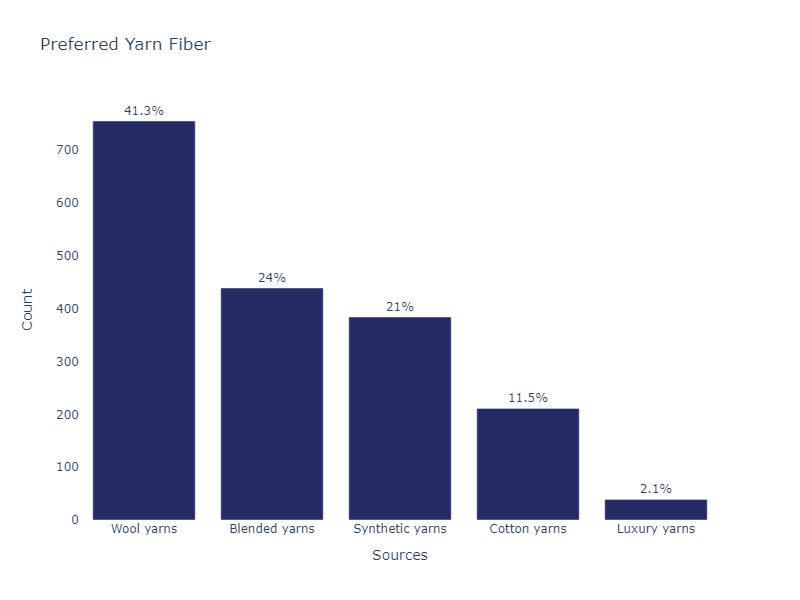

- Of the respondants, their preffered yarn fiber is: (From 1828 responses.)
     - For the group 'Under 18', the most popular yarn fiber is **Wool yarns** at **50.0%**, followed by **Cotton yarns** at **50.0%**.
     - For the group '18-24', the most popular yarn fiber is **Synthetic yarns** at **50.0%**, followed by **Wool yarns** at **22.2%**.
     - For the group '25-34', the most popular yarn fiber is **Wool yarns** at **39.8%**, followed by **Synthetic yarns** at **24.1%**.
     - For the group '35-44', the most popular yarn fiber is **Wool yarns** at **50.9%**, followed by **Blended yarns** at **18.6%**.
     - For the group '45-54', the most popular yarn fiber is **Wool yarns** at **41.5%**, followed by **Blended yarns** at **25.6%**.
     - For the group '55-64', the most popular yarn fiber is **Wool yarns** at **41.8%**, followed by **Blended yarns** at **22.4%**.
     - For the group '65-74', the most popular yarn fiber is **Wool yarns** at **40.4%**, followed by **Blended yarns** at **28.0%**.
     - For the group '75 and older', the most popular yarn fiber is **Wool yarns** at **40.4%**, followed by **Synthetic yarns** at **26.5%**.

In [18]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, their preffered yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular yarn fiber is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular yarn fiber is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

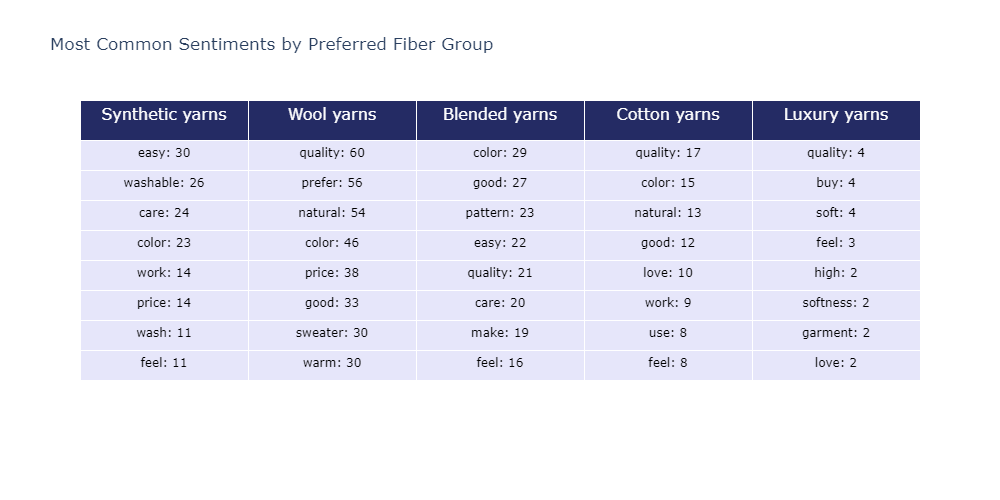

In [19]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Use lemmatization instead of stemming
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Most Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))


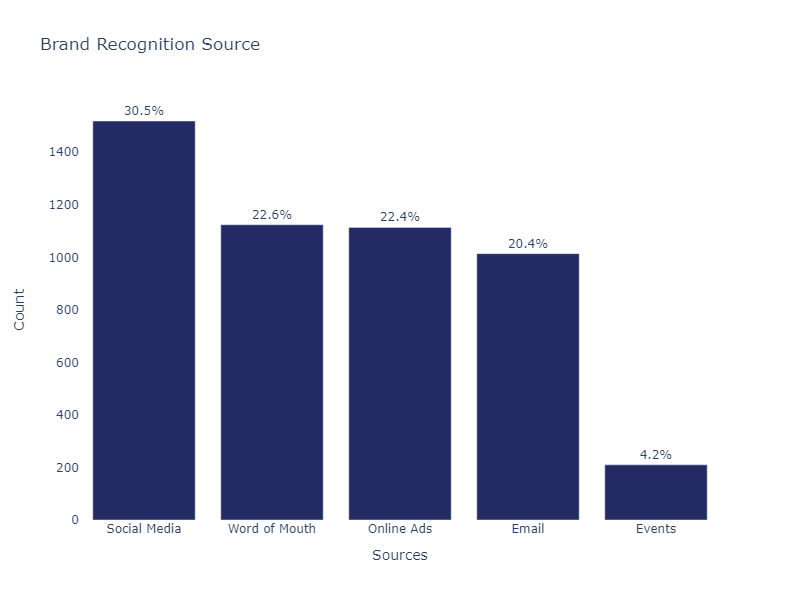

- Of the respondants, the most popular brand discovery source is: (From 7140 responses.)
     - For the group 'Under 18', the most popular discovery source is **Social Media** at **50.0%**, followed by **Word of Mouth** at **30.0%**.
     - For the group '18-24', the most popular discovery source is **Social Media** at **31.6%**, followed by **Online Ads** at **24.6%**.
     - For the group '25-34', the most popular discovery source is **Social Media** at **42.3%**, followed by **Online Ads** at **22.6%**.
     - For the group '35-44', the most popular discovery source is **Social Media** at **39.4%**, followed by **Word of Mouth** at **25.8%**.
     - For the group '45-54', the most popular discovery source is **Social Media** at **39.7%**, followed by **Online Ads** at **23.3%**.
     - For the group '55-64', the most popular discovery source is **Social Media** at **34.1%**, followed by **Word of Mouth** at **20.7%**.
     - For the group '65-74', the most popular discovery source is **Email** at **24.7%**, followed by **Social Media** at **23.7%**.
     - For the group '75 and older', the most popular discovery source is **Email** at **28.4%**, followed by **Word of Mouth** at **26.1%**.

In [20]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular brand discovery source is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular discovery source is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular  discovery source is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

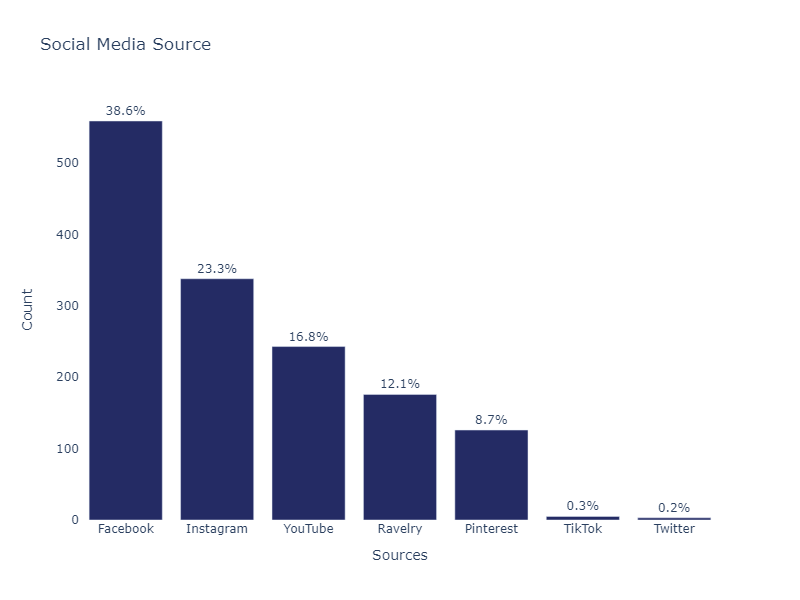

- Of the respondants, the most popular social media platform is: (From 1450 responses.)
     - For the group 'Under 18', the most popular social media platform is **YouTube** at **60.0%**, followed by **Instagram** at **20.0%**.
     - For the group '18-24', the most popular social media platform is **YouTube** at **50.0%**, followed by **Instagram** at **43.8%**.
     - For the group '25-34', the most popular social media platform is **Instagram** at **50.8%**, followed by **YouTube** at **26.2%**.
     - For the group '35-44', the most popular social media platform is **Instagram** at **32.9%**, followed by **Facebook** at **30.0%**.
     - For the group '45-54', the most popular social media platform is **Facebook** at **37.1%**, followed by **Instagram** at **24.0%**.
     - For the group '55-64', the most popular social media platform is **Facebook** at **42.1%**, followed by **Instagram** at **19.9%**.
     - For the group '65-74', the most popular social media platform is **Facebook** at **52.5%**, followed by **Pinterest** at **13.3%**.
     - For the group '75 and older', the most popular social media platform is **Facebook** at **59.7%**, followed by **Ravelry** at **16.4%**.

In [21]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular social media platform is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

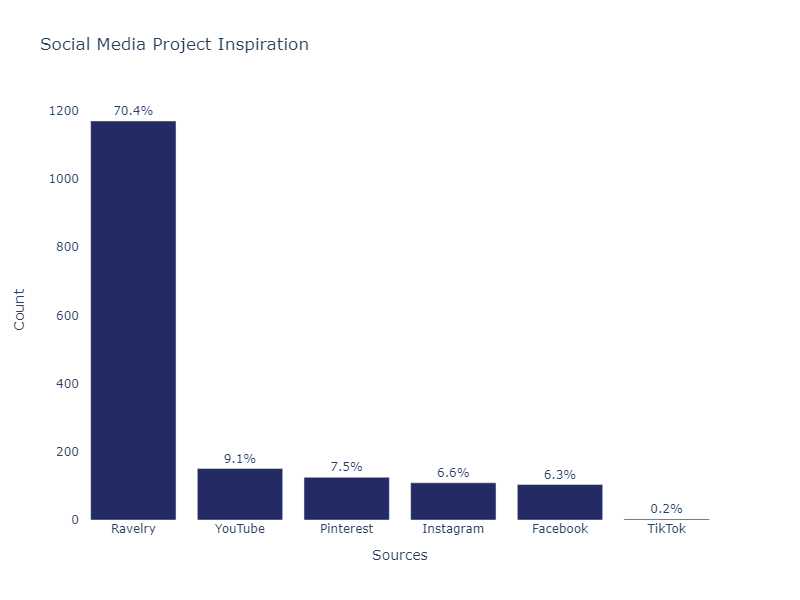

- Of the respondants, the most popular social media platform for inspiration is: (From 1662 responses.)
     - For the group 'Under 18', the most popular social media platform for inspiration is **Ravelry** at **100.0%**.
     - For the group '18-24', the most popular social media platform for inspiration is **Instagram** at **40.0%**, followed by **Ravelry** at **26.7%**.
     - For the group '25-34', the most popular social media platform for inspiration is **Ravelry** at **52.1%**, followed by **Instagram** at **19.2%**.
     - For the group '35-44', the most popular social media platform for inspiration is **Ravelry** at **59.7%**, followed by **Instagram** at **13.7%**.
     - For the group '45-54', the most popular social media platform for inspiration is **Ravelry** at **58.7%**, followed by **Instagram** at **12.3%**.
     - For the group '55-64', the most popular social media platform for inspiration is **Ravelry** at **65.6%**, followed by **YouTube** at **11.7%**.
     - For the group '65-74', the most popular social media platform for inspiration is **Ravelry** at **78.7%**, followed by **Facebook** at **7.0%**.
     - For the group '75 and older', the most popular social media platform for inspiration is **Ravelry** at **80.5%**, followed by **YouTube** at **6.5%**.

In [22]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform for inspiration is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform for inspiration is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

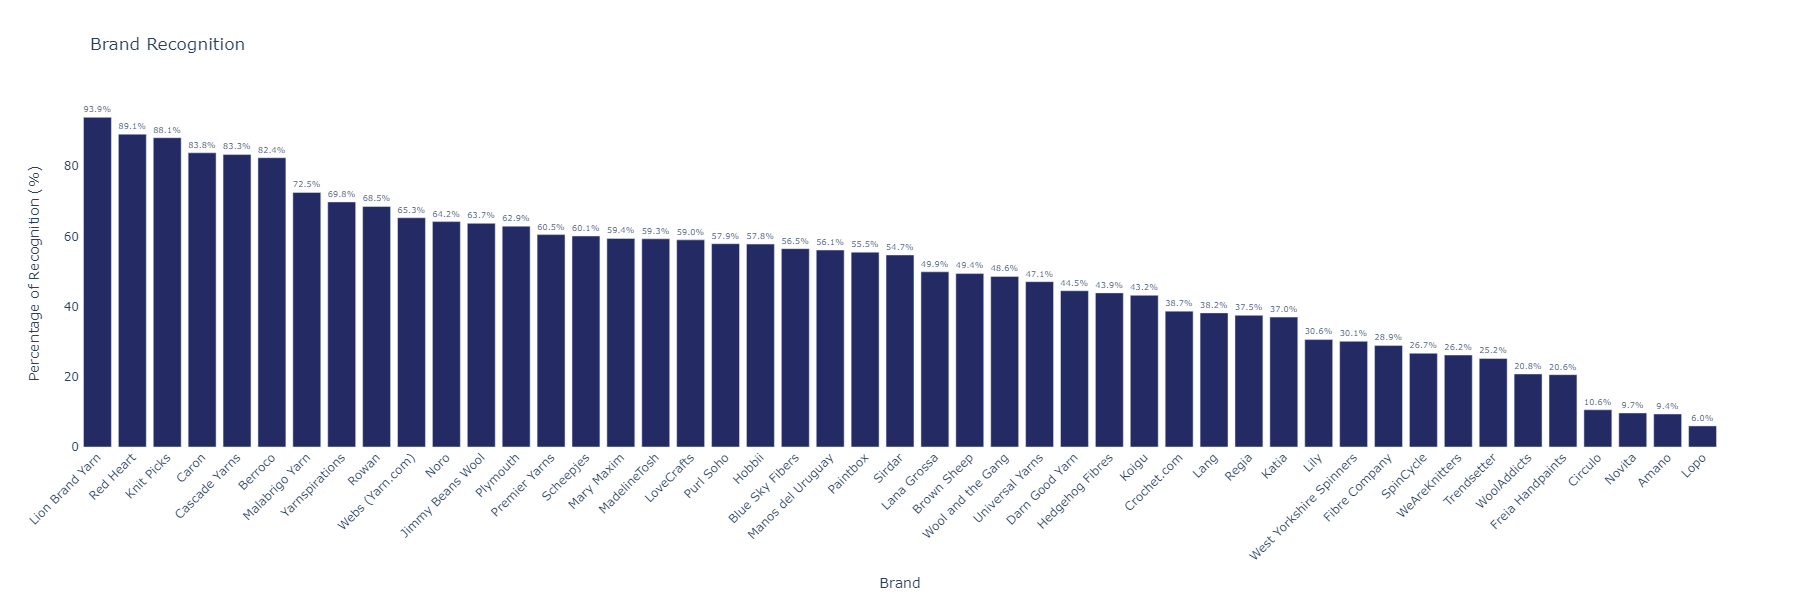

In [23]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

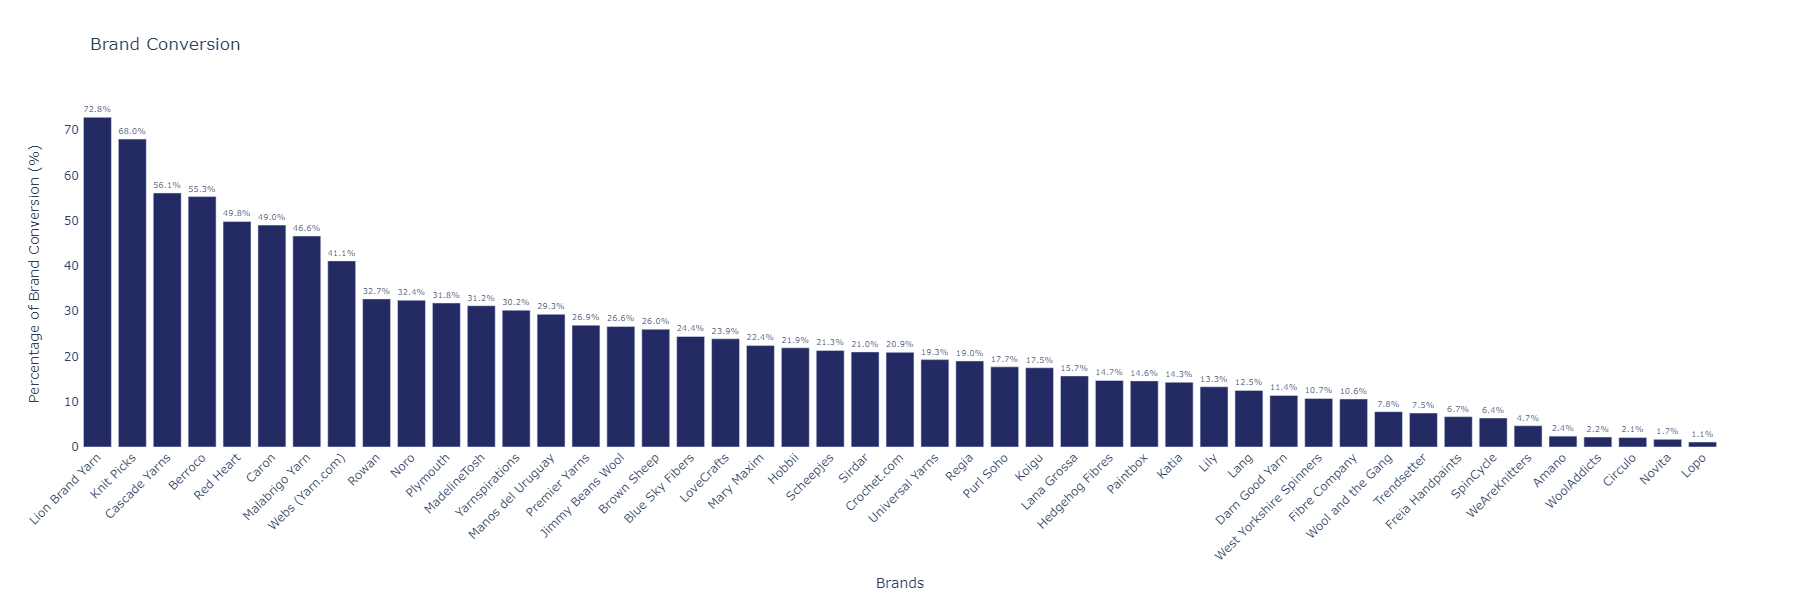

In [24]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

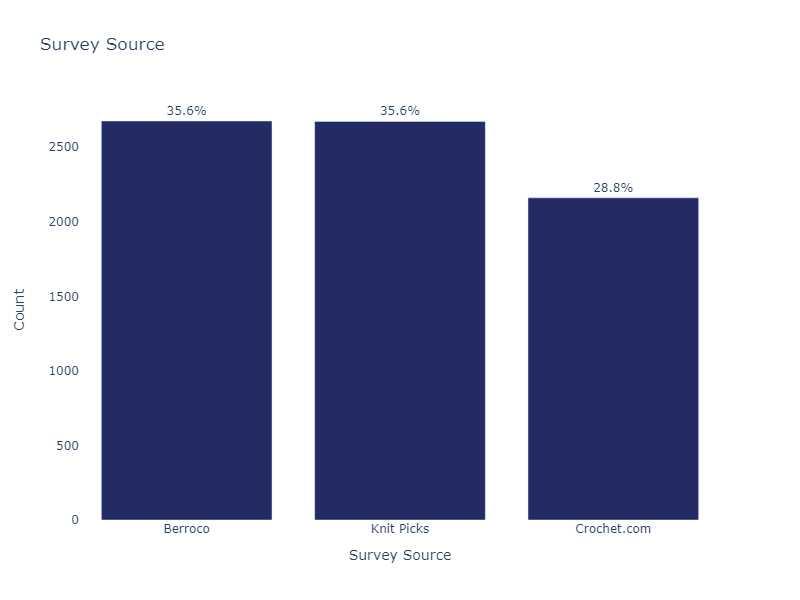

- Of the respondents, the survey sources are as follows:  (From 7510 responses)
    - "Berroco" (36%)
    - "Knit Picks" (36%)
    - "Crochet.com" (29%)


In [25]:
### Employment ###
question = all_responses.columns[25]

column_data = all_responses[all_responses.columns[25]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Survey Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Survey Source',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/survey_source.png")
display(Image(filename="./IMG/survey_source.png"))

summary = all_responses[question].dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, the survey sources are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

<div style="text-align: center;">

<h1>Knit Picks</h1>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    This section will focus on questions answered by Knit Picks respondents, and the questions unique to Knit Picks.
</div>

In [26]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')
# Filter rows where the value in the column at index 25 is 'Knit Picks'
all_responses = all_responses[all_responses.iloc[:, 25] == 'Knit Picks']

## Demographic Summary

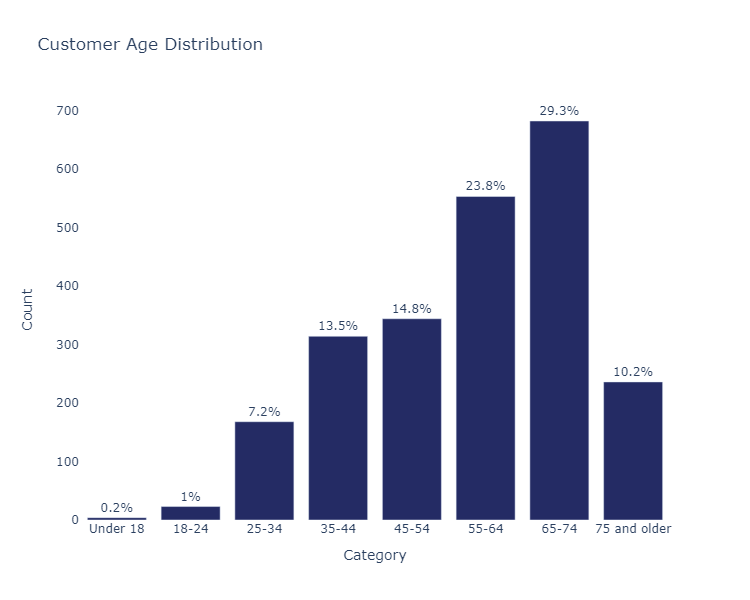

 - Out of **2324** respondants, the average respondant age is: **57** and the median age is: **59**.

- Of these respondants, they identify as:
    - "Woman" (97%)
    - "Non-Conforming / Non-Binary" (1%)
    - "Man" (1%)
    - "Transgender" (0%)


- The average household income is: **\$90,758** and the median household income is: **\$72,499** (From 1640 responses).
  - For ages **Under 18** the average household income is **\\$20,000**, the median household income is **\\$20,000** (From 1 responses.)
  - For ages **18-24** the average household income is **\\$56,562**, the median household income is **\\$35,000** (From 16 responses.)
  - For ages **25-34** the average household income is **\\$92,830**, the median household income is **\\$90,000** (From 136 responses.)
  - For ages **35-44** the average household income is **\\$104,198**, the median household income is **\\$90,000** (From 237 responses.)
  - For ages **45-54** the average household income is **\\$107,183**, the median household income is **\\$112,500** (From 221 responses.)
  - For ages **55-64** the average household income is **\\$97,670**, the median household income is **\\$90,000** (From 338 responses.)
  - For ages **65-74** the average household income is **\\$78,313**, the median household income is **\\$72,500** (From 384 responses.)
  - For ages **75 and older** the average household income is **\\$71,148**, the median household income is **\\$57,500** (From 111 responses.)


In [27]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=750,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondants, the average respondant age is: **{average_age}** and the median age is: **{median_age}**."))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = "- Of these respondants, they identify as:\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

### Income Section ###

# Income Question
question = all_responses.columns[80]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()

# Define the function to map income ranges to their midpoints
def map_income_to_midpoint(value):
    if value == 'Under $20,000':
        return 20000
    elif value == '$20,000 - $34,999':
        return (20000 + 34999) / 2
    elif value == '$35,000 - $49,999':
        return (35000 + 49999) / 2
    elif value == '$50,000 - $64,999':
        return (50000 + 64999) / 2
    elif value == '$65,000 - $79,999':
        return (65000 + 79999) / 2
    elif value == '$80,000 - $99,999':
        return (80000 + 99999) / 2
    elif value == '$100,000 - $124,999':
        return (100000 + 124999) / 2
    elif value == '$125,000 - $149,999':
        return (125000 + 149999) / 2
    elif value == '$150,000 - $174,999':
        return (150000 + 174999) / 2
    elif value == '$175,000 - $199,999':
        return (175000 + 199999) / 2
    elif value == 'Over $200,000':
        return 200000
    else:
        return np.nan

# Apply the function to the column data
income_data = column_data.map(map_income_to_midpoint)
# Calculate the average income
average_income = income_data.mean().astype(int)
# Calculate the median income
median_income = income_data.median().astype(int)
# Total count of responses
total_responses = income_data.dropna().count()
# Format the average and median income for readability with $ and commas
formatted_average_income = "\${:,.0f}".format(average_income)
formatted_median_income = "\${:,.0f}".format(median_income)

## Break down by age group. ##

age_question = all_responses.columns[75]

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[age_question] != 'Prefer not to answer') & 
                                        (all_responses[question] != 'Prefer not to answer')]

# Apply categorization and mapping for income midpoint again if necessary
filtered_responses['income_midpoint'] = filtered_responses[question].map(map_income_to_midpoint)
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Now group by the 'age_range' with the specified order
statistics = filtered_responses.groupby('age_range', observed=True)['income_midpoint'].agg(['mean', 'median', 'count']).dropna()

# First part of the markdown about average and median income
markdown_part1 = f"- The average household income is: **{formatted_average_income}** and the median household income is: **{formatted_median_income}** (From {total_responses} responses)."

# Generating the second part with the breakdown by age group
markdown_part2 = ""
for age, row in statistics.iterrows():
    avg_income = "\${:,.0f}".format(row['mean'])
    median_income = "\${:,.0f}".format(row['median'])
    responses = row['count'].astype(int)
    markdown_part2 += f"  - For ages **{age}** the average household income is **\{avg_income}**, the median household income is **\{median_income}** (From {responses} responses.)\n"

# Combine the two parts into a single Markdown display, with the second part indented as a sub-list
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

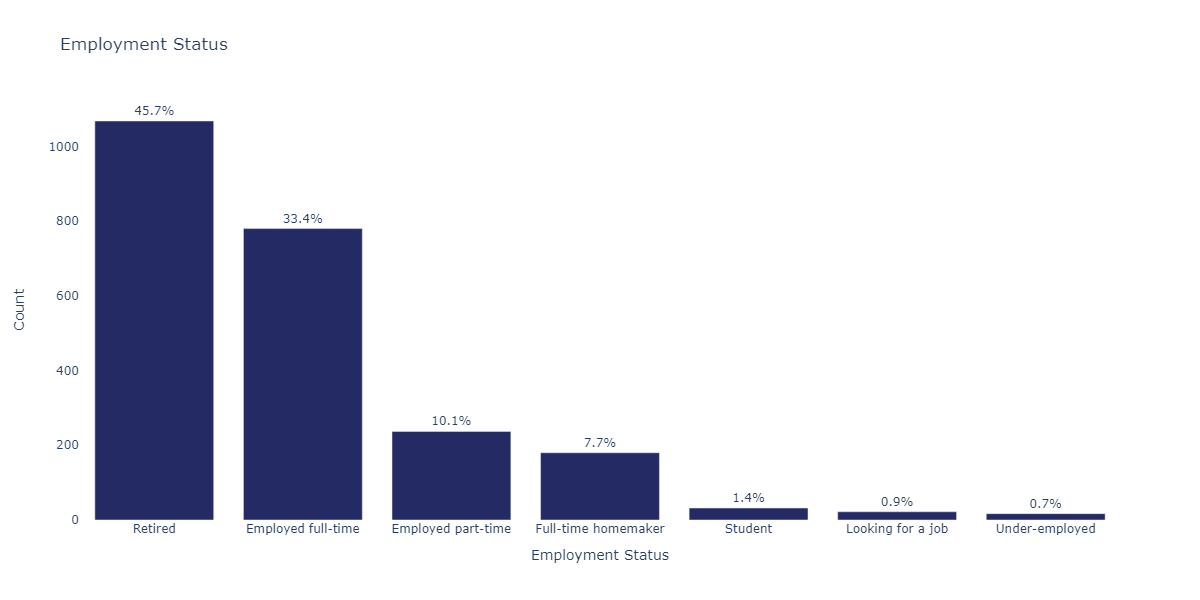

- Of the respondents, their employment statuses are as follows:  (From 2336 responses)
    - "Retired" (46%)
    - "Employed full-time" (33%)
    - "Employed part-time" (10%)
    - "Full-time homemaker" (8%)
    - "Student" (1%)
    - "Looking for a job" (1%)
    - "Under-employed" (1%)


In [28]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

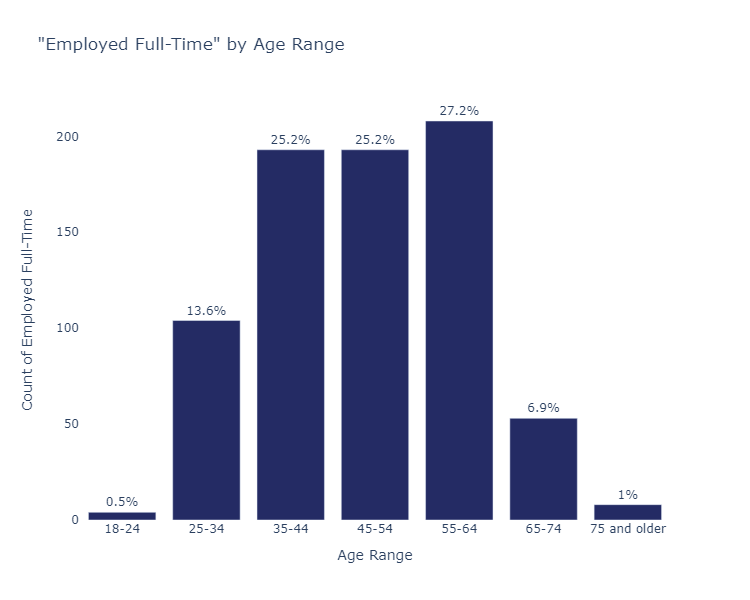

- Of those who responded 'Employed Full-Time': (From 780 responses.)
    - "55-64" (27.2%)
    - "35-44" (25.2%)
    - "45-54" (25.2%)
    - "25-34" (13.6%)
    - "65-74" (6.9%)
    - "75 and older" (1.0%)
    - "18-24" (0.5%)


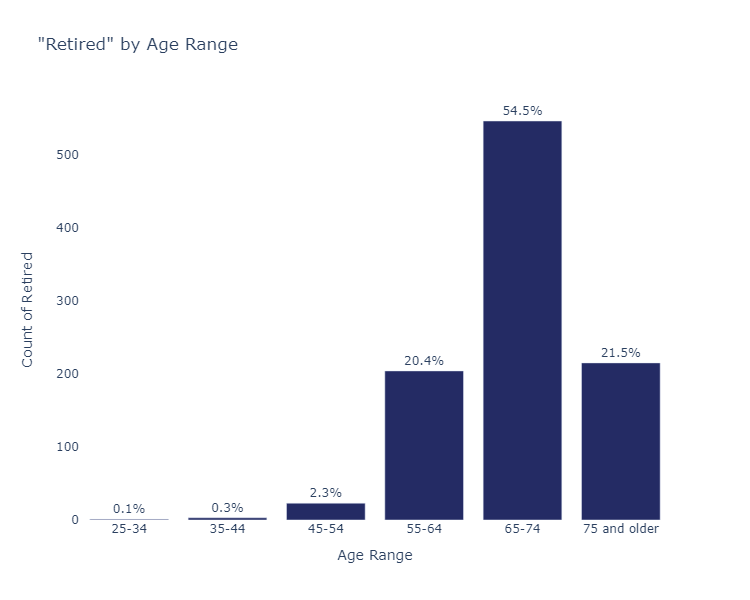

- Of those who responded 'Retired': (From 1068 responses.)
    - "65-74" (54.5%)
    - "75 and older" (21.5%)
    - "55-64" (20.4%)
    - "45-54" (2.3%)
    - "35-44" (0.3%)
    - "25-34" (0.1%)


In [29]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))


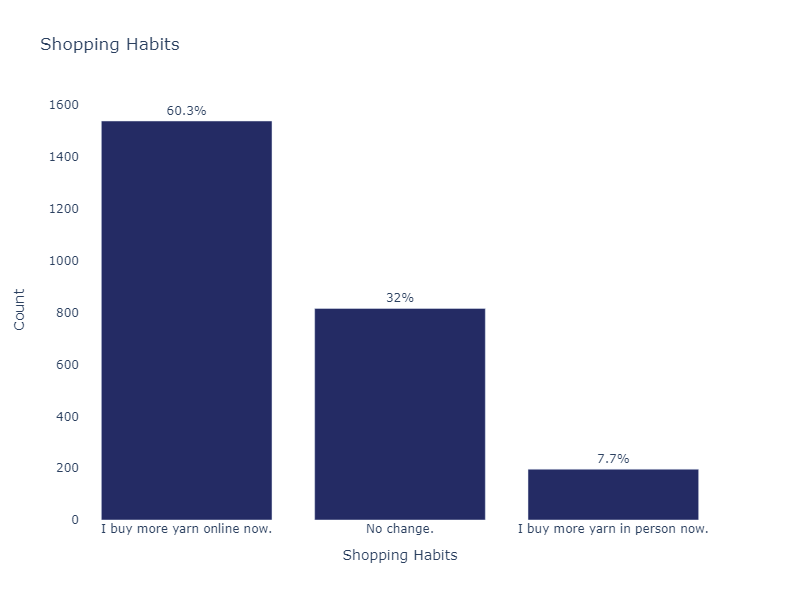

- Of the respondents, they reported that their shopping habbits have changed:  (From 2551 responses)
    - "I buy more yarn online now." (60%)
    - "No change." (32%)
    - "I buy more yarn in person now." (8%)


In [30]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

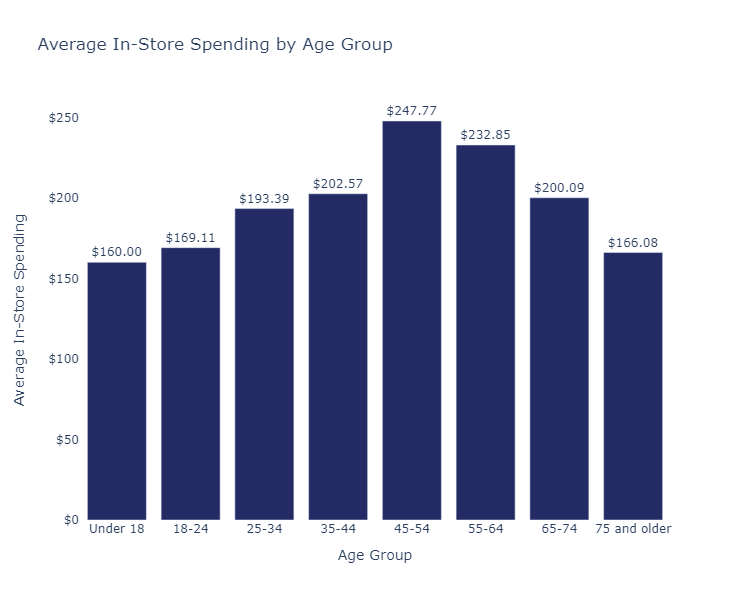

- Respondents reported making **4.1** purchases in-store per year on average, spending an average **\$50.73** per visit. On average spending **\$209.17** a year. (From 2381 responses.)
     - For the group 'Under 18', respondents reported making **8.0** purchases in-store per year on average, spending an average **\$20.00** per visit. On average spending **\$160.00** a year.
     - For the group '18-24', respondents reported making **3.9** purchases in-store per year on average, spending an average **\$43.42** per visit. On average spending **\$169.11** a year.
     - For the group '25-34', respondents reported making **4.1** purchases in-store per year on average, spending an average **\$46.85** per visit. On average spending **\$193.39** a year.
     - For the group '35-44', respondents reported making **4.1** purchases in-store per year on average, spending an average **\$49.90** per visit. On average spending **\$202.57** a year.
     - For the group '45-54', respondents reported making **4.6** purchases in-store per year on average, spending an average **\$54.15** per visit. On average spending **\$247.77** a year.
     - For the group '55-64', respondents reported making **4.3** purchases in-store per year on average, spending an average **\$54.26** per visit. On average spending **\$232.85** a year.
     - For the group '65-74', respondents reported making **4.0** purchases in-store per year on average, spending an average **\$50.31** per visit. On average spending **\$200.09** a year.
     - For the group '75 and older', respondents reported making **3.7** purchases in-store per year on average, spending an average **\$44.33** per visit. On average spending **\$166.08** a year.

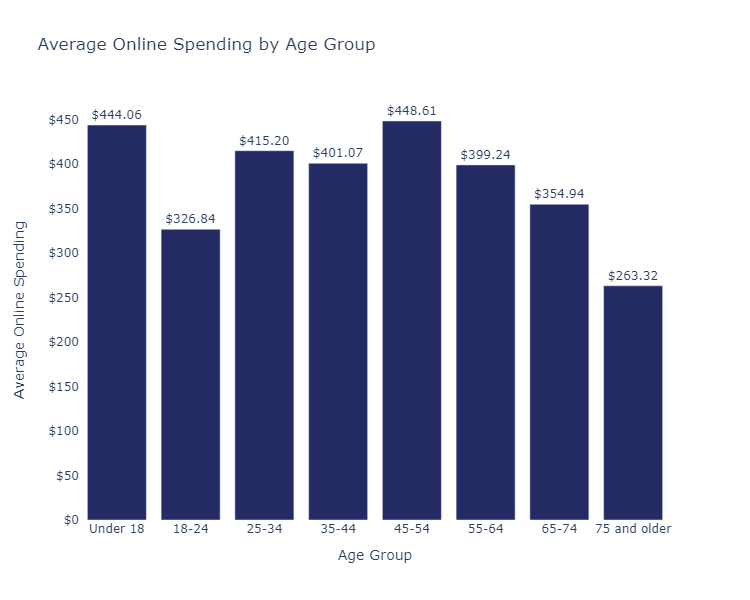

- Respondents reported making **5.1** purchases online per year on average, spending an average **\$72.67** per visit. On average spending **\$373.65** a year. (From 2430 responses.)
     - For the group 'Under 18', respondents reported making **8.8** purchases in-store per year on average, spending an average **\$50.75** per visit. On average spending **\$444.06** a year.
     - For the group '18-24', respondents reported making **4.7** purchases in-store per year on average, spending an average **\$69.00** per visit. On average spending **\$326.84** a year.
     - For the group '25-34', respondents reported making **5.1** purchases in-store per year on average, spending an average **\$81.35** per visit. On average spending **\$415.20** a year.
     - For the group '35-44', respondents reported making **5.3** purchases in-store per year on average, spending an average **\$75.90** per visit. On average spending **\$401.07** a year.
     - For the group '45-54', respondents reported making **5.4** purchases in-store per year on average, spending an average **\$82.94** per visit. On average spending **\$448.61** a year.
     - For the group '55-64', respondents reported making **5.3** purchases in-store per year on average, spending an average **\$75.15** per visit. On average spending **\$399.24** a year.
     - For the group '65-74', respondents reported making **5.1** purchases in-store per year on average, spending an average **\$69.11** per visit. On average spending **\$354.94** a year.
     - For the group '75 and older', respondents reported making **4.4** purchases in-store per year on average, spending an average **\$60.11** per visit. On average spending **\$263.32** a year.

In [31]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_online:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

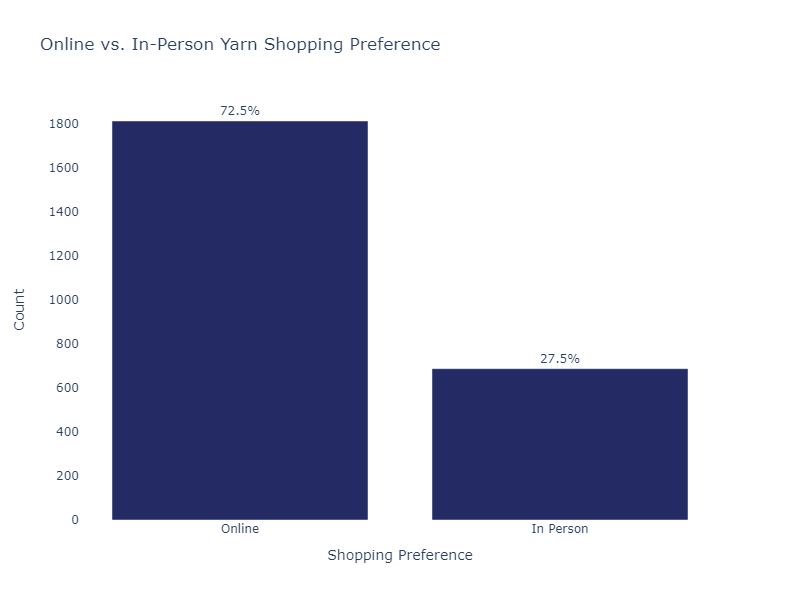

- Of the respondants **67.9%** preferred online shopping for yarn, while **25.74%** preferred shopping in person for yarn. (From 2502 responses.)
     - For the group 'Under 18', **50.0%** preferred shopping online, **50.0%** preferred shopping in person.
     - For the group '18-24', **82.6%** preferred shopping online, **17.4%** preferred shopping in person.
     - For the group '25-34', **76.2%** preferred shopping online, **23.2%** preferred shopping in person.
     - For the group '35-44', **74.8%** preferred shopping online, **23.9%** preferred shopping in person.
     - For the group '45-54', **69.5%** preferred shopping online, **25.9%** preferred shopping in person.
     - For the group '55-64', **70.3%** preferred shopping online, **27.5%** preferred shopping in person.
     - For the group '65-74', **72.6%** preferred shopping online, **25.8%** preferred shopping in person.
     - For the group '75 and older', **64.8%** preferred shopping online, **33.5%** preferred shopping in person.

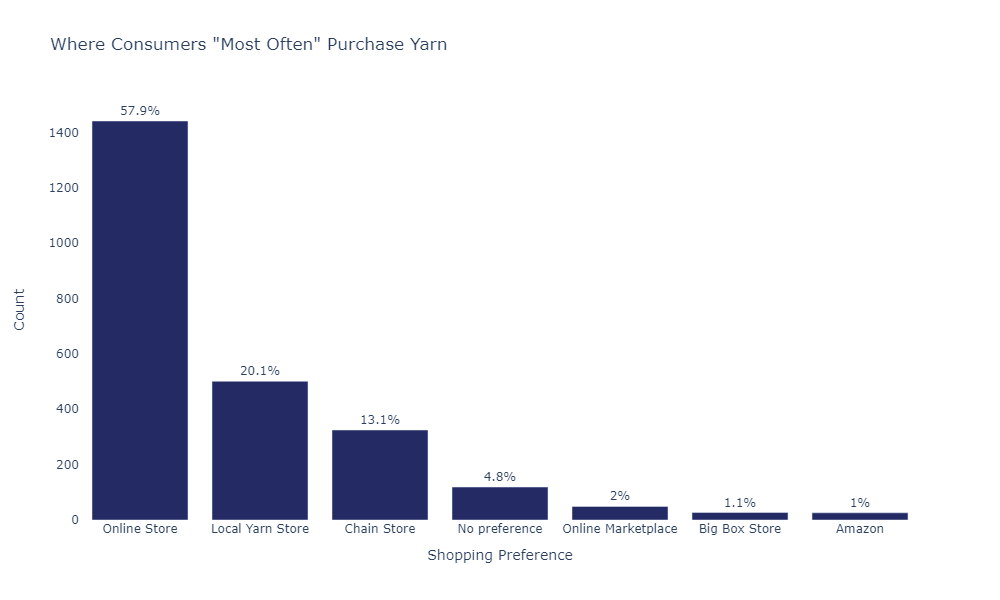

In [32]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

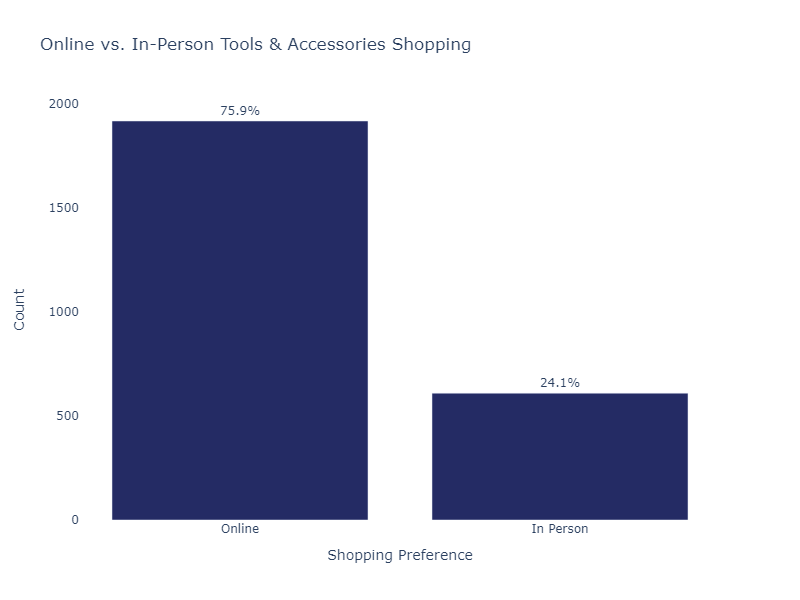

- Of the respondants **71.7%** preferred online shopping for tools & accessories, while **22.78%** preferred shopping in person for tools & accessories. (From 2525 responses.)
     - For the group 'Under 18', **75.0%** preferred shopping online, **25.0%** preferred shopping in person.
     - For the group '18-24', **78.3%** preferred shopping online, **21.7%** preferred shopping in person.
     - For the group '25-34', **76.2%** preferred shopping online, **23.2%** preferred shopping in person.
     - For the group '35-44', **81.2%** preferred shopping online, **17.5%** preferred shopping in person.
     - For the group '45-54', **75.9%** preferred shopping online, **21.5%** preferred shopping in person.
     - For the group '55-64', **75.9%** preferred shopping online, **23.0%** preferred shopping in person.
     - For the group '65-74', **75.4%** preferred shopping online, **23.9%** preferred shopping in person.
     - For the group '75 and older', **62.7%** preferred shopping online, **34.3%** preferred shopping in person.

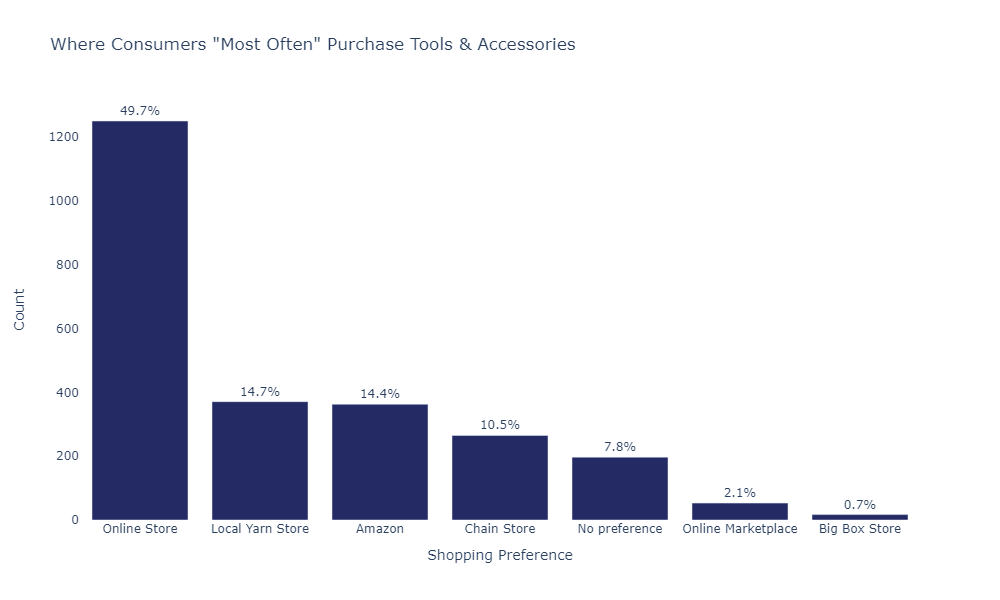

In [33]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

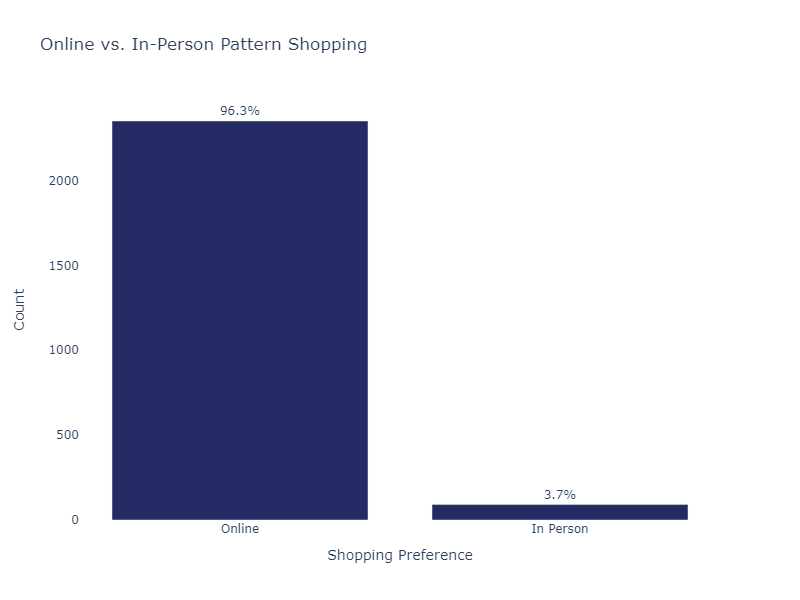

- Of the respondants **88.0%** preferred online shopping for patterns, while **3.40%** preferred shopping in person for patterns. (From 2442 responses.)
     - For the group 'Under 18', **75.0%** preferred shopping online, **0.0%** preferred shopping in person.
     - For the group '18-24', **100.0%** preferred shopping online, **0.0%** preferred shopping in person.
     - For the group '25-34', **94.6%** preferred shopping online, **1.2%** preferred shopping in person.
     - For the group '35-44', **95.9%** preferred shopping online, **2.5%** preferred shopping in person.
     - For the group '45-54', **97.1%** preferred shopping online, **0.6%** preferred shopping in person.
     - For the group '55-64', **94.2%** preferred shopping online, **2.5%** preferred shopping in person.
     - For the group '65-74', **90.6%** preferred shopping online, **3.7%** preferred shopping in person.
     - For the group '75 and older', **81.8%** preferred shopping online, **10.2%** preferred shopping in person.

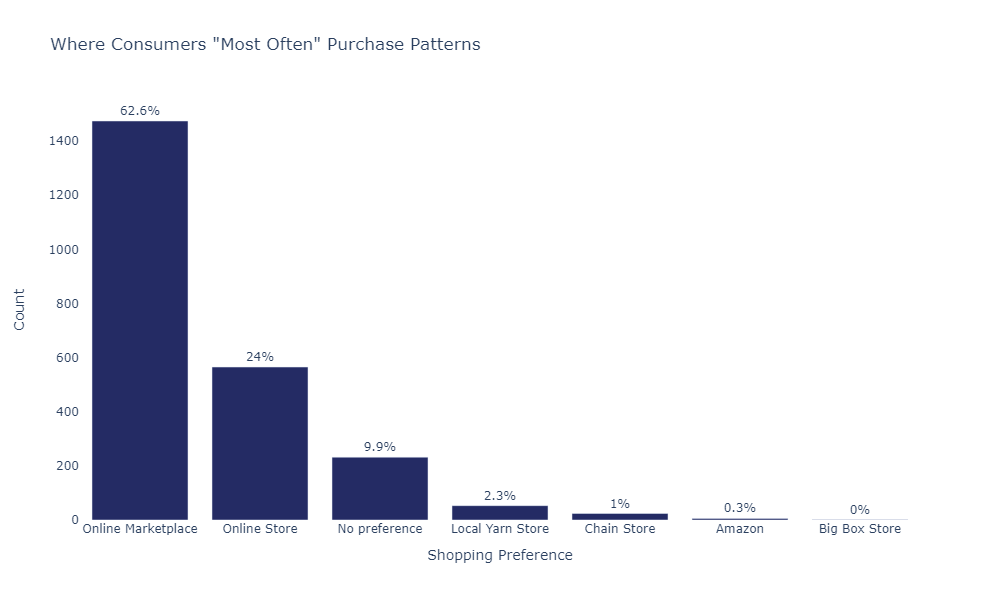

In [34]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

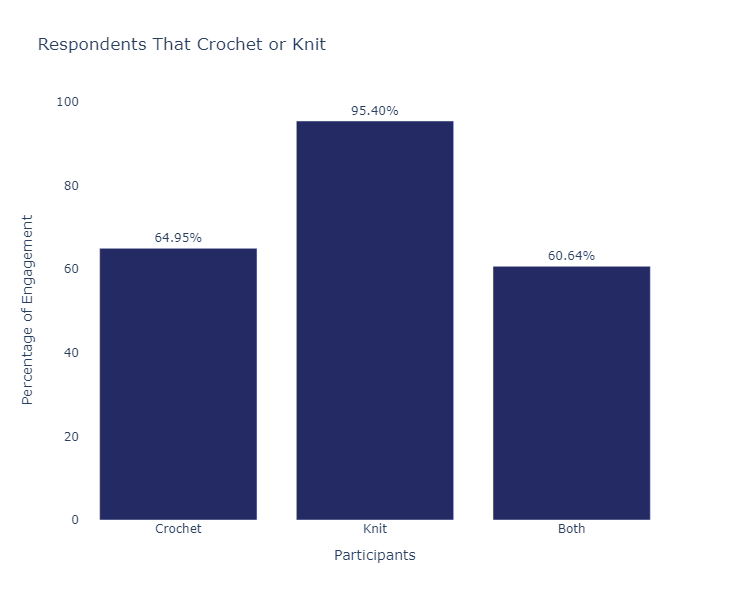

- Of the respondants, **64.9%** responded 'Yes' to crocheting, **95.40%** responded 'Yes' to knitting, while **60.64%** of respondants engage in both. (From 2673 responses.)
     - For the group 'Under 18', **100.0%** responded 'Yes' to crocheting, **100.0%** responded 'Yes' to knitting, and **100.0%** to both.
     - For the group '18-24', **73.9%** responded 'Yes' to crocheting, **95.7%** responded 'Yes' to knitting, and **69.6%** to both.
     - For the group '25-34', **67.3%** responded 'Yes' to crocheting, **94.6%** responded 'Yes' to knitting, and **62.5%** to both.
     - For the group '35-44', **63.4%** responded 'Yes' to crocheting, **97.1%** responded 'Yes' to knitting, and **60.5%** to both.
     - For the group '45-54', **64.8%** responded 'Yes' to crocheting, **93.6%** responded 'Yes' to knitting, and **58.4%** to both.
     - For the group '55-64', **69.6%** responded 'Yes' to crocheting, **94.4%** responded 'Yes' to knitting, and **64.0%** to both.
     - For the group '65-74', **63.0%** responded 'Yes' to crocheting, **96.3%** responded 'Yes' to knitting, and **59.5%** to both.
     - For the group '75 and older', **60.2%** responded 'Yes' to crocheting, **96.6%** responded 'Yes' to knitting, and **57.2%** to both.

In [35]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondants, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondants engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.1f}%** responded 'Yes' to knitting, and **{both_yes_percent:.1f}%** to both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

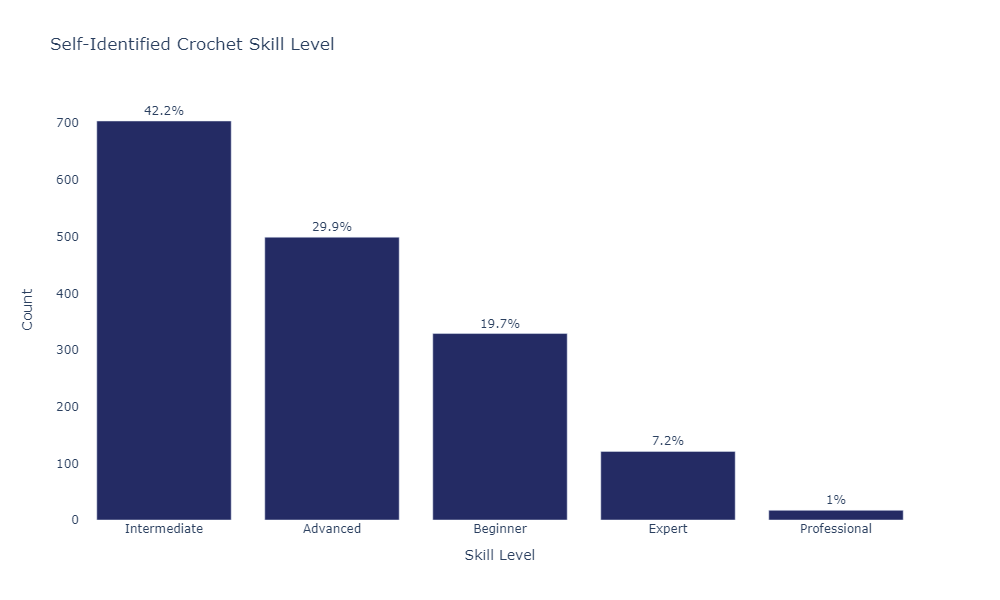

- Of the respondants who crochet, they rate their skill level as the following: (From 1736 responses.)
    - **42.16%** of respondents answered 'Intermediate'.
    - **29.88%** of respondents answered 'Advanced'.
    - **19.70%** of respondents answered 'Beginner'.
    - **7.25%** of respondents answered 'Expert'.
    - **1.02%** of respondents answered 'Professional'.


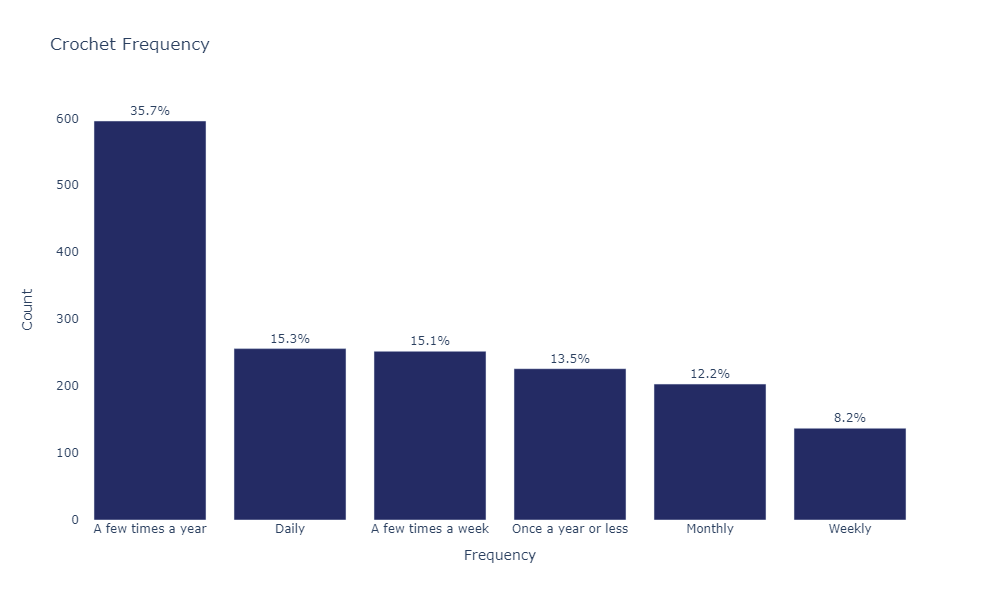

- Of the respondants who crochet, the frequency they do so is: (From 1736 responses.)
    - **35.69%** of respondents answered 'A few times a year'.
    - **15.33%** of respondents answered 'Daily'.
    - **15.09%** of respondents answered 'A few times a week'.
    - **13.53%** of respondents answered 'Once a year or less'.
    - **12.16%** of respondents answered 'Monthly'.
    - **8.20%** of respondents answered 'Weekly'.


In [36]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



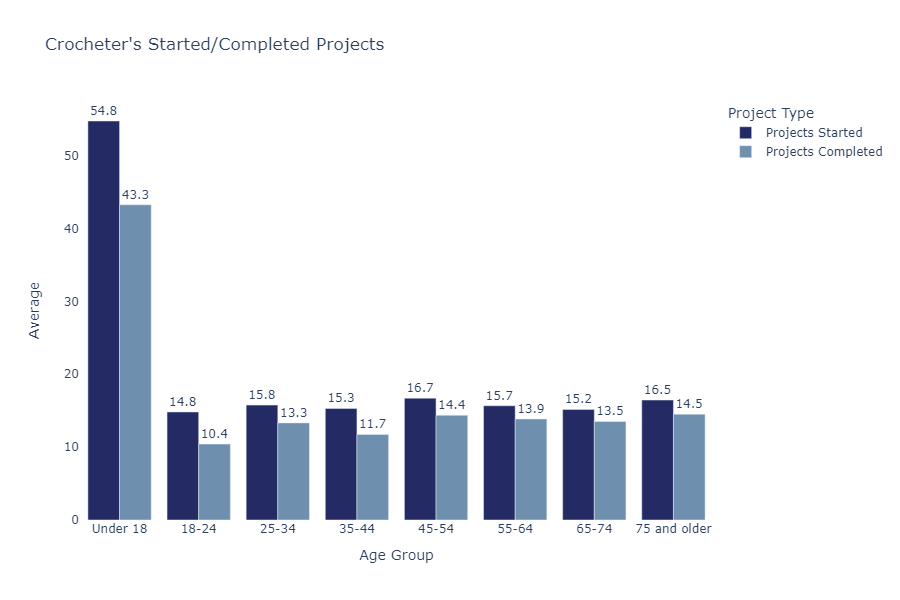

- Of the respondants, on average they start **15.8** crochet projects a year, and on average they complete **13.6** crochet projects a year. (From 1736 responses.)
     - For the group 'Under 18', they start **54.8** crochet projects a year, and on average they complete **43.2** crochet projects a year.
     - For the group '18-24', they start **14.8** crochet projects a year, and on average they complete **10.4** crochet projects a year.
     - For the group '25-34', they start **15.8** crochet projects a year, and on average they complete **13.3** crochet projects a year.
     - For the group '35-44', they start **15.3** crochet projects a year, and on average they complete **11.7** crochet projects a year.
     - For the group '45-54', they start **16.7** crochet projects a year, and on average they complete **14.4** crochet projects a year.
     - For the group '55-64', they start **15.7** crochet projects a year, and on average they complete **13.9** crochet projects a year.
     - For the group '65-74', they start **15.2** crochet projects a year, and on average they complete **13.5** crochet projects a year.
     - For the group '75 and older', they start **16.5** crochet projects a year, and on average they complete **14.5** crochet projects a year.

In [37]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondants, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

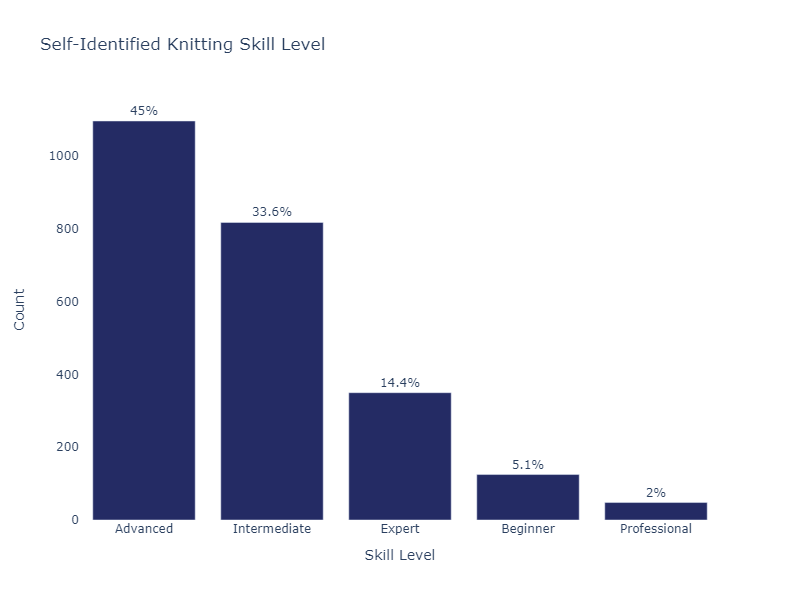

- Of the respondants who knit, they rate their skill level as the following: (From 2550 responses.)
    - **45.00%** of respondents answered 'Advanced'.
    - **33.55%** of respondents answered 'Intermediate'.
    - **14.36%** of respondents answered 'Expert'.
    - **5.13%** of respondents answered 'Beginner'.
    - **1.97%** of respondents answered 'Professional'.


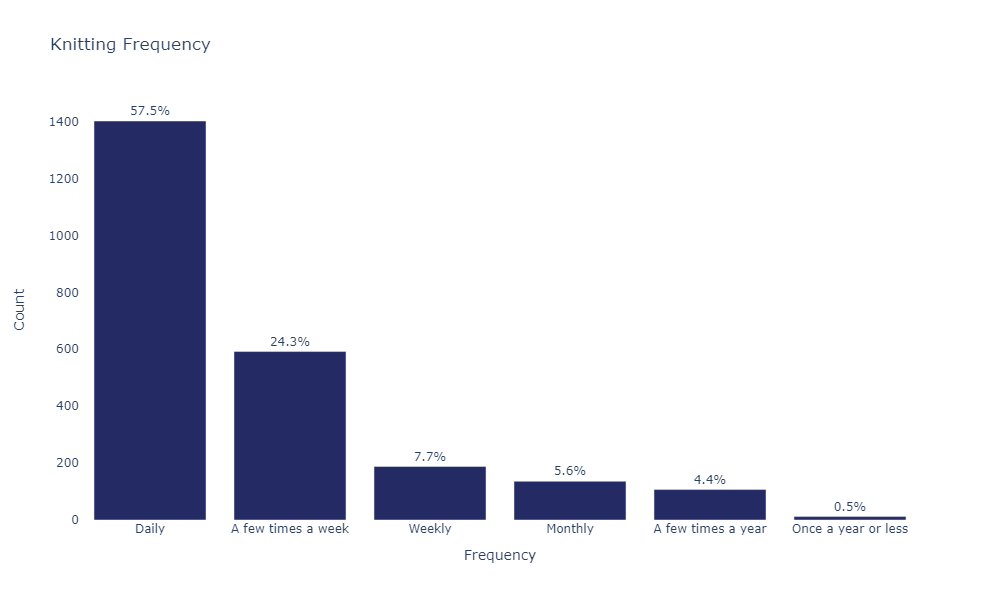

- Of the respondants who knit, the frequency they do so is: (From 2550 responses.)
    - **57.53%** of respondents answered 'Daily'.
    - **24.29%** of respondents answered 'A few times a week'.
    - **7.71%** of respondents answered 'Weekly'.
    - **5.58%** of respondents answered 'Monthly'.
    - **4.39%** of respondents answered 'A few times a year'.
    - **0.49%** of respondents answered 'Once a year or less'.


In [38]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



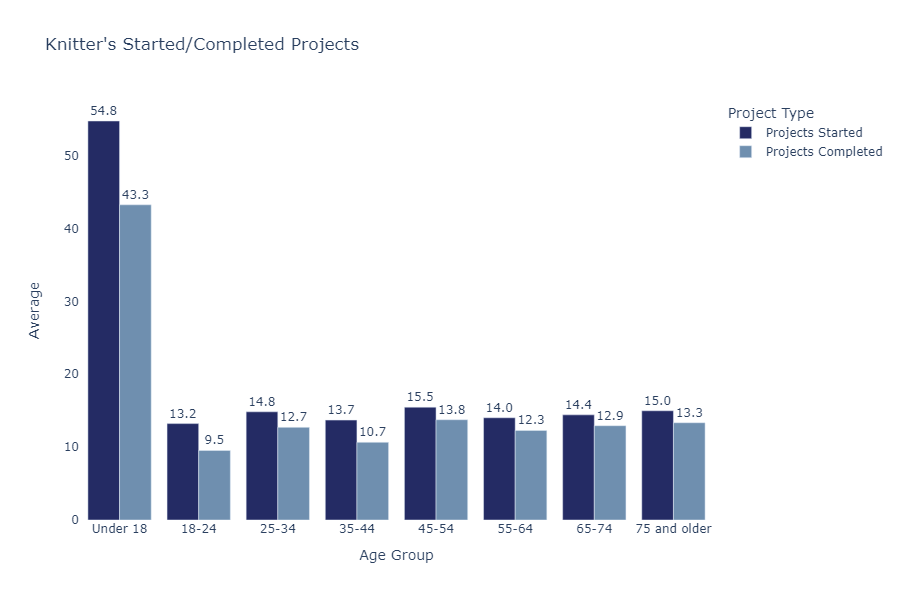

- Of the respondants, on average they start **14.5** knitting projects a year, and on average they complete **12.6** knitting projects a year. (From 2550 responses.)
     - For the group 'Under 18', they start **54.8** knitting projects a year, and on average they complete **43.2** knitting projects a year.
     - For the group '18-24', they start **13.2** knitting projects a year, and on average they complete **9.5** knitting projects a year.
     - For the group '25-34', they start **14.8** knitting projects a year, and on average they complete **12.7** knitting projects a year.
     - For the group '35-44', they start **13.7** knitting projects a year, and on average they complete **10.7** knitting projects a year.
     - For the group '45-54', they start **15.5** knitting projects a year, and on average they complete **13.8** knitting projects a year.
     - For the group '55-64', they start **14.0** knitting projects a year, and on average they complete **12.3** knitting projects a year.
     - For the group '65-74', they start **14.4** knitting projects a year, and on average they complete **12.9** knitting projects a year.
     - For the group '75 and older', they start **15.0** knitting projects a year, and on average they complete **13.3** knitting projects a year.

In [39]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondants, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

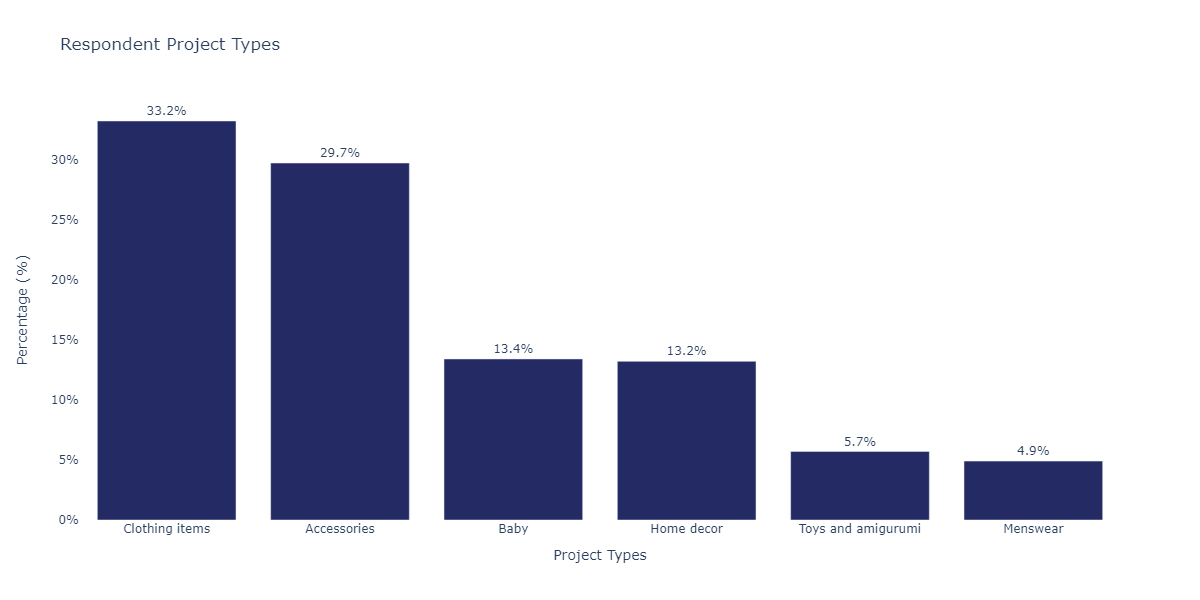

- Of the respondents, the most popular project type for all yarn crafts is: (From 2550 responses.)
     - For the group 'Under 18', the most popular project type is **Accessories** at **37.5%**, **Clothing items** at **37.5%**, and **Home decor** at **25.0%**.
     - For the group '18-24', the most popular project type is **Clothing items** at **41.2%**, **Accessories** at **21.6%**, and **Toys and amigurumi** at **11.8%**.
     - For the group '25-34', the most popular project type is **Clothing items** at **35.6%**, **Accessories** at **27.3%**, and **Home decor** at **12.9%**.
     - For the group '35-44', the most popular project type is **Clothing items** at **32.4%**, **Accessories** at **28.7%**, and **Home decor** at **15.3%**.
     - For the group '45-54', the most popular project type is **Clothing items** at **33.5%**, **Accessories** at **30.5%**, and **Home decor** at **13.3%**.
     - For the group '55-64', the most popular project type is **Clothing items** at **33.2%**, **Accessories** at **29.9%**, and **Baby** at **13.4%**.
     - For the group '65-74', the most popular project type is **Clothing items** at **33.8%**, **Accessories** at **29.7%**, and **Baby** at **15.1%**.
     - For the group '75 and older', the most popular project type is **Accessories** at **30.8%**, **Clothing items** at **30.4%**, and **Baby** at **17.3%**.

In [40]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check if there are at least two project types to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular project types
            markdown_summary += f"\n     - For the group '{age}', the most popular project type is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**, and **{percentages.iloc[2, 0]}** at **{percentages.iloc[2, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular project type is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

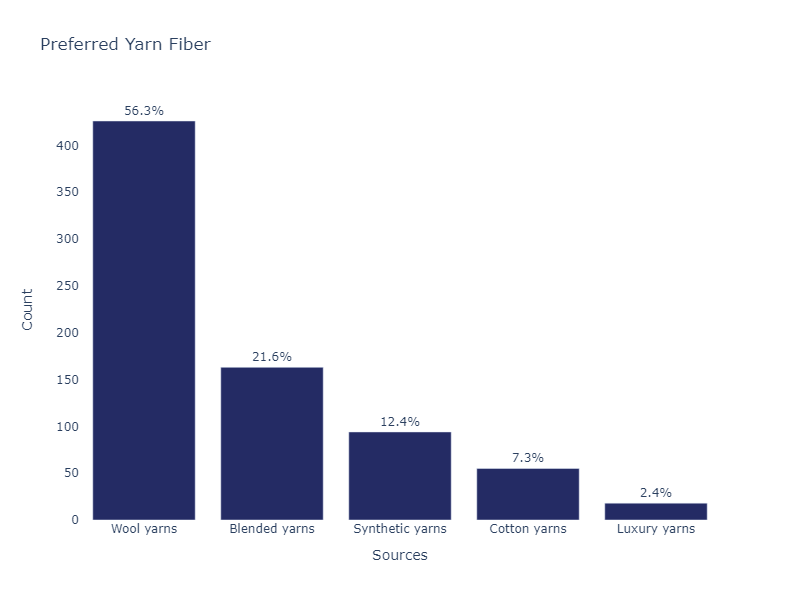

- Of the respondants, the most popular yarn fiber is: (From 756 responses.)
     - For the group 'Under 18', the most popular yarn fiber is **Wool yarns** at **100.0%**.
     - For the group '18-24', the most popular yarn fiber is **Wool yarns** at **37.5%**, followed by **Synthetic yarns** at **25.0%**.
     - For the group '25-34', the most popular yarn fiber is **Wool yarns** at **62.9%**, followed by **Blended yarns** at **20.0%**.
     - For the group '35-44', the most popular yarn fiber is **Wool yarns** at **70.4%**, followed by **Blended yarns** at **13.6%**.
     - For the group '45-54', the most popular yarn fiber is **Wool yarns** at **58.7%**, followed by **Blended yarns** at **20.7%**.
     - For the group '55-64', the most popular yarn fiber is **Wool yarns** at **59.4%**, followed by **Blended yarns** at **19.4%**.
     - For the group '65-74', the most popular yarn fiber is **Wool yarns** at **51.4%**, followed by **Blended yarns** at **25.5%**.
     - For the group '75 and older', the most popular yarn fiber is **Wool yarns** at **53.9%**, followed by **Blended yarns** at **23.6%**.

In [41]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular yarn fiber is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular yarn fiber is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

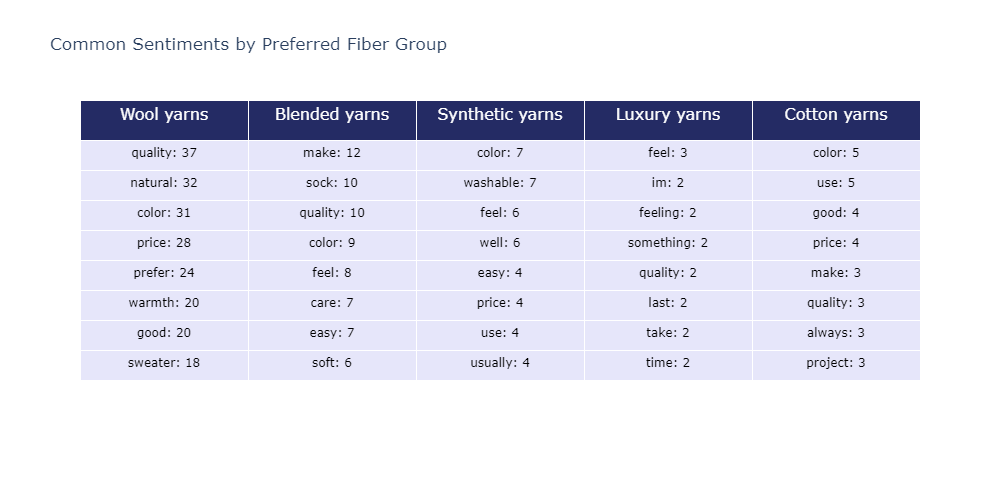

In [42]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine',
    'want'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Use lemmatization instead of stemming
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))

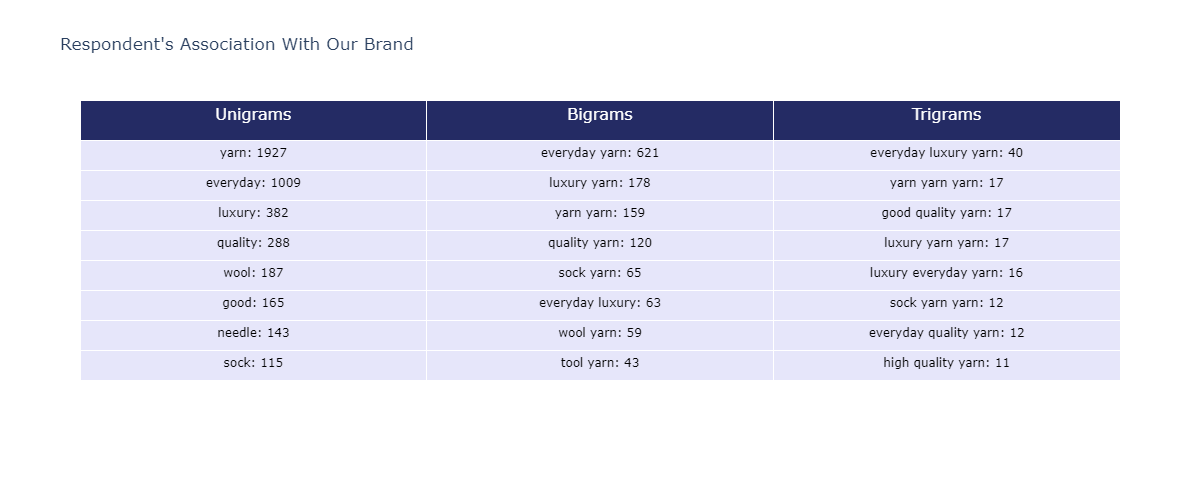

In [43]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[39]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'like',
    'dont know',
    'every',
    'day'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(8)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)


# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Respondent\'s Association With Our Brand',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200
)

fig.update_traces(columnwidth=[15, 15, 15])

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

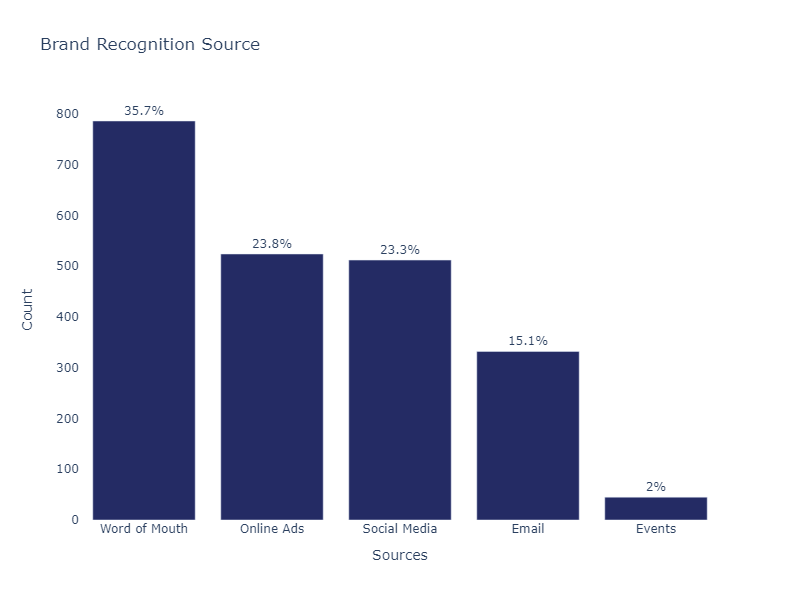

- Of the respondants, the most popular brand discovery source is: (From 2538 responses.)
     - For the group 'Under 18', the most popular discovery source is **Social Media** at **66.7%**, followed by **Word of Mouth** at **33.3%**.
     - For the group '18-24', the most popular discovery source is **Online Ads** at **34.8%**, followed by **Word of Mouth** at **30.4%**.
     - For the group '25-34', the most popular discovery source is **Social Media** at **35.0%**, followed by **Word of Mouth** at **33.8%**.
     - For the group '35-44', the most popular discovery source is **Word of Mouth** at **37.3%**, followed by **Social Media** at **28.0%**.
     - For the group '45-54', the most popular discovery source is **Word of Mouth** at **38.8%**, followed by **Social Media** at **28.9%**.
     - For the group '55-64', the most popular discovery source is **Word of Mouth** at **33.7%**, followed by **Social Media** at **26.6%**.
     - For the group '65-74', the most popular discovery source is **Word of Mouth** at **36.9%**, followed by **Online Ads** at **25.0%**.
     - For the group '75 and older', the most popular discovery source is **Word of Mouth** at **40.3%**, followed by **Online Ads** at **23.4%**.

In [44]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular brand discovery source is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular discovery source is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular  discovery source is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

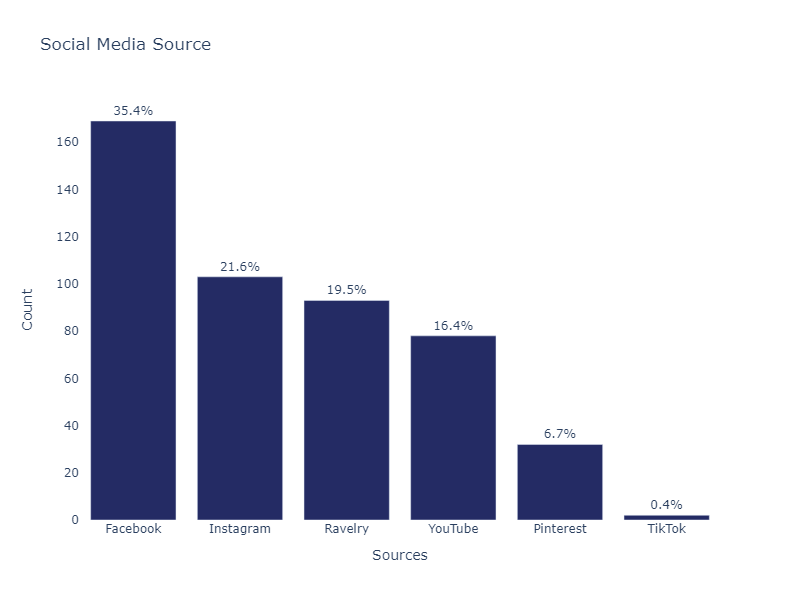

- Of the respondants, the most popular social media platform is: (From 477 responses.)
     - For the group 'Under 18', the most popular social media platform is **TikTok** at **50.0%**, followed by **YouTube** at **50.0%**.
     - For the group '18-24', the most popular social media platform is **Instagram** at **83.3%**, followed by **YouTube** at **16.7%**.
     - For the group '25-34', the most popular social media platform is **Instagram** at **40.0%**, followed by **YouTube** at **30.0%**.
     - For the group '35-44', the most popular social media platform is **Instagram** at **28.6%**, followed by **Facebook** at **27.1%**.
     - For the group '45-54', the most popular social media platform is **Facebook** at **34.2%**, followed by **YouTube** at **24.1%**.
     - For the group '55-64', the most popular social media platform is **Facebook** at **41.4%**, followed by **Instagram** at **18.1%**.
     - For the group '65-74', the most popular social media platform is **Facebook** at **46.1%**, followed by **Ravelry** at **20.6%**.
     - For the group '75 and older', the most popular social media platform is **Facebook** at **59.1%**, followed by **Ravelry** at **22.7%**.

In [45]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular social media platform is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

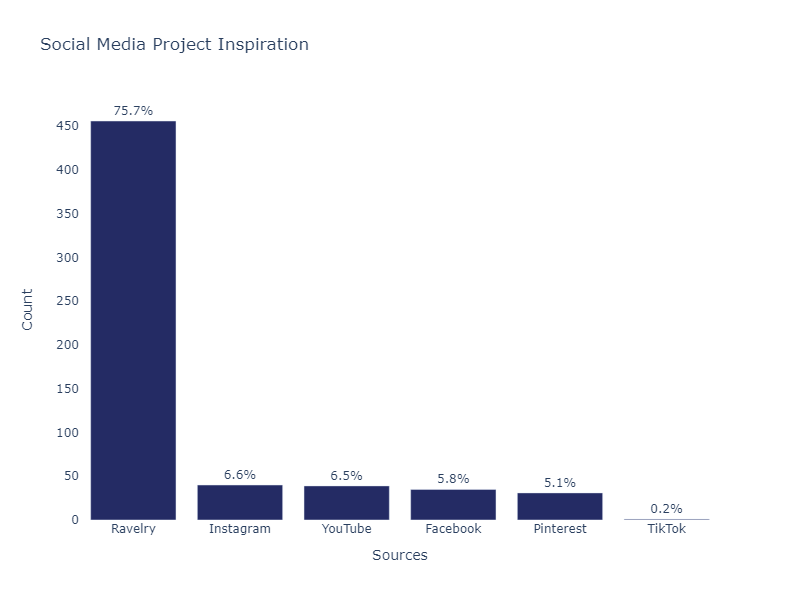

- Of the respondants, the most popular social media platform for inspiration is: (From 602 responses.)
     - For the group '18-24', the most popular social media platform for inspiration is **Instagram** at **44.4%**, followed by **Ravelry** at **33.3%**.
     - For the group '25-34', the most popular social media platform for inspiration is **Ravelry** at **61.4%**, followed by **Instagram** at **15.9%**.
     - For the group '35-44', the most popular social media platform for inspiration is **Ravelry** at **79.7%**, followed by **Instagram** at **8.5%**.
     - For the group '45-54', the most popular social media platform for inspiration is **Ravelry** at **72.6%**, followed by **Facebook** at **11.3%**.
     - For the group '55-64', the most popular social media platform for inspiration is **Ravelry** at **75.2%**, followed by **Instagram** at **6.8%**.
     - For the group '65-74', the most popular social media platform for inspiration is **Ravelry** at **79.7%**, followed by **Facebook** at **6.8%**.
     - For the group '75 and older', the most popular social media platform for inspiration is **Ravelry** at **88.3%**, followed by **Pinterest** at **5.0%**.

In [46]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform for inspiration is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform for inspiration is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

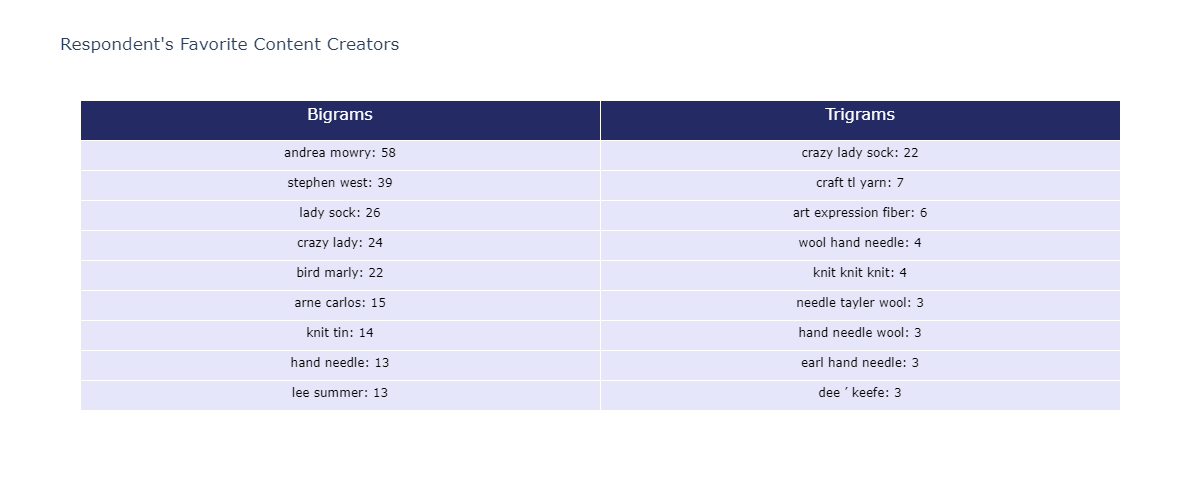

In [47]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[45]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'like',
    'dont know',
    'dont',
    'every',
    'day',
    'favorite',
    'follow',
    'particular',
    'one'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(9)

# Combine uni, bi, and tri grams
#uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Bigrams', 'Trigrams']
ngram_data = [ bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)


# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Respondent\'s Favorite Content Creators',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200
)

fig.update_traces(columnwidth=[15, 15, 15])

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

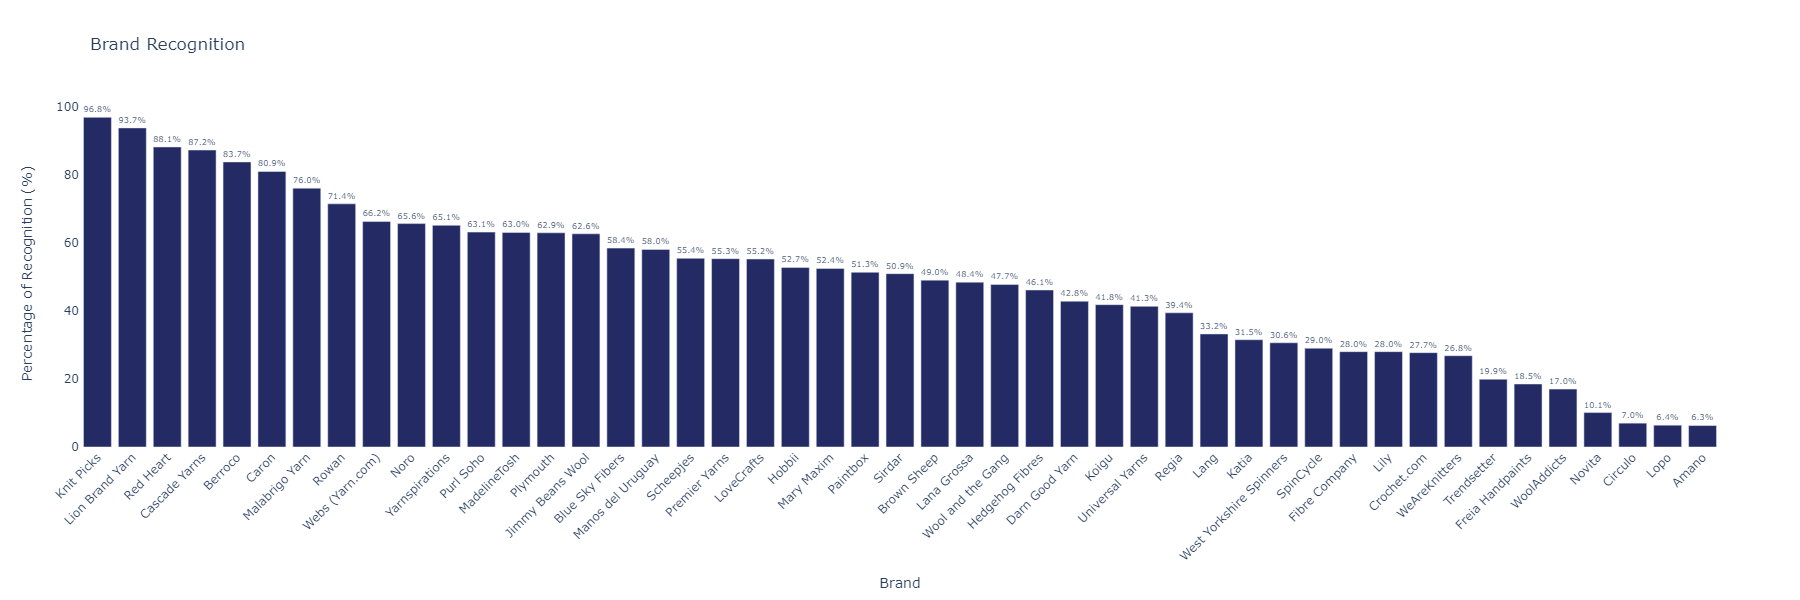

In [48]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

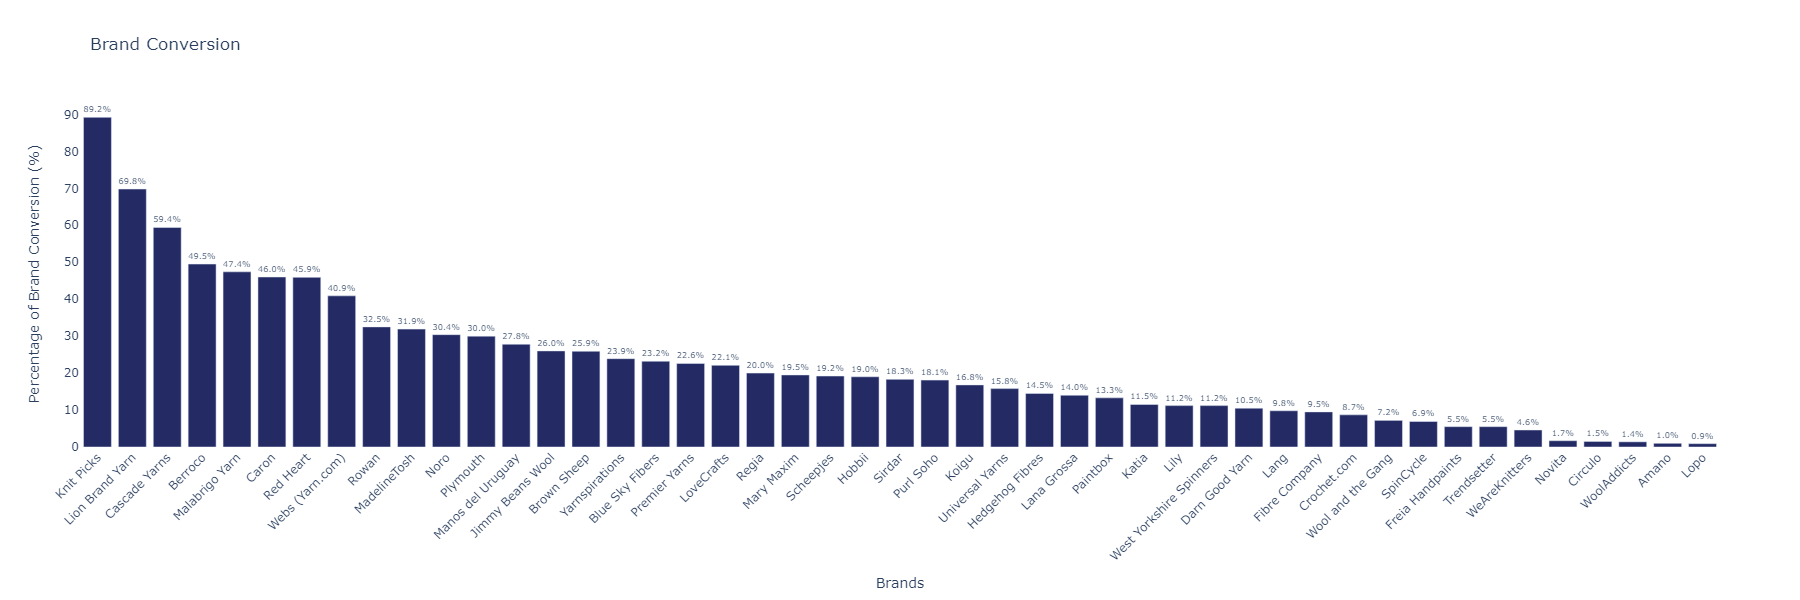

In [49]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

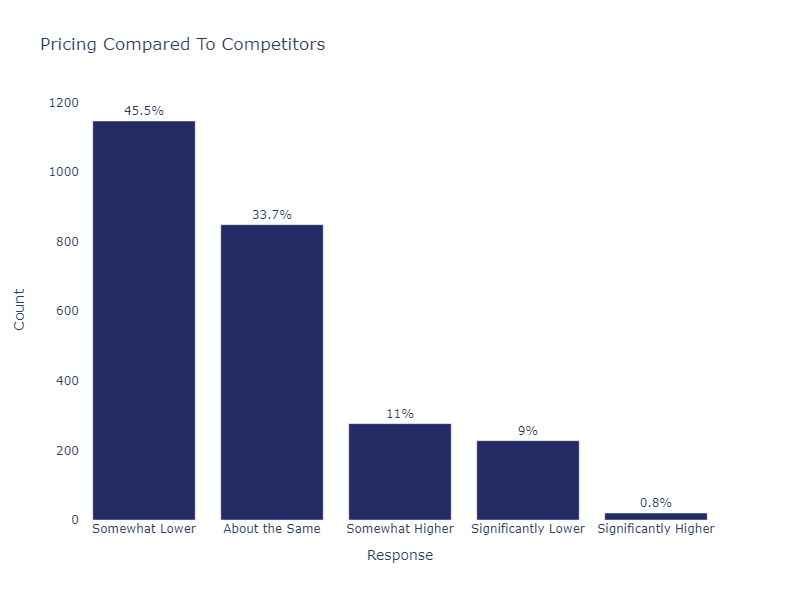

- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From 2521 responses)
    - "Somewhat Lower" (45%)
    - "About the Same" (34%)
    - "Somewhat Higher" (11%)
    - "Significantly Lower" (9%)
    - "Significantly Higher" (1%)


In [50]:
### Employment ###
question = all_responses.columns[31]

column_data = all_responses[all_responses.columns[31]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Pricing Compared To Competitors',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/survey_source.png")
display(Image(filename="./IMG/survey_source.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

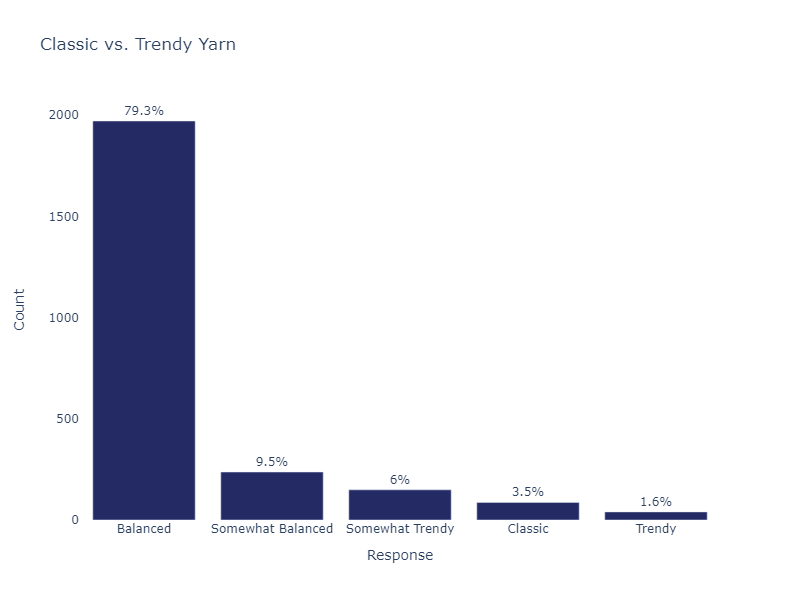

- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From 2484 responses)
    - "Balanced" (79%)
    - "Somewhat Balanced" (10%)
    - "Somewhat Trendy" (6%)
    - "Classic" (4%)
    - "Trendy" (2%)


In [51]:
### Employment ###
question = all_responses.columns[48]

column_data = all_responses[all_responses.columns[48]].dropna()
sample_size = column_data.shape[0]

# Define the function to map income ranges to their midpoints
def map_answer(value):
    if value == 1:
        return 'Classic'
    elif value == 2:
        return 'Somewhat Balanced'
    elif value == 3:
        return 'Balanced'
    elif value == 4:
        return 'Somewhat Trendy'
    elif value == 5:
        return 'Trendy'
    else:
        return np.nan

# Apply the function to the column data
column_data = column_data.map(map_answer)

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Classic vs. Trendy Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/trendy_classic_yarn.png")
display(Image(filename="./IMG/trendy_classic_yarn.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

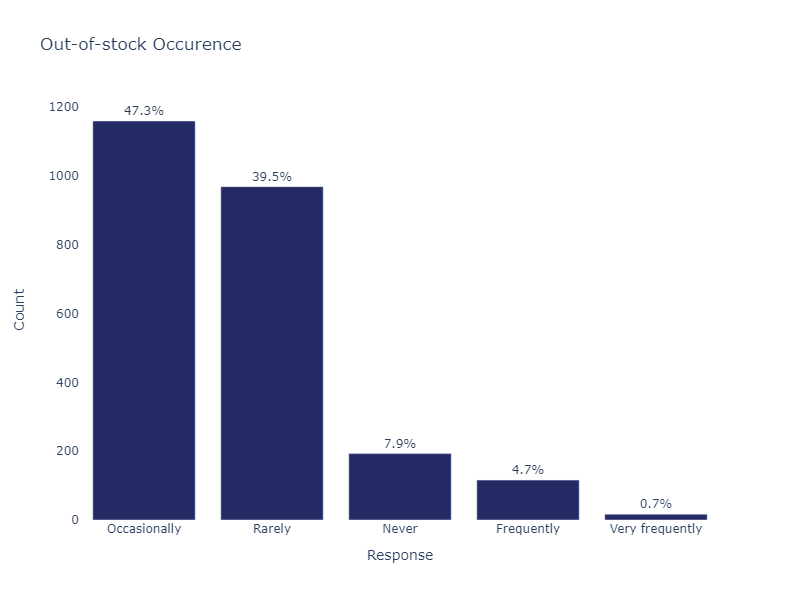

- Of the respondents, when asked about how often is something you want from our website out-of-stock?:  (From 2455 responses)
    - "Occasionally" (47%)
    - "Rarely" (39%)
    - "Never" (8%)
    - "Frequently" (5%)
    - "Very frequently" (1%)


In [52]:
question = all_responses.columns[49]

column_data = all_responses[all_responses.columns[49]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-of-stock Occurence',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/out_of_stock.png")
display(Image(filename="./IMG/out_of_stock.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about how often is something you want from our website out-of-stock?:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

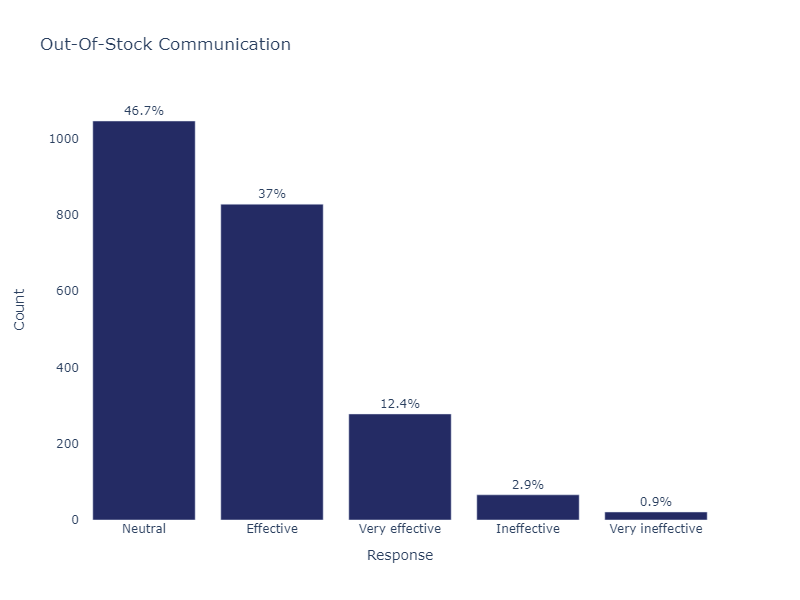

- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication when items are restocked?:  (From 2239 responses)
    - "Neutral" (47%)
    - "Effective" (37%)
    - "Very effective" (12%)
    - "Ineffective" (3%)
    - "Very ineffective" (1%)


In [53]:
question = all_responses.columns[50]

column_data = all_responses[all_responses.columns[50]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-Of-Stock Communication',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/out_of_stock_communication.png")
display(Image(filename="./IMG/out_of_stock_communication.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication when items are restocked?:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

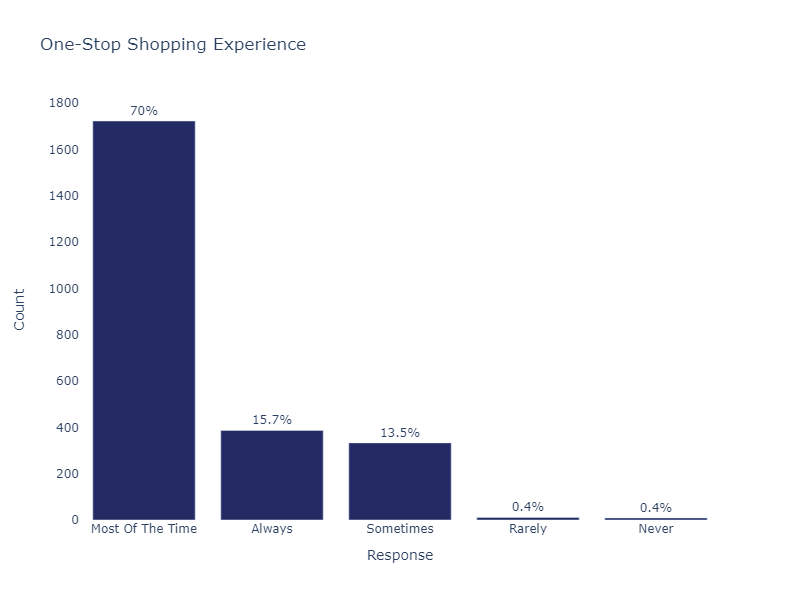

- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From 2463 responses)
    - "Most Of The Time" (70%)
    - "Always" (16%)
    - "Sometimes" (14%)
    - "Rarely" (0%)
    - "Never" (0%)


In [54]:
question = all_responses.columns[51]

column_data = all_responses[all_responses.columns[51]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='One-Stop Shopping Experience',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/one_stop_shop.png")
display(Image(filename="./IMG/one_stop_shop.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

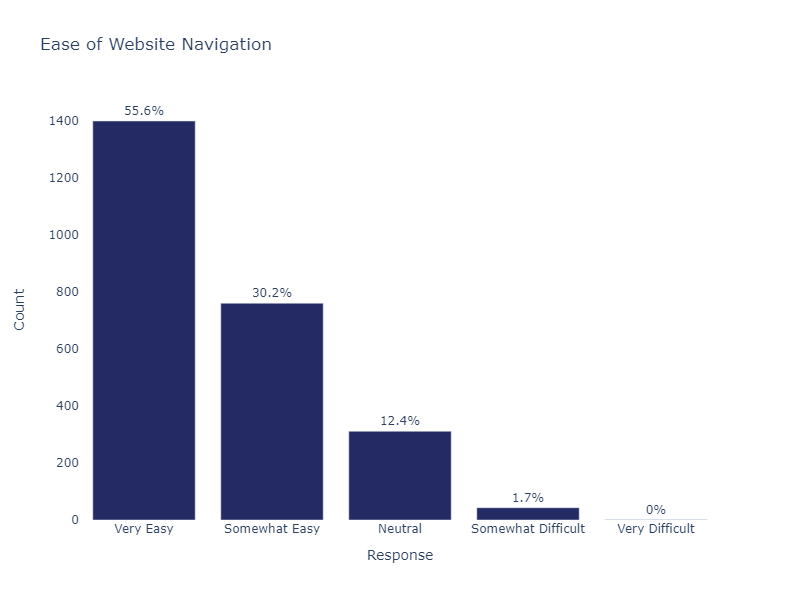

- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From 2514 responses)
    - "Very Easy" (56%)
    - "Somewhat Easy" (30%)
    - "Neutral" (12%)
    - "Somewhat Difficult" (2%)
    - "Very Difficult" (0%)


In [55]:
question = all_responses.columns[53]

column_data = all_responses[all_responses.columns[53]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Ease of Website Navigation',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/website_navigation.png")
display(Image(filename="./IMG/website_navigation.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

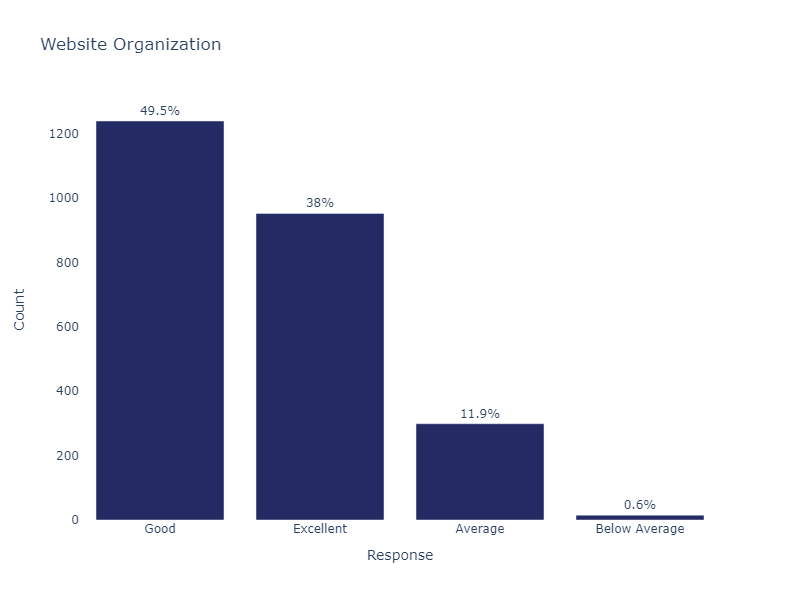

- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From 2505 responses)
    - "Good" (49%)
    - "Excellent" (38%)
    - "Average" (12%)
    - "Below Average" (1%)


In [56]:
question = all_responses.columns[55]

column_data = all_responses[all_responses.columns[55]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Website Organization',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/website_organization.png")
display(Image(filename="./IMG/website_organization.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

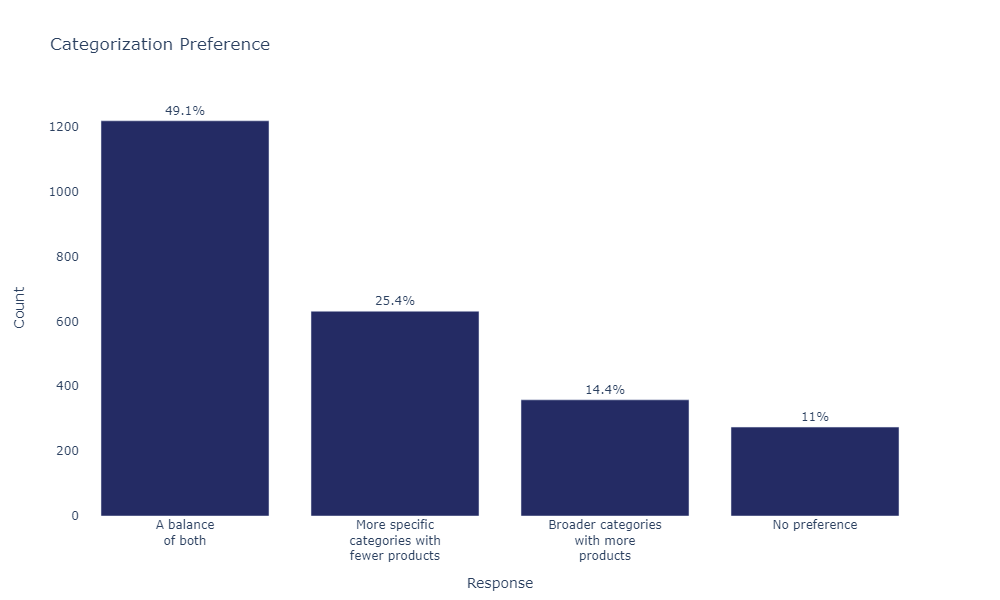

- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From 2481 responses)
    - "A balance of both" (49%)
    - "More specific categories with fewer products" (25%)
    - "Broader categories with more products" (14%)
    - "No preference" (11%)


In [57]:
question = all_responses.columns[56]

column_data = all_responses[all_responses.columns[56]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

def insert_line_breaks(text):
    words = text.split()
    # Insert '<br>' after every two words
    return '<br>'.join(' '.join(words[i:i+2]) for i in range(0, len(words), 2))

# Apply the function to each category to insert line breaks
summary_df['CategoryWrapped'] = summary_df['Category'].apply(insert_line_breaks)

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='CategoryWrapped', y='Count', title='Categorization Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout to improve readability
fig.update_layout(
    xaxis=dict(
        title='Response',
        tickmode='array',
        tickvals=summary_df['CategoryWrapped'],  # Use the wrapped category
        ticktext=summary_df['CategoryWrapped']   # Use the wrapped text for ticktext
    ),
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000,
    margin=dict(t=100)
)
# Show the figure
fig.write_image("./IMG/categorization_preference.png")
display(Image(filename="./IMG/categorization_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

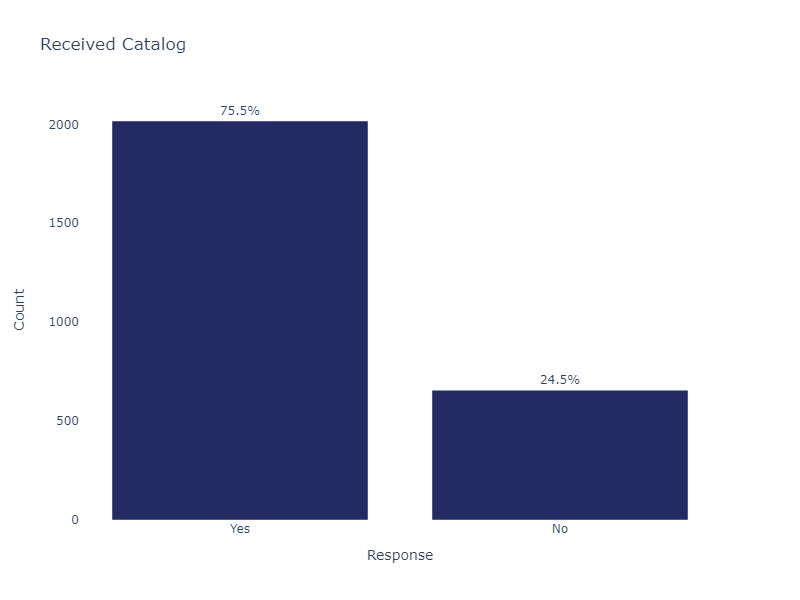

- Of the respondents, when asked if they have received one of our catalogs before:  (From 2673 responses)
    - "Yes" (75%)
    - "No" (25%)


In [58]:
question = all_responses.columns[57]

column_data = all_responses[all_responses.columns[57]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Received Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_received.png")
display(Image(filename="./IMG/catalog_received.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have received one of our catalogs before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

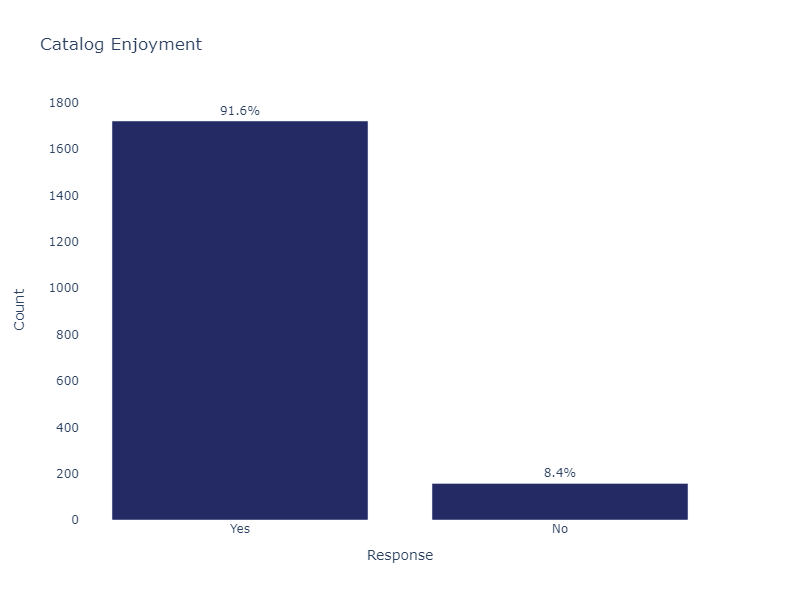

- Of the respondents, when asked if they enjoy receiving our catalog:  (From 1880 responses)
    - "Yes" (92%)
    - "No" (8%)


- Of the respondents, when asked if they enjoy receiving our catalog: 
     - For the group 'Under 18', when asked if they enjoy receiving our catalog: **Yes** at **100.0%**.
     - For the group '18-24', when asked if they enjoy receiving our catalog: **Yes** at **85.7%**, followed by **No** at **14.3%**.
     - For the group '25-34', when asked if they enjoy receiving our catalog: **Yes** at **84.3%**, followed by **No** at **15.7%**.
     - For the group '35-44', when asked if they enjoy receiving our catalog: **Yes** at **89.6%**, followed by **No** at **10.4%**.
     - For the group '45-54', when asked if they enjoy receiving our catalog: **Yes** at **90.3%**, followed by **No** at **9.7%**.
     - For the group '55-64', when asked if they enjoy receiving our catalog: **Yes** at **92.9%**, followed by **No** at **7.1%**.
     - For the group '65-74', when asked if they enjoy receiving our catalog: **Yes** at **93.0%**, followed by **No** at **7.0%**.
     - For the group '75 and older', when asked if they enjoy receiving our catalog: **Yes** at **94.1%**, followed by **No** at **5.9%**.

In [59]:
column_data = all_responses[all_responses.columns[58]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enjoyment',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_enjoyment.png")
display(Image(filename="./IMG/catalog_enjoyment.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they enjoy receiving our catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[58], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they enjoy receiving our catalog: "

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', when asked if they enjoy receiving our catalog: **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', when asked if they enjoy receiving our catalog: **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

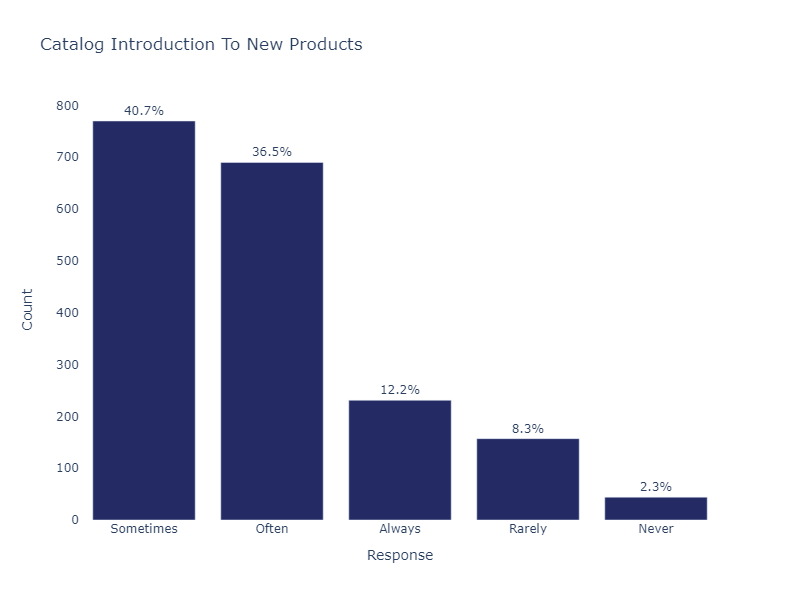

- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From 1892 responses)
    - "Sometimes" (41%)
    - "Often" (36%)
    - "Always" (12%)
    - "Rarely" (8%)
    - "Never" (2%)


- Of the respondents,  when asked if catalogs have introduced them to products they weren't aware of before: (From 1892 responses.)
     - For the group 'Under 18', they responded as: **Rarely** at **50.0%**, and **Always** at **50.0%**.
     - For the group '18-24', they responded as: **Always** at **35.7%**, **Sometimes** at **35.7%**, and **Rarely** at **21.4%**.
     - For the group '25-34', they responded as: **Sometimes** at **41.3%**, **Often** at **28.9%**, and **Rarely** at **15.7%**.
     - For the group '35-44', they responded as: **Sometimes** at **40.5%**, **Often** at **30.2%**, and **Always** at **14.9%**.
     - For the group '45-54', they responded as: **Sometimes** at **38.5%**, **Often** at **35.4%**, and **Always** at **15.2%**.
     - For the group '55-64', they responded as: **Often** at **38.8%**, **Sometimes** at **38.3%**, and **Always** at **12.5%**.
     - For the group '65-74', they responded as: **Sometimes** at **41.3%**, **Often** at **40.8%**, and **Always** at **11.5%**.
     - For the group '75 and older', they responded as: **Sometimes** at **47.7%**, **Often** at **34.3%**, and **Always** at **10.5%**.

In [60]:
column_data = all_responses[all_responses.columns[59]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Introduction To New Products',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_new_products.png")
display(Image(filename="./IMG/catalog_new_products.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[59], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents,  when asked if catalogs have introduced them to products they weren't aware of before: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

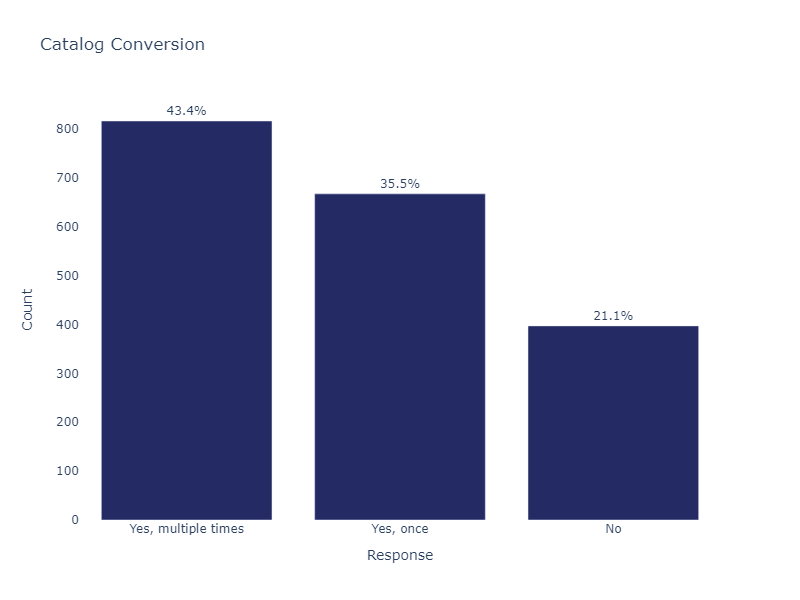

- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From 1880 responses)
    - "Yes, multiple times" (43%)
    - "Yes, once" (35%)
    - "No" (21%)


- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From 1880 responses.)
     - For the group 'Under 18', they responded as: **No** at **50.0%**, and **Yes, once** at **50.0%**.
     - For the group '18-24', they responded as: **No** at **50.0%**, **Yes, once** at **35.7%**, and **Yes, multiple times** at **14.3%**.
     - For the group '25-34', they responded as: **No** at **40.0%**, **Yes, once** at **37.5%**, and **Yes, multiple times** at **22.5%**.
     - For the group '35-44', they responded as: **Yes, once** at **36.8%**, **Yes, multiple times** at **33.1%**, and **No** at **30.2%**.
     - For the group '45-54', they responded as: **Yes, multiple times** at **41.2%**, **Yes, once** at **40.8%**, and **No** at **18.0%**.
     - For the group '55-64', they responded as: **Yes, multiple times** at **47.5%**, **Yes, once** at **33.4%**, and **No** at **19.1%**.
     - For the group '65-74', they responded as: **Yes, multiple times** at **49.2%**, **Yes, once** at **33.3%**, and **No** at **17.5%**.
     - For the group '75 and older', they responded as: **Yes, multiple times** at **52.4%**, **Yes, once** at **34.1%**, and **No** at **13.5%**.

In [61]:
column_data = all_responses[all_responses.columns[60]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Conversion',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_purchase.png")
display(Image(filename="./IMG/catalog_purchase.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[60], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

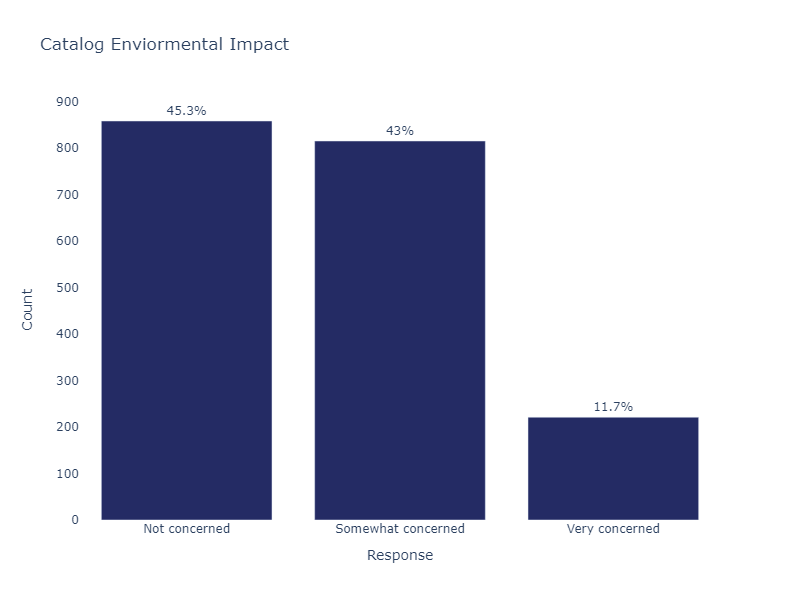

- Of the respondents, when asked if they had enviornmental concerns about the catalog:  (From 1894 responses)
    - "Not concerned" (45%)
    - "Somewhat concerned" (43%)
    - "Very concerned" (12%)


- Of the respondents, when asked if they had enviornmental concerns about the catalog: (From 1894 responses.)
     - For the group 'Under 18', they responded as: **Somewhat concerned** at **100.0%**
     - For the group '18-24', they responded as: **Not concerned** at **35.7%**, **Somewhat concerned** at **35.7%**, and **Very concerned** at **28.6%**.
     - For the group '25-34', they responded as: **Somewhat concerned** at **47.9%**, **Not concerned** at **41.3%**, and **Very concerned** at **10.7%**.
     - For the group '35-44', they responded as: **Somewhat concerned** at **46.3%**, **Not concerned** at **40.5%**, and **Very concerned** at **13.2%**.
     - For the group '45-54', they responded as: **Not concerned** at **43.8%**, **Somewhat concerned** at **43.8%**, and **Very concerned** at **12.4%**.
     - For the group '55-64', they responded as: **Not concerned** at **46.6%**, **Somewhat concerned** at **40.6%**, and **Very concerned** at **12.7%**.
     - For the group '65-74', they responded as: **Not concerned** at **47.7%**, **Somewhat concerned** at **43.2%**, and **Very concerned** at **9.1%**.
     - For the group '75 and older', they responded as: **Not concerned** at **47.1%**, **Somewhat concerned** at **40.1%**, and **Very concerned** at **12.8%**.

In [62]:
column_data = all_responses[all_responses.columns[61]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enviormental Impact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_enviornmental_impact.png")
display(Image(filename="./IMG/catalog_enviornmental_impact.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they had enviornmental concerns about the catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[61], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they had enviornmental concerns about the catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

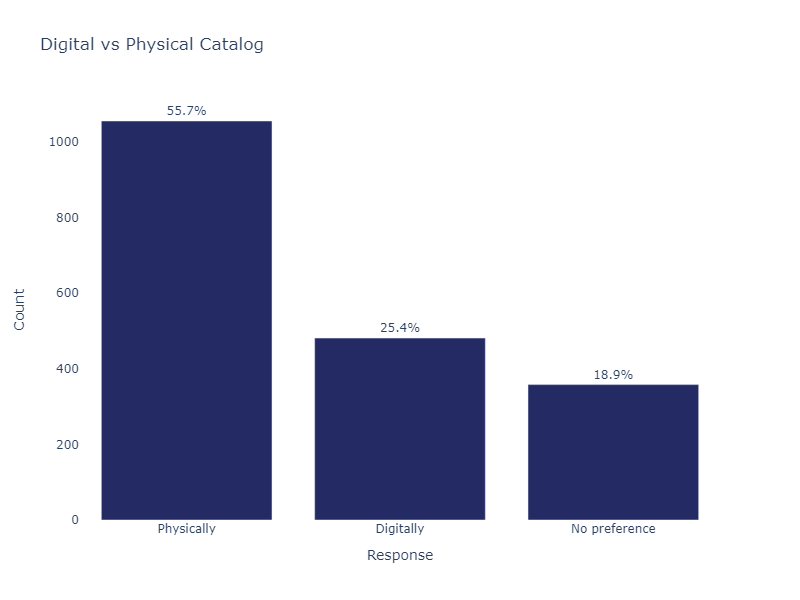

- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From 1894 responses)
    - "Physically" (56%)
    - "Digitally" (25%)
    - "No preference" (19%)


- Of the respondents, when asked if they would prefer a physical or digital catalog: (From 1894 responses.)
     - For the group 'Under 18', they responded as: **Digitally** at **50.0%**, and **No preference** at **50.0%**.
     - For the group '18-24', they responded as: **Physically** at **35.7%**, **No preference** at **35.7%**, and **Digitally** at **28.6%**.
     - For the group '25-34', they responded as: **Physically** at **48.8%**, **Digitally** at **29.8%**, and **No preference** at **21.5%**.
     - For the group '35-44', they responded as: **Physically** at **52.5%**, **Digitally** at **28.9%**, and **No preference** at **18.6%**.
     - For the group '45-54', they responded as: **Physically** at **55.4%**, **Digitally** at **25.4%**, and **No preference** at **19.2%**.
     - For the group '55-64', they responded as: **Physically** at **52.5%**, **Digitally** at **25.3%**, and **No preference** at **22.2%**.
     - For the group '65-74', they responded as: **Physically** at **59.4%**, **Digitally** at **23.8%**, and **No preference** at **16.9%**.
     - For the group '75 and older', they responded as: **Physically** at **62.4%**, **Digitally** at **22.5%**, and **No preference** at **15.0%**.

In [63]:
column_data = all_responses[all_responses.columns[62]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Digital vs Physical Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_type_preference.png")
display(Image(filename="./IMG/catalog_type_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[62], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they would prefer a physical or digital catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

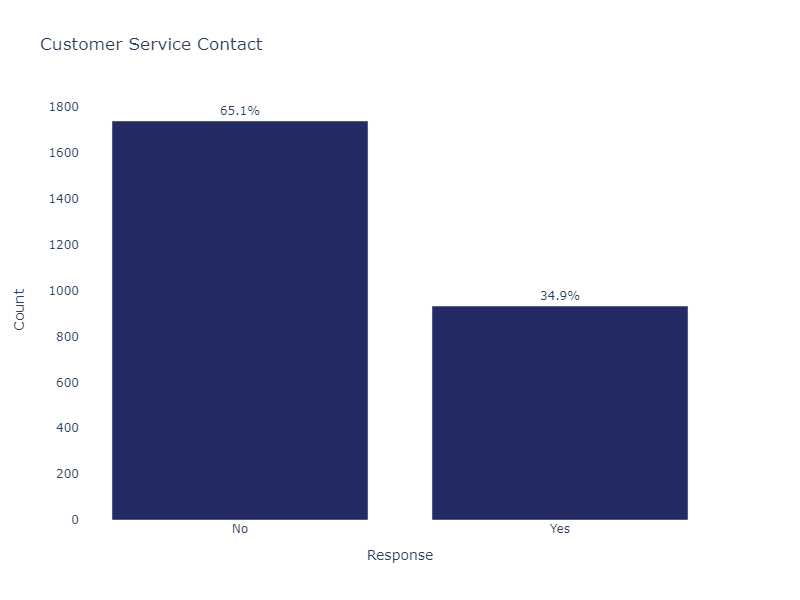

- Of the respondents, when asked if they have contacted customer service before:  (From 2673 responses)
    - "No" (65%)
    - "Yes" (35%)


In [64]:
column_data = all_responses[all_responses.columns[64]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Contact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service.png")
display(Image(filename="./IMG/customer_service.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have contacted customer service before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

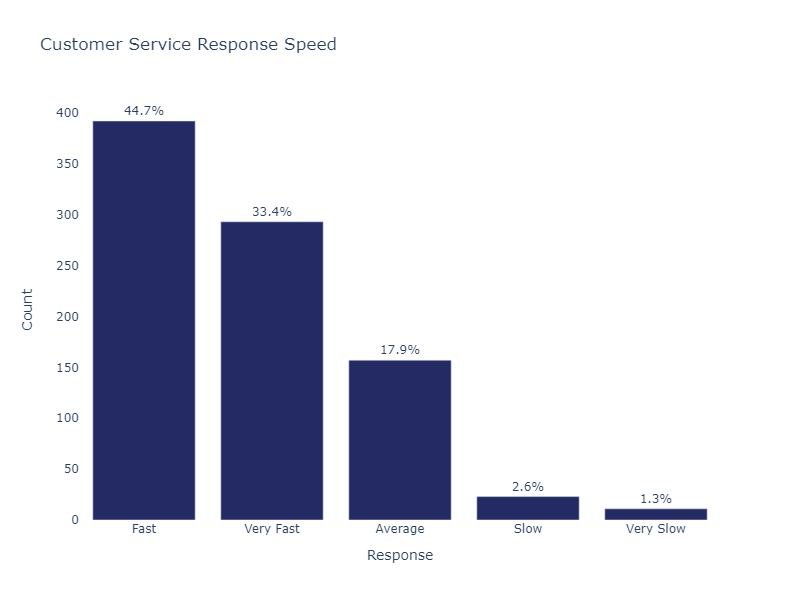

- Of the respondents, when asked about the response speed of our customer service:  (From 876 responses)
    - "Fast" (45%)
    - "Very Fast" (33%)
    - "Average" (18%)
    - "Slow" (3%)
    - "Very Slow" (1%)


In [65]:
column_data = all_responses[all_responses.columns[65]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Response Speed',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_speed.png")
display(Image(filename="./IMG/customer_service_speed.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the response speed of our customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

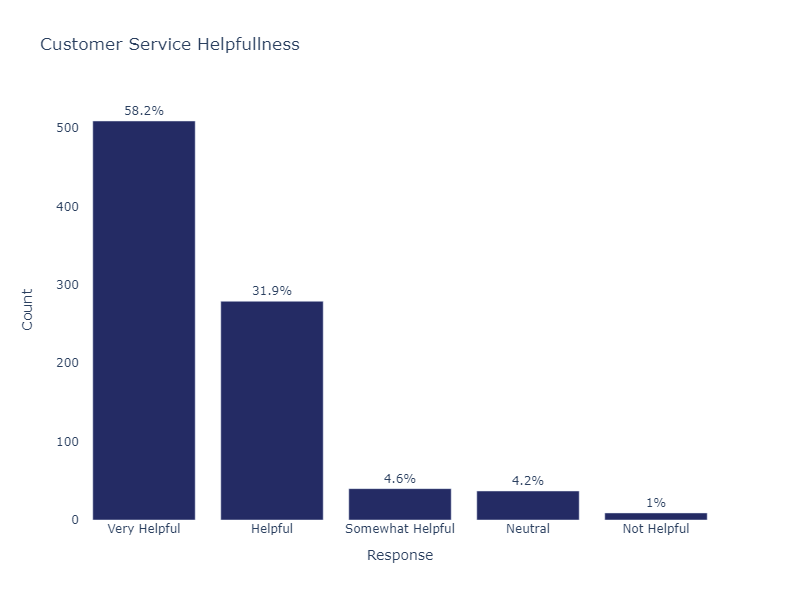

- Of the respondents, when asked how helpful our customer service is:  (From 874 responses)
    - "Very Helpful" (58%)
    - "Helpful" (32%)
    - "Somewhat Helpful" (5%)
    - "Neutral" (4%)
    - "Not Helpful" (1%)


In [66]:
column_data = all_responses[all_responses.columns[66]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Helpfullness',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how helpful our customer service is:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

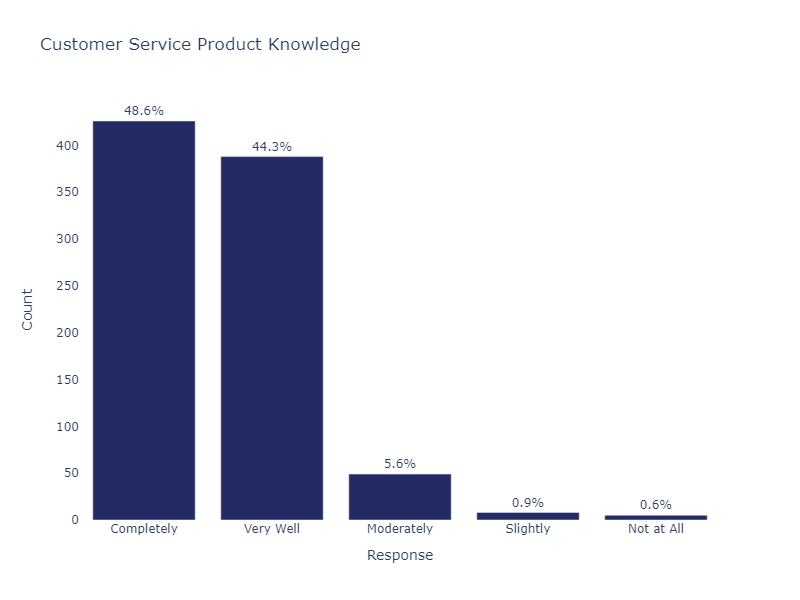

- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From 876 responses)
    - "Completely" (49%)
    - "Very Well" (44%)
    - "Moderately" (6%)
    - "Slightly" (1%)
    - "Not at All" (1%)


In [67]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Product Knowledge',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

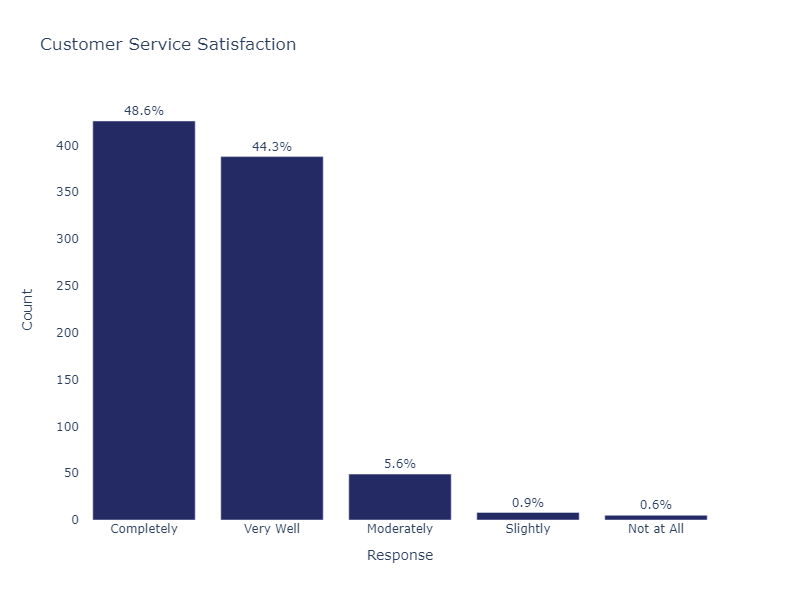

- Of the respondents, when asked how satisfied they were with out customer service:  (From 876 responses)
    - "Completely" (49%)
    - "Very Well" (44%)
    - "Moderately" (6%)
    - "Slightly" (1%)
    - "Not at All" (1%)


In [68]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Satisfaction',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_satisfaction.png")
display(Image(filename="./IMG/customer_service_satisfaction.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how satisfied they were with out customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

<div style="text-align: center;">

<h1>Crochet.com</h1>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    This section will focus on questions answered by Crochet.com respondents, and the questions unique to Crochet.com.
</div>

In [69]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')
# Filter rows where the value in the column at index 25 is 'Knit Picks'
all_responses = all_responses[all_responses.iloc[:, 25] == 'Crochet.com']

## Demographic Summary

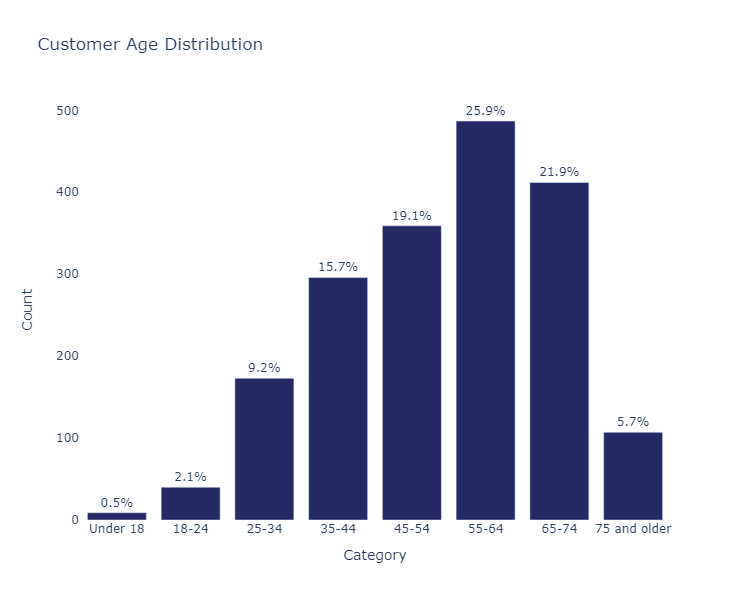

 - Out of **1883** respondants, the average respondant age is: **53** and the median age is: **59**.

- Of these respondants, they identify as:
    - "Woman" (97%)
    - "Non-Conforming / Non-Binary" (1%)
    - "Man" (1%)
    - "Transgender" (0%)


- The average household income is: **\$83,595** and the median household income is: **\$72,499** (From 1371 responses).
  - For ages **Under 18** the average household income is **\\$23,750**, the median household income is **\\$23,750**. (From 2 responses.)
  - For ages **18-24** the average household income is **\\$62,841**, the median household income is **\\$50,000**. (From 22 responses.)
  - For ages **25-34** the average household income is **\\$81,456**, the median household income is **\\$72,500**. (From 139 responses.)
  - For ages **35-44** the average household income is **\\$99,170**, the median household income is **\\$90,000**. (From 208 responses.)
  - For ages **45-54** the average household income is **\\$102,182**, the median household income is **\\$90,000**. (From 236 responses.)
  - For ages **55-64** the average household income is **\\$83,060**, the median household income is **\\$72,500**. (From 308 responses.)
  - For ages **65-74** the average household income is **\\$65,680**, the median household income is **\\$57,500**. (From 235 responses.)
  - For ages **75 and older** the average household income is **\\$62,664**, the median household income is **\\$57,500**. (From 76 responses.)


In [70]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=750,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondants, the average respondant age is: **{average_age}** and the median age is: **{median_age}**."))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = "- Of these respondants, they identify as:\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

### Income Section ###

# Income Question
question = all_responses.columns[80]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()

# Define the function to map income ranges to their midpoints
def map_income_to_midpoint(value):
    if value == 'Under $20,000':
        return 20000
    elif value == '$20,000 - $34,999':
        return (20000 + 34999) / 2
    elif value == '$35,000 - $49,999':
        return (35000 + 49999) / 2
    elif value == '$50,000 - $64,999':
        return (50000 + 64999) / 2
    elif value == '$65,000 - $79,999':
        return (65000 + 79999) / 2
    elif value == '$80,000 - $99,999':
        return (80000 + 99999) / 2
    elif value == '$100,000 - $124,999':
        return (100000 + 124999) / 2
    elif value == '$125,000 - $149,999':
        return (125000 + 149999) / 2
    elif value == '$150,000 - $174,999':
        return (150000 + 174999) / 2
    elif value == '$175,000 - $199,999':
        return (175000 + 199999) / 2
    elif value == 'Over $200,000':
        return 200000
    else:
        return np.nan

# Apply the function to the column data
income_data = column_data.map(map_income_to_midpoint)
# Calculate the average income
average_income = income_data.mean().astype(int)
# Calculate the median income
median_income = income_data.median().astype(int)
# Total count of responses
total_responses = income_data.dropna().count()
# Format the average and median income for readability with $ and commas
formatted_average_income = "\${:,.0f}".format(average_income)
formatted_median_income = "\${:,.0f}".format(median_income)

## Break down by age group. ##

age_question = all_responses.columns[75]

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[age_question] != 'Prefer not to answer') & 
                                        (all_responses[question] != 'Prefer not to answer')]

# Apply categorization and mapping for income midpoint again if necessary
filtered_responses['income_midpoint'] = filtered_responses[question].map(map_income_to_midpoint)
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Now group by the 'age_range' with the specified order
statistics = filtered_responses.groupby('age_range', observed=True)['income_midpoint'].agg(['mean', 'median', 'count']).dropna()

# First part of the markdown about average and median income
markdown_part1 = f"- The average household income is: **{formatted_average_income}** and the median household income is: **{formatted_median_income}** (From {total_responses} responses)."

# Generating the second part with the breakdown by age group
markdown_part2 = ""
for age, row in statistics.iterrows():
    avg_income = "\${:,.0f}".format(row['mean'])
    median_income = "\${:,.0f}".format(row['median'])
    responses = row['count'].astype(int)
    markdown_part2 += f"  - For ages **{age}** the average household income is **\{avg_income}**, the median household income is **\{median_income}**. (From {responses} responses.)\n"

# Combine the two parts into a single Markdown display, with the second part indented as a sub-list
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

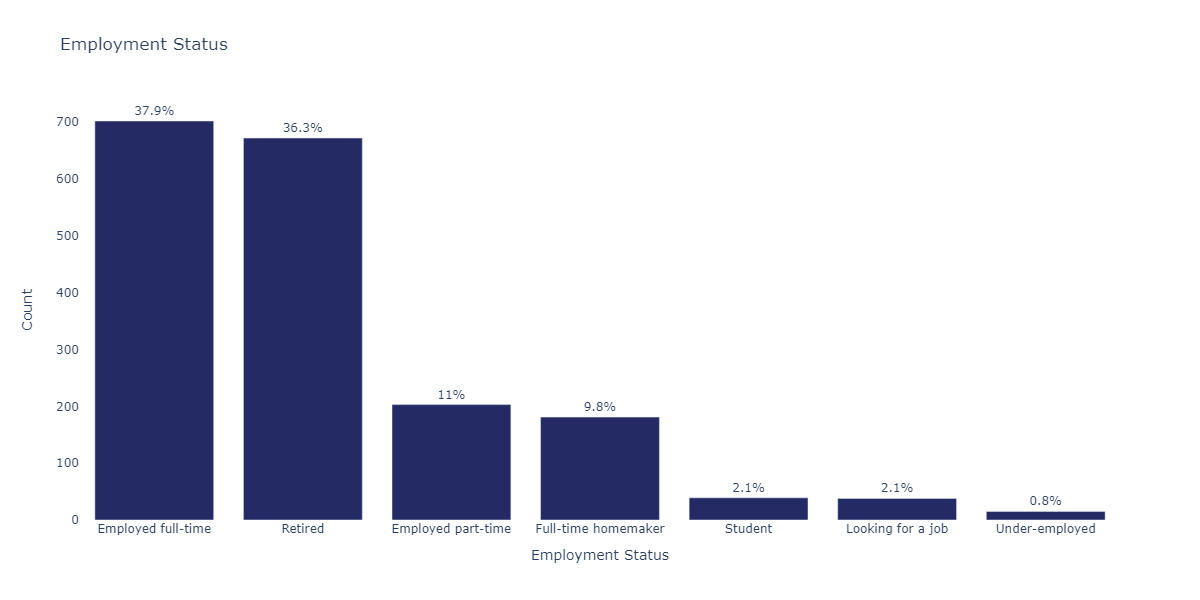

- Of the respondents, their employment statuses are as follows:  (From 1850 responses)
    - "Employed full-time" (38%)
    - "Retired" (36%)
    - "Employed part-time" (11%)
    - "Full-time homemaker" (10%)
    - "Student" (2%)
    - "Looking for a job" (2%)
    - "Under-employed" (1%)


In [71]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

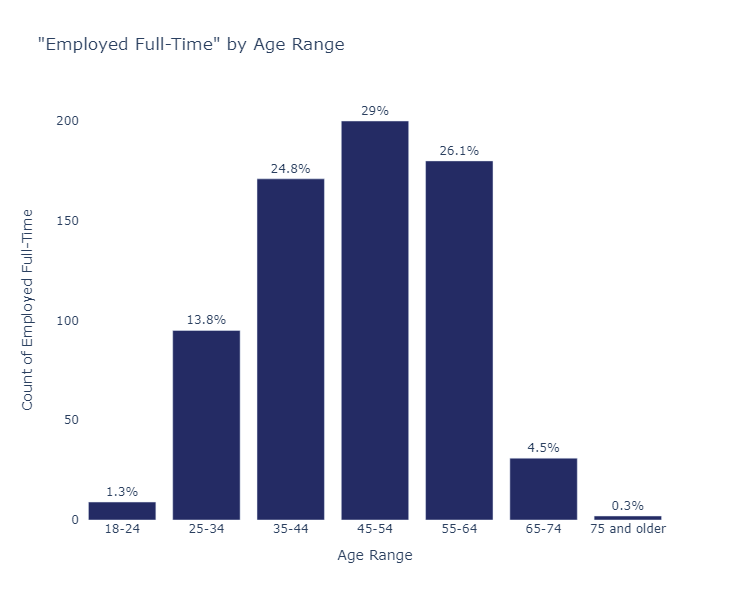

- Of those who responded 'Employed Full-Time': (From 702 responses.)
    - "45-54" (29.0%)
    - "55-64" (26.1%)
    - "35-44" (24.8%)
    - "25-34" (13.8%)
    - "65-74" (4.5%)
    - "18-24" (1.3%)
    - "75 and older" (0.3%)


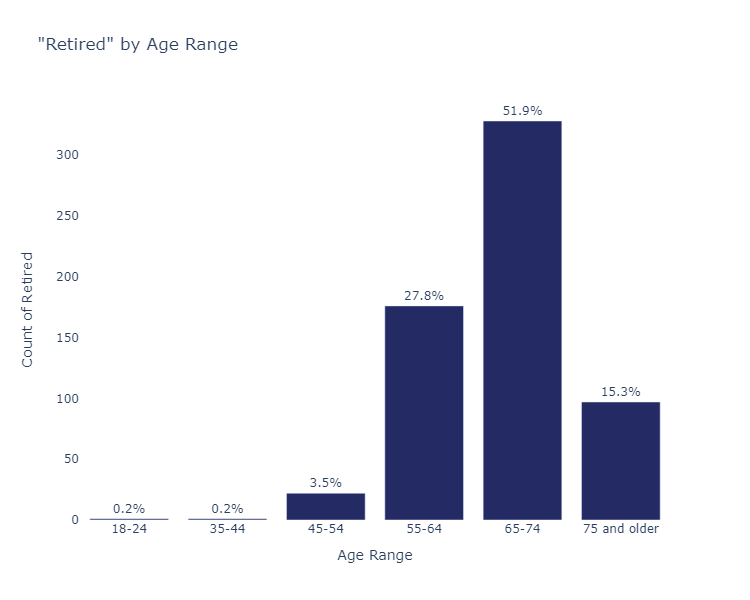

- Of those who responded 'Retired': (From 672 responses.)
    - "65-74" (51.9%)
    - "55-64" (27.8%)
    - "75 and older" (15.3%)
    - "45-54" (3.5%)
    - "18-24" (0.2%)
    - "35-44" (0.2%)


In [72]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))


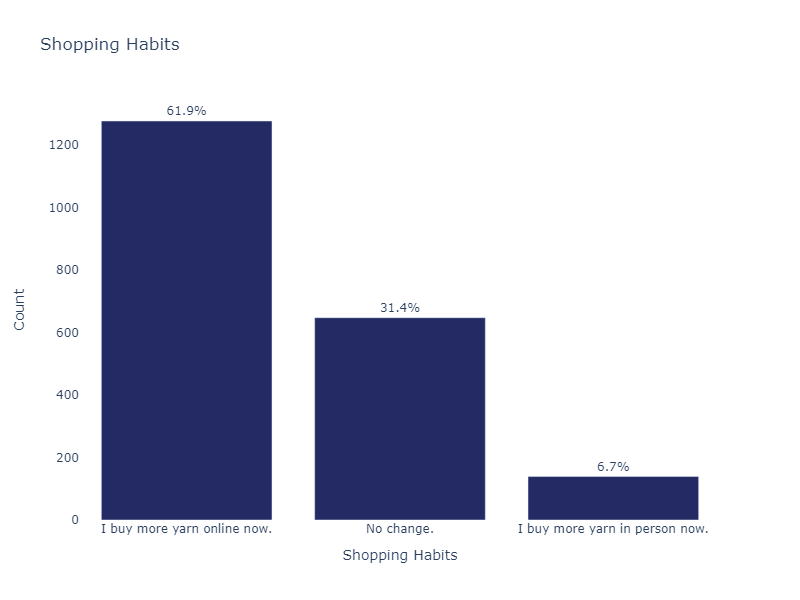

- Of the respondents, they reported that their shopping habbits have changed:  (From 2062 responses)
    - "I buy more yarn online now." (62%)
    - "No change." (31%)
    - "I buy more yarn in person now." (7%)


In [73]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

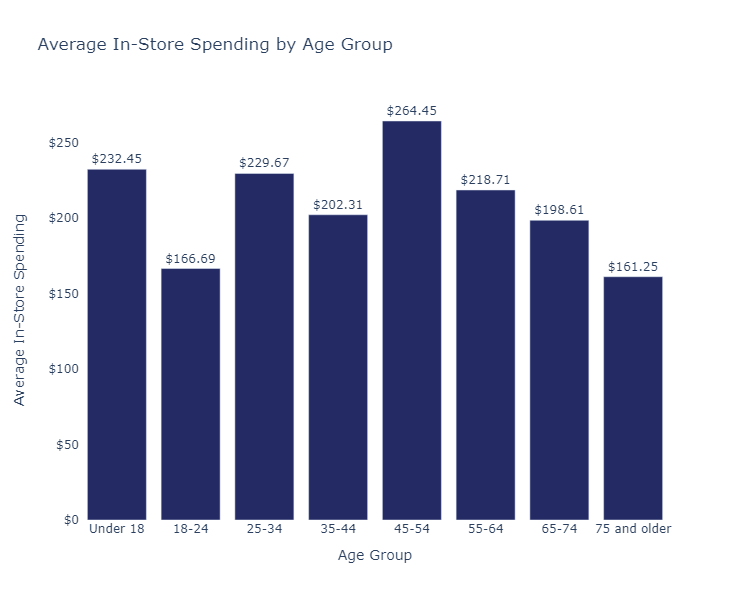

- Respondents reported making **5.0** purchases in-store per year on average, spending an average **\$42.56** per visit. On average spending **\$213.01** a year. (From 1953 responses.)
     - For the group 'Under 18', respondents reported making **4.9** purchases in-store per year on average, spending an average **\$47.86** per visit. On average spending **\$232.45** a year.
     - For the group '18-24', respondents reported making **5.3** purchases in-store per year on average, spending an average **\$31.45** per visit. On average spending **\$166.69** a year.
     - For the group '25-34', respondents reported making **5.0** purchases in-store per year on average, spending an average **\$45.93** per visit. On average spending **\$229.67** a year.
     - For the group '35-44', respondents reported making **4.6** purchases in-store per year on average, spending an average **\$44.42** per visit. On average spending **\$202.31** a year.
     - For the group '45-54', respondents reported making **5.7** purchases in-store per year on average, spending an average **\$46.33** per visit. On average spending **\$264.45** a year.
     - For the group '55-64', respondents reported making **5.2** purchases in-store per year on average, spending an average **\$42.32** per visit. On average spending **\$218.71** a year.
     - For the group '65-74', respondents reported making **4.9** purchases in-store per year on average, spending an average **\$40.60** per visit. On average spending **\$198.61** a year.
     - For the group '75 and older', respondents reported making **4.3** purchases in-store per year on average, spending an average **\$37.33** per visit. On average spending **\$161.25** a year.

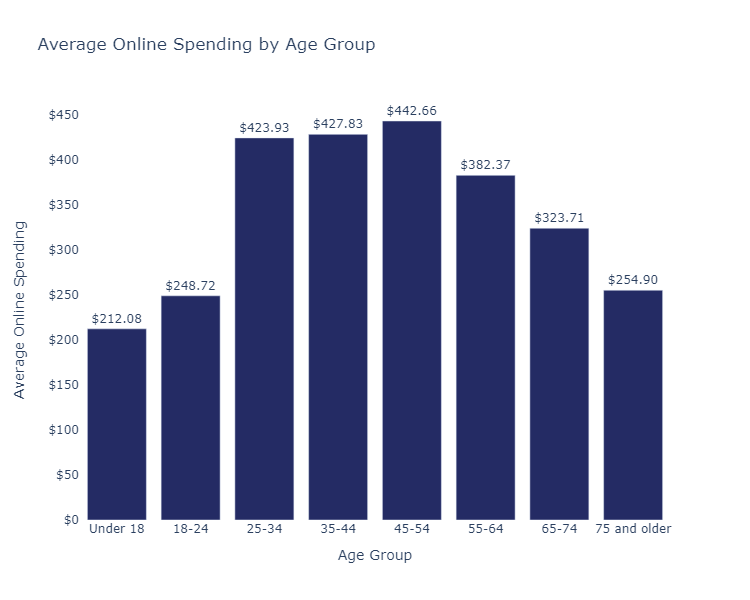

- Respondents reported making **5.7** purchases online per year on average, spending an average **\$65.87** per visit. On average spending **\$374.12** a year. (From 1977 responses.)
     - For the group 'Under 18', respondents reported making **3.4** purchases in-store per year on average, spending an average **\$61.86** per visit. On average spending **\$212.08** a year.
     - For the group '18-24', respondents reported making **5.2** purchases in-store per year on average, spending an average **\$47.38** per visit. On average spending **\$248.72** a year.
     - For the group '25-34', respondents reported making **5.8** purchases in-store per year on average, spending an average **\$73.23** per visit. On average spending **\$423.93** a year.
     - For the group '35-44', respondents reported making **5.7** purchases in-store per year on average, spending an average **\$74.55** per visit. On average spending **\$427.83** a year.
     - For the group '45-54', respondents reported making **6.2** purchases in-store per year on average, spending an average **\$71.97** per visit. On average spending **\$442.66** a year.
     - For the group '55-64', respondents reported making **5.9** purchases in-store per year on average, spending an average **\$65.07** per visit. On average spending **\$382.37** a year.
     - For the group '65-74', respondents reported making **5.6** purchases in-store per year on average, spending an average **\$58.19** per visit. On average spending **\$323.71** a year.
     - For the group '75 and older', respondents reported making **4.9** purchases in-store per year on average, spending an average **\$52.49** per visit. On average spending **\$254.90** a year.

In [74]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100),
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For the group '{group}', respondents reported making **{group_avg_purchases_online:.1f}** purchases in-store per year on average, spending an average **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

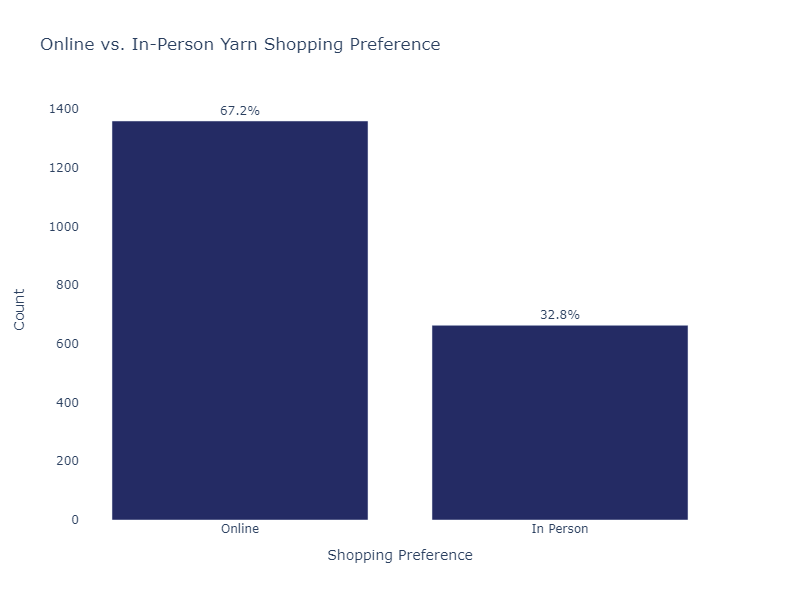

- Of the respondants **62.9%** preferred online shopping for yarn, while **30.68%** preferred shopping in person for yarn. (From 2022 responses.)
     - For the group 'Under 18', **22.2%** preferred shopping online, **77.8%** preferred shopping in person.
     - For the group '18-24', **62.5%** preferred shopping online, **37.5%** preferred shopping in person.
     - For the group '25-34', **71.7%** preferred shopping online, **26.6%** preferred shopping in person.
     - For the group '35-44', **74.7%** preferred shopping online, **24.0%** preferred shopping in person.
     - For the group '45-54', **66.0%** preferred shopping online, **30.4%** preferred shopping in person.
     - For the group '55-64', **64.5%** preferred shopping online, **33.5%** preferred shopping in person.
     - For the group '65-74', **59.7%** preferred shopping online, **36.2%** preferred shopping in person.
     - For the group '75 and older', **59.8%** preferred shopping online, **36.4%** preferred shopping in person.

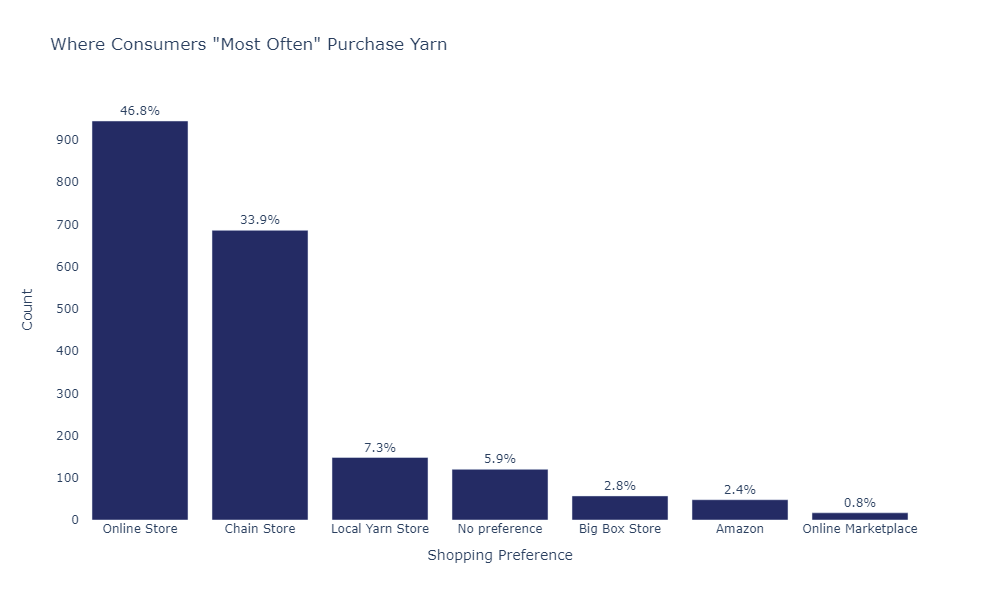

In [75]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

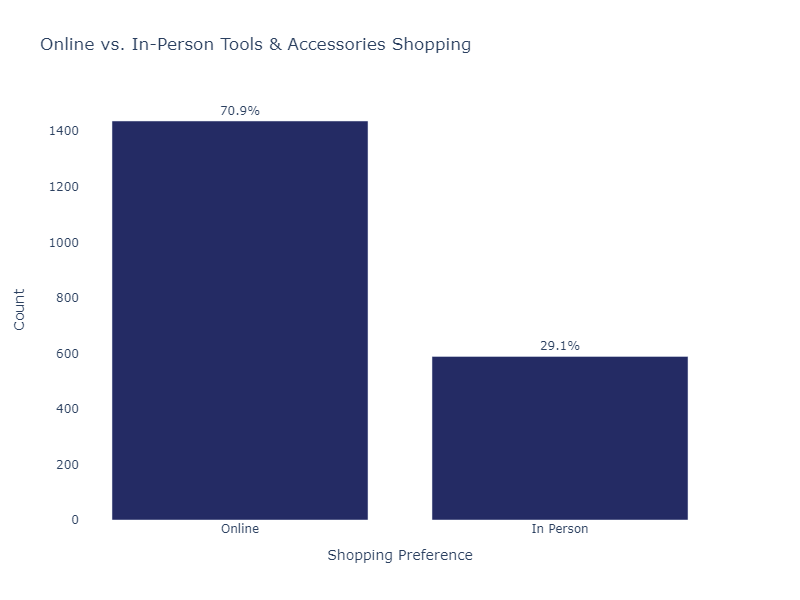

- Of the respondants **66.5%** preferred online shopping for tools & accessories, while **27.26%** preferred shopping in person for tools & accessories. (From 2026 responses.)
     - For the group 'Under 18', **44.4%** preferred shopping online, **55.6%** preferred shopping in person.
     - For the group '18-24', **67.5%** preferred shopping online, **32.5%** preferred shopping in person.
     - For the group '25-34', **71.7%** preferred shopping online, **26.6%** preferred shopping in person.
     - For the group '35-44', **80.1%** preferred shopping online, **18.9%** preferred shopping in person.
     - For the group '45-54', **72.1%** preferred shopping online, **25.3%** preferred shopping in person.
     - For the group '55-64', **68.8%** preferred shopping online, **28.7%** preferred shopping in person.
     - For the group '65-74', **65.5%** preferred shopping online, **31.3%** preferred shopping in person.
     - For the group '75 and older', **60.7%** preferred shopping online, **35.5%** preferred shopping in person.

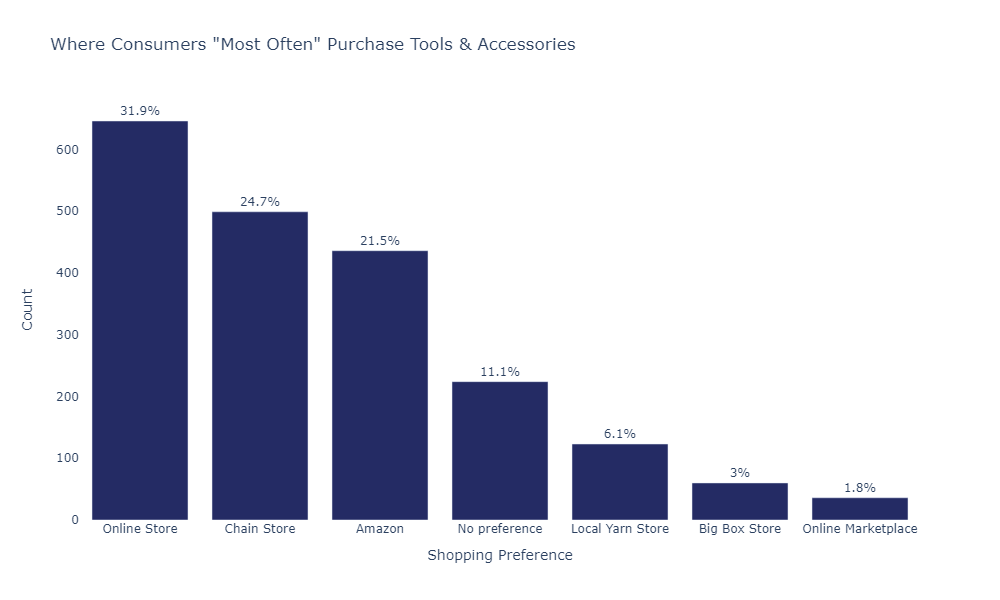

In [76]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

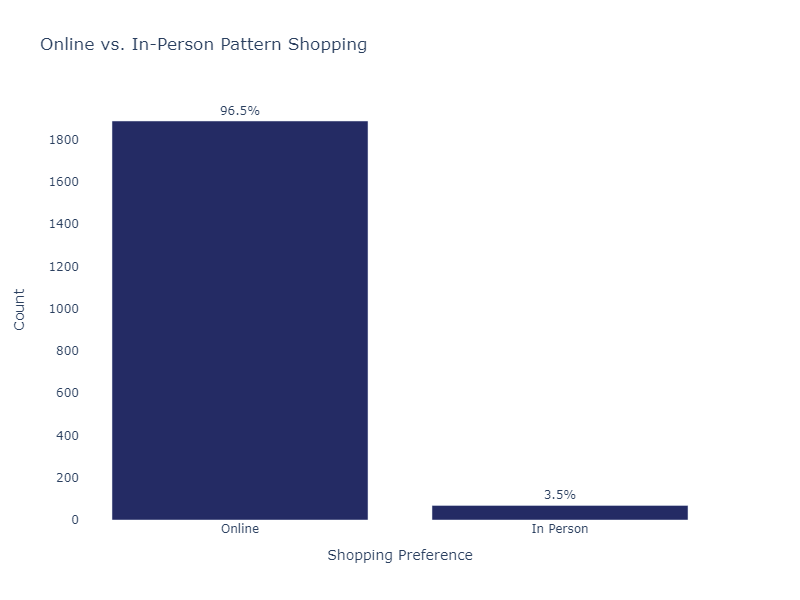

- Of the respondants **87.4%** preferred online shopping for patterns, while **3.19%** preferred shopping in person for patterns. (From 1958 responses.)
     - For the group 'Under 18', **66.7%** preferred shopping online, **11.1%** preferred shopping in person.
     - For the group '18-24', **92.5%** preferred shopping online, **0.0%** preferred shopping in person.
     - For the group '25-34', **96.0%** preferred shopping online, **0.6%** preferred shopping in person.
     - For the group '35-44', **96.3%** preferred shopping online, **1.7%** preferred shopping in person.
     - For the group '45-54', **95.3%** preferred shopping online, **1.4%** preferred shopping in person.
     - For the group '55-64', **91.4%** preferred shopping online, **2.3%** preferred shopping in person.
     - For the group '65-74', **85.4%** preferred shopping online, **7.0%** preferred shopping in person.
     - For the group '75 and older', **85.0%** preferred shopping online, **6.5%** preferred shopping in person.

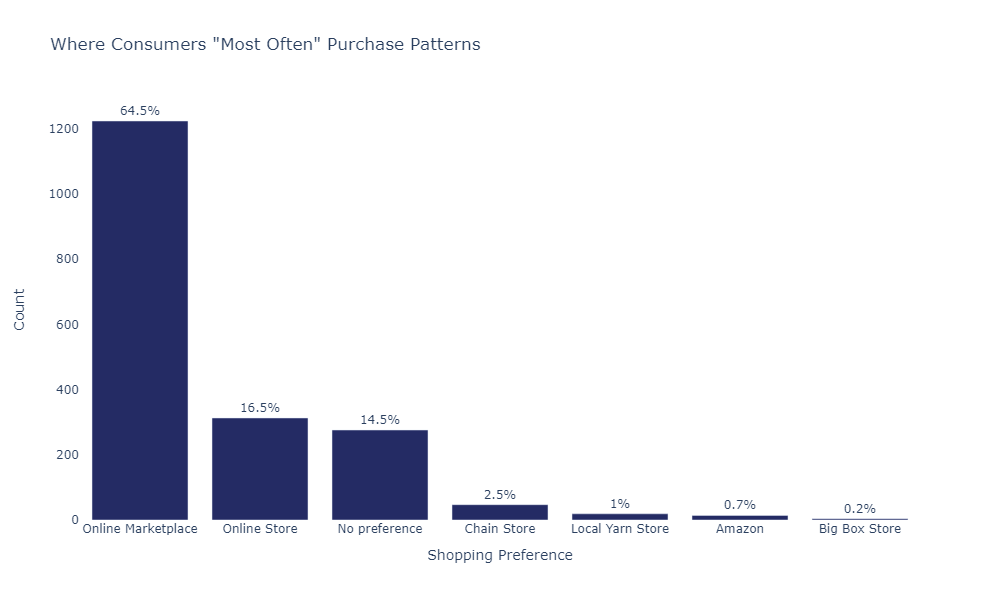

In [77]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondants **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

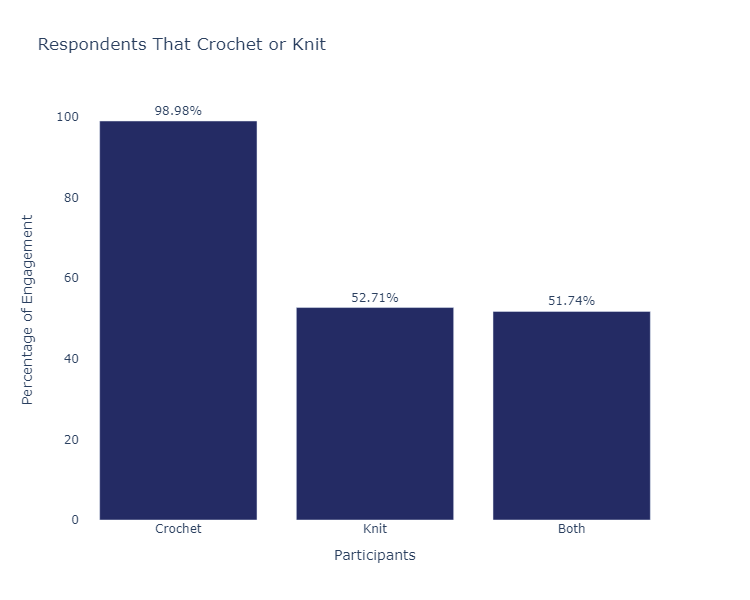

- Of the respondants, **99.0%** responded 'Yes' to crocheting, **52.71%** responded 'Yes' to knitting, while **51.74%** of respondants engage in both. (From 2161 responses.)
     - For the group 'Under 18', **100.0%** responded 'Yes' to crocheting, **44.4%** responded 'Yes' to knitting, and **44.4%** to both.
     - For the group '18-24', **100.0%** responded 'Yes' to crocheting, **50.0%** responded 'Yes' to knitting, and **50.0%** to both.
     - For the group '25-34', **98.3%** responded 'Yes' to crocheting, **51.4%** responded 'Yes' to knitting, and **49.7%** to both.
     - For the group '35-44', **98.3%** responded 'Yes' to crocheting, **54.4%** responded 'Yes' to knitting, and **52.7%** to both.
     - For the group '45-54', **98.6%** responded 'Yes' to crocheting, **51.8%** responded 'Yes' to knitting, and **50.4%** to both.
     - For the group '55-64', **99.2%** responded 'Yes' to crocheting, **47.2%** responded 'Yes' to knitting, and **46.4%** to both.
     - For the group '65-74', **99.0%** responded 'Yes' to crocheting, **58.3%** responded 'Yes' to knitting, and **57.5%** to both.
     - For the group '75 and older', **100.0%** responded 'Yes' to crocheting, **69.2%** responded 'Yes' to knitting, and **69.2%** to both.

In [78]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondants, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondants engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.1f}%** responded 'Yes' to knitting, and **{both_yes_percent:.1f}%** to both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

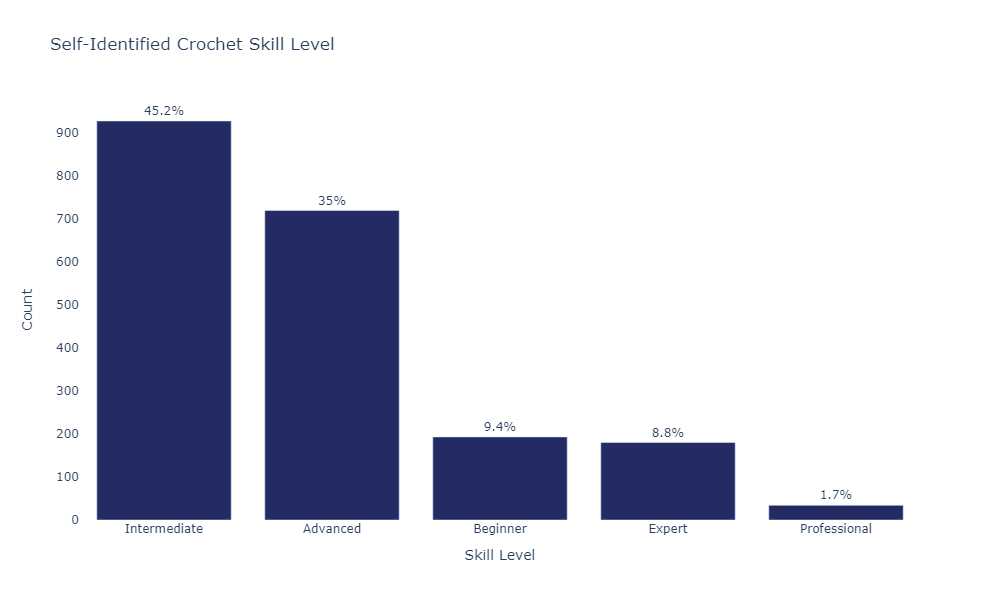

- Of the respondants who crochet, they rate their skill level as the following: (From 2139 responses.)
    - **45.15%** of respondents answered 'Intermediate'.
    - **35.02%** of respondents answered 'Advanced'.
    - **9.40%** of respondents answered 'Beginner'.
    - **8.77%** of respondents answered 'Expert'.
    - **1.66%** of respondents answered 'Professional'.


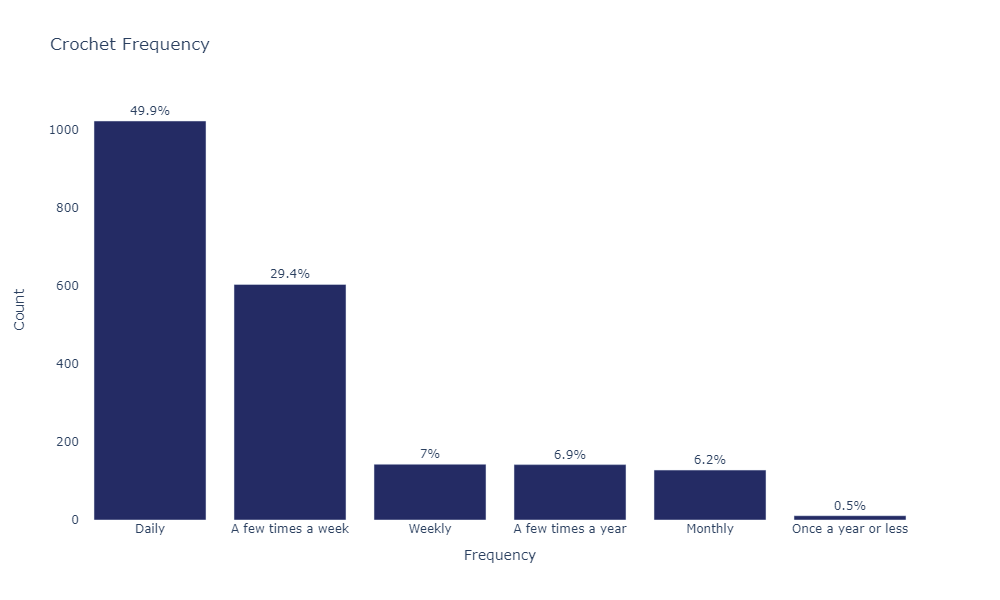

- Of the respondants who crochet, the frequency they do so is: (From 2139 responses.)
    - **49.88%** of respondents answered 'Daily'.
    - **29.45%** of respondents answered 'A few times a week'.
    - **6.97%** of respondents answered 'Weekly'.
    - **6.92%** of respondents answered 'A few times a year'.
    - **6.24%** of respondents answered 'Monthly'.
    - **0.54%** of respondents answered 'Once a year or less'.


In [79]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



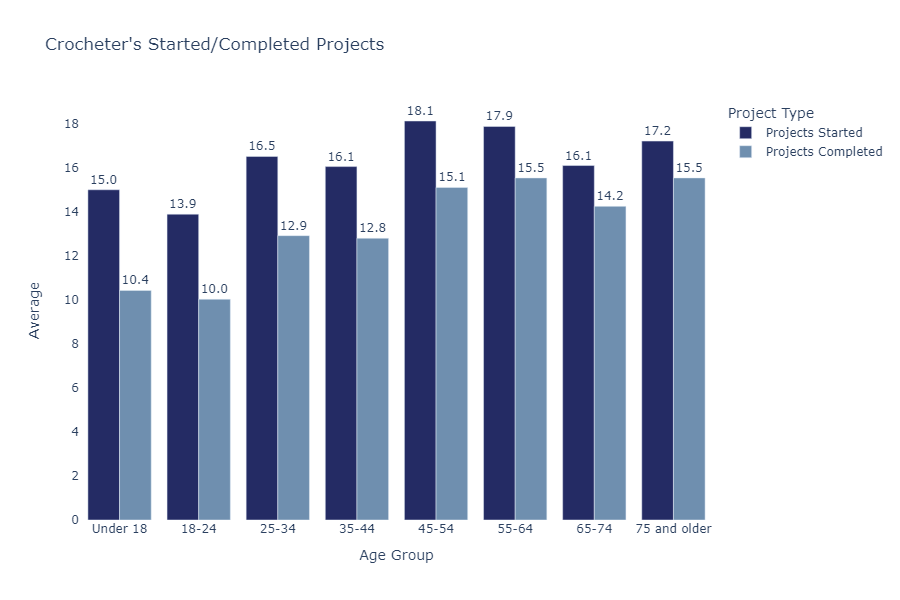

- Of the respondants, on average they start **17.0** crochet projects a year, and on average they complete **14.4** crochet projects a year. (From 2139 responses.)
     - For the group 'Under 18', they start **15.0** crochet projects a year, and on average they complete **10.4** crochet projects a year.
     - For the group '18-24', they start **13.9** crochet projects a year, and on average they complete **10.0** crochet projects a year.
     - For the group '25-34', they start **16.5** crochet projects a year, and on average they complete **12.9** crochet projects a year.
     - For the group '35-44', they start **16.1** crochet projects a year, and on average they complete **12.8** crochet projects a year.
     - For the group '45-54', they start **18.1** crochet projects a year, and on average they complete **15.1** crochet projects a year.
     - For the group '55-64', they start **17.9** crochet projects a year, and on average they complete **15.5** crochet projects a year.
     - For the group '65-74', they start **16.1** crochet projects a year, and on average they complete **14.2** crochet projects a year.
     - For the group '75 and older', they start **17.2** crochet projects a year, and on average they complete **15.5** crochet projects a year.

In [80]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondants, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

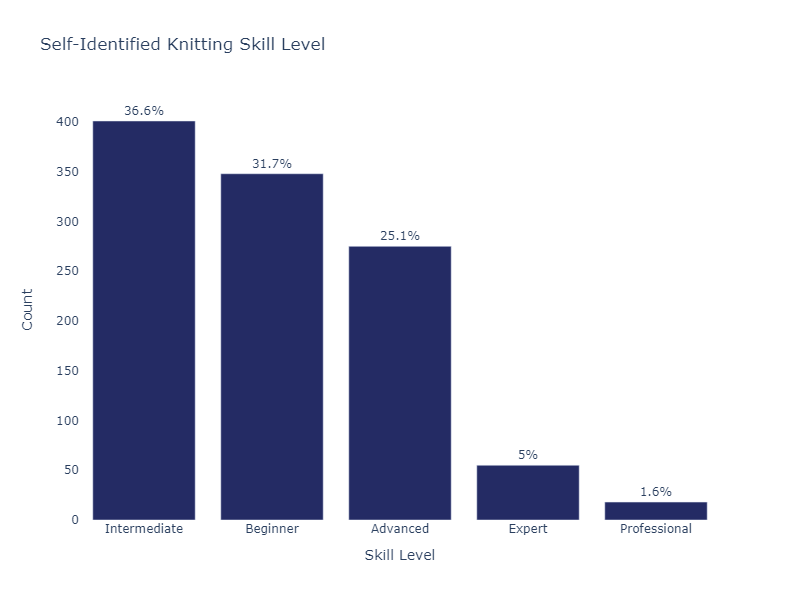

- Of the respondants who knit, they rate their skill level as the following: (From 1139 responses.)
    - **36.55%** of respondents answered 'Intermediate'.
    - **31.72%** of respondents answered 'Beginner'.
    - **25.07%** of respondents answered 'Advanced'.
    - **5.01%** of respondents answered 'Expert'.
    - **1.64%** of respondents answered 'Professional'.


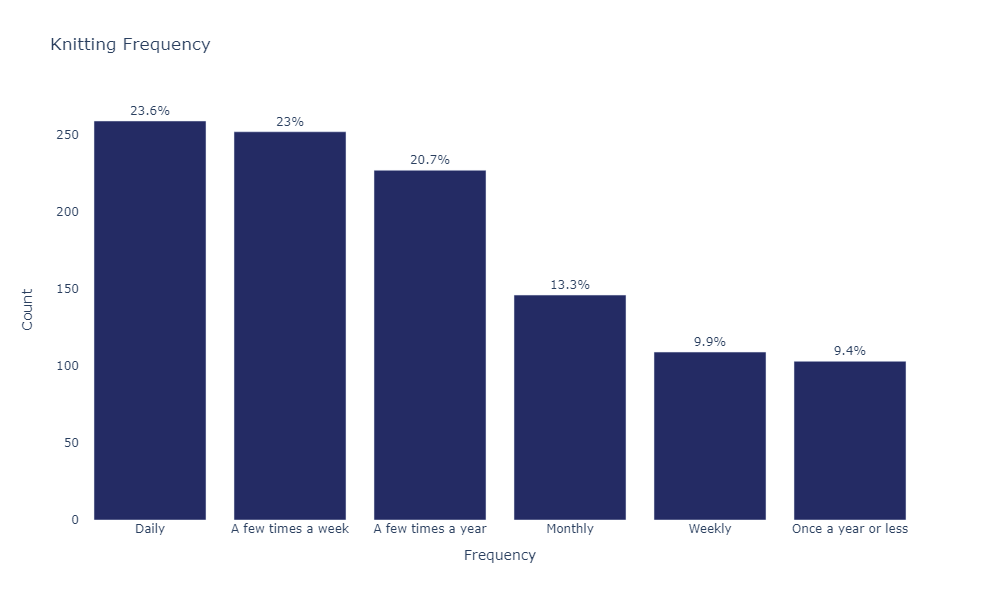

- Of the respondants who knit, the frequency they do so is: (From 1139 responses.)
    - **23.63%** of respondents answered 'Daily'.
    - **22.99%** of respondents answered 'A few times a week'.
    - **20.71%** of respondents answered 'A few times a year'.
    - **13.32%** of respondents answered 'Monthly'.
    - **9.95%** of respondents answered 'Weekly'.
    - **9.40%** of respondents answered 'Once a year or less'.


In [81]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondants who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - **{percentage:.2f}%** of respondents answered '{answer}'.\n"
    
display(Markdown(markdown_summary))



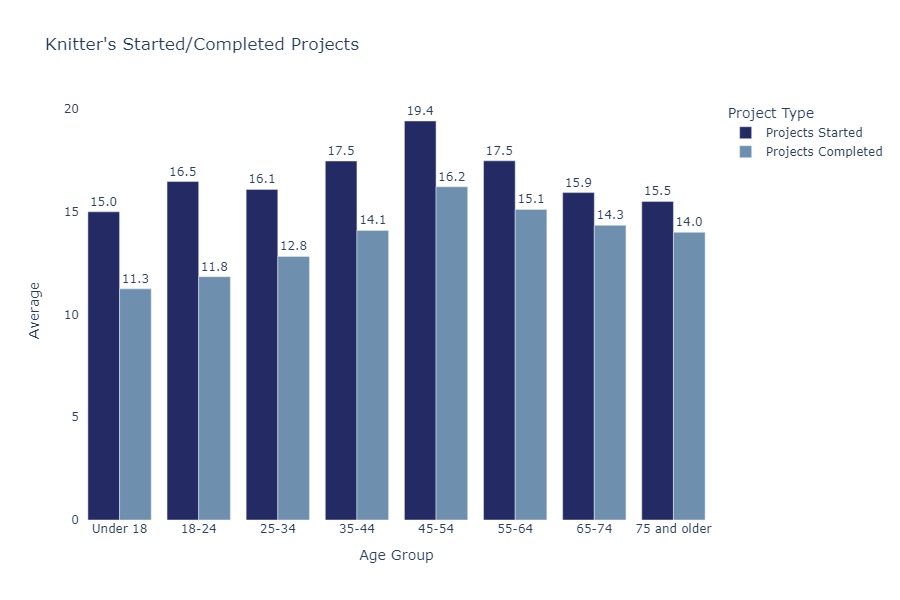

- Of the respondants, on average they start **17.2** knitting projects a year, and on average they complete **14.6** knitting projects a year. (From 1139 responses.)
     - For the group 'Under 18', they start **15.0** knitting projects a year, and on average they complete **11.2** knitting projects a year.
     - For the group '18-24', they start **16.5** knitting projects a year, and on average they complete **11.8** knitting projects a year.
     - For the group '25-34', they start **16.1** knitting projects a year, and on average they complete **12.8** knitting projects a year.
     - For the group '35-44', they start **17.5** knitting projects a year, and on average they complete **14.1** knitting projects a year.
     - For the group '45-54', they start **19.4** knitting projects a year, and on average they complete **16.2** knitting projects a year.
     - For the group '55-64', they start **17.5** knitting projects a year, and on average they complete **15.1** knitting projects a year.
     - For the group '65-74', they start **15.9** knitting projects a year, and on average they complete **14.3** knitting projects a year.
     - For the group '75 and older', they start **15.5** knitting projects a year, and on average they complete **14.0** knitting projects a year.

In [82]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondants, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For the group '{age}', they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

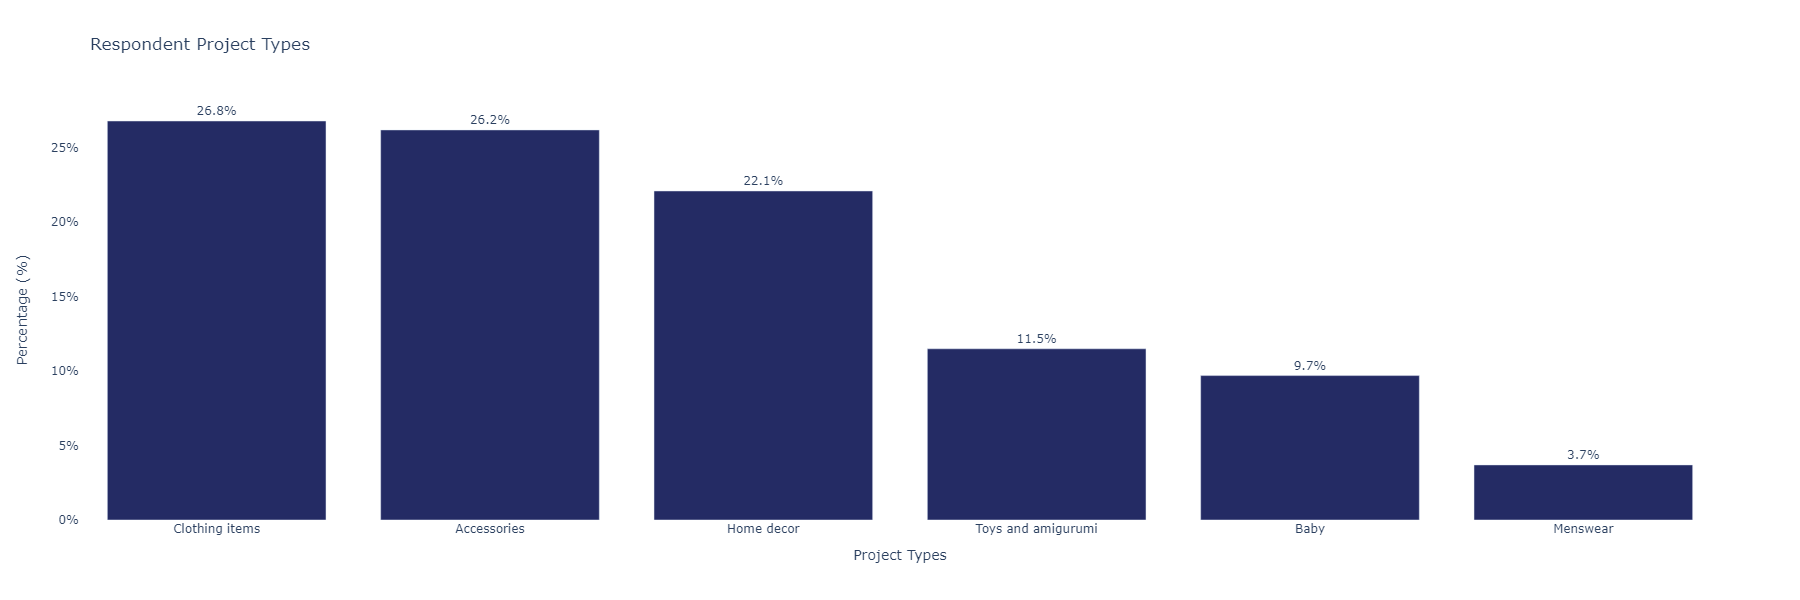

- Of the respondents, the most popular project type for all yarn crafts is: (From 1139 responses.)
     - For the group 'Under 18', the most popular project type is **Clothing items** at **47.1%**, **Toys and amigurumi** at **23.5%**, and **Accessories** at **23.5%**.
     - For the group '18-24', the most popular project type is **Clothing items** at **34.9%**, **Accessories** at **19.3%**, and **Toys and amigurumi** at **18.1%**.
     - For the group '25-34', the most popular project type is **Clothing items** at **29.5%**, **Accessories** at **23.9%**, and **Home decor** at **20.2%**.
     - For the group '35-44', the most popular project type is **Clothing items** at **28.1%**, **Accessories** at **26.1%**, and **Home decor** at **19.6%**.
     - For the group '45-54', the most popular project type is **Clothing items** at **28.2%**, **Accessories** at **25.4%**, and **Home decor** at **22.0%**.
     - For the group '55-64', the most popular project type is **Accessories** at **26.7%**, **Clothing items** at **25.2%**, and **Home decor** at **25.1%**.
     - For the group '65-74', the most popular project type is **Accessories** at **27.3%**, **Clothing items** at **24.9%**, and **Home decor** at **22.5%**.
     - For the group '75 and older', the most popular project type is **Accessories** at **27.7%**, **Clothing items** at **25.1%**, and **Home decor** at **20.3%**.

In [83]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check if there are at least two project types to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular project types
            markdown_summary += f"\n     - For the group '{age}', the most popular project type is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**, and **{percentages.iloc[2, 0]}** at **{percentages.iloc[2, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular project type is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

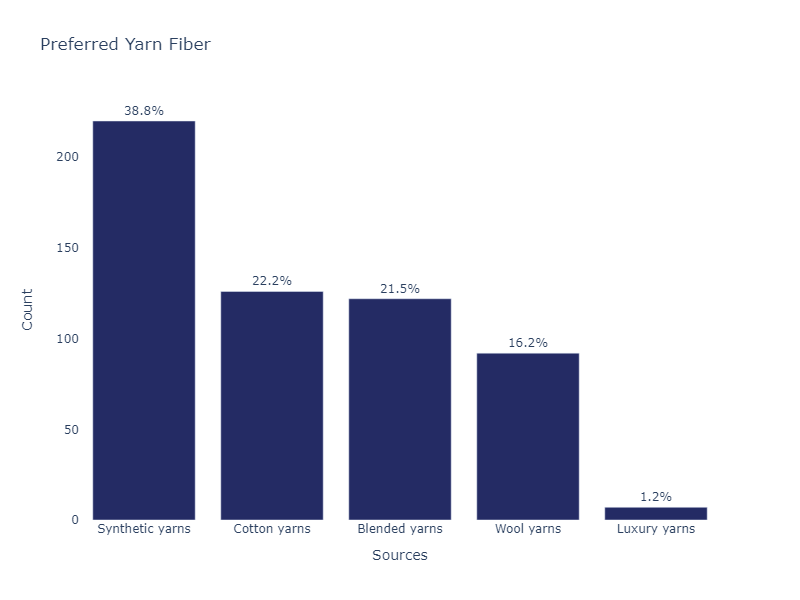

- Of the respondants, the most popular yarn fiber is: (From 567 responses.)
     - For the group 'Under 18', the most popular yarn fiber is **Cotton yarns** at **100.0%**.
     - For the group '18-24', the most popular yarn fiber is **Synthetic yarns** at **70.0%**, followed by **Cotton yarns** at **20.0%**.
     - For the group '25-34', the most popular yarn fiber is **Synthetic yarns** at **37.0%**, followed by **Cotton yarns** at **23.9%**.
     - For the group '35-44', the most popular yarn fiber is **Synthetic yarns** at **29.9%**, followed by **Wool yarns** at **26.9%**.
     - For the group '45-54', the most popular yarn fiber is **Blended yarns** at **26.8%**, followed by **Cotton yarns** at **26.8%**.
     - For the group '55-64', the most popular yarn fiber is **Synthetic yarns** at **40.8%**, followed by **Cotton yarns** at **24.3%**.
     - For the group '65-74', the most popular yarn fiber is **Synthetic yarns** at **38.6%**, followed by **Blended yarns** at **27.6%**.
     - For the group '75 and older', the most popular yarn fiber is **Synthetic yarns** at **51.3%**, followed by **Blended yarns** at **20.5%**.

In [84]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular yarn fiber is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular yarn fiber is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

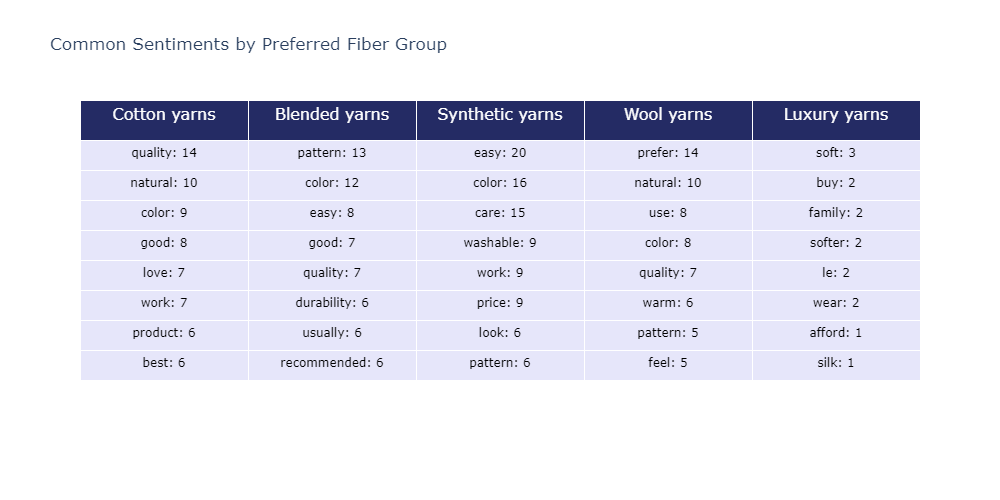

In [85]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine',
    'want'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Use lemmatization instead of stemming
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))

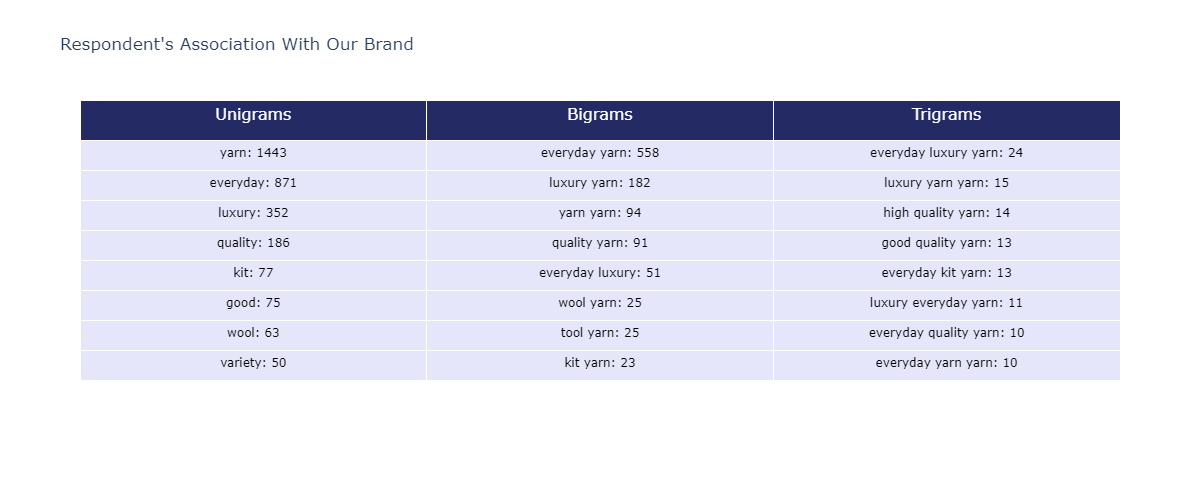

In [86]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[39]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'like',
    'dont know',
    'every',
    'day'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(8)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)


# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Respondent\'s Association With Our Brand',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200
)

fig.update_traces(columnwidth=[15, 15, 15])

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

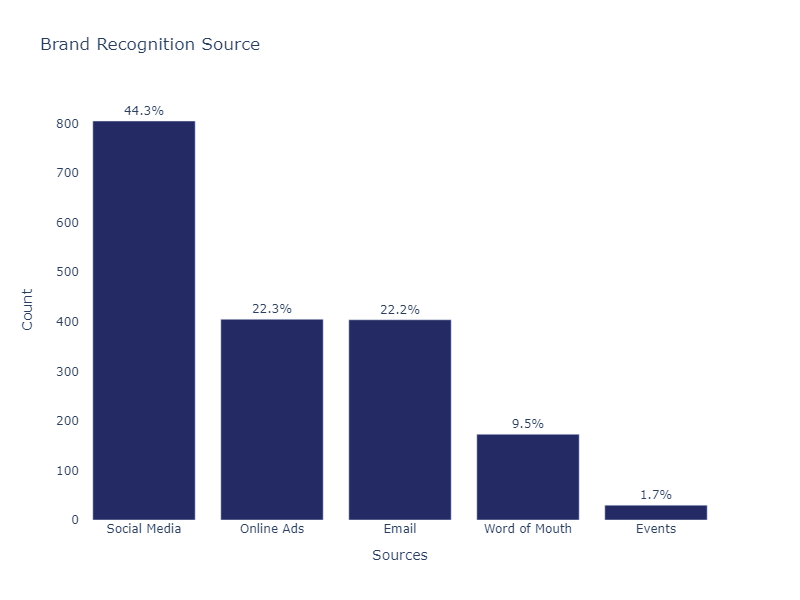

- Of the respondants, the most popular brand discovery source is: (From 2042 responses.)
     - For the group 'Under 18', the most popular discovery source is **Social Media** at **42.9%**, followed by **Email** at **28.6%**.
     - For the group '18-24', the most popular discovery source is **Social Media** at **36.4%**, followed by **Email** at **30.3%**.
     - For the group '25-34', the most popular discovery source is **Social Media** at **49.0%**, followed by **Online Ads** at **23.2%**.
     - For the group '35-44', the most popular discovery source is **Social Media** at **52.9%**, followed by **Online Ads** at **16.7%**.
     - For the group '45-54', the most popular discovery source is **Social Media** at **51.6%**, followed by **Online Ads** at **24.4%**.
     - For the group '55-64', the most popular discovery source is **Social Media** at **46.5%**, followed by **Email** at **22.6%**.
     - For the group '65-74', the most popular discovery source is **Social Media** at **37.2%**, followed by **Email** at **30.9%**.
     - For the group '75 and older', the most popular discovery source is **Email** at **39.2%**, followed by **Online Ads** at **27.5%**.

In [87]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular brand discovery source is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular discovery source is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular  discovery source is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

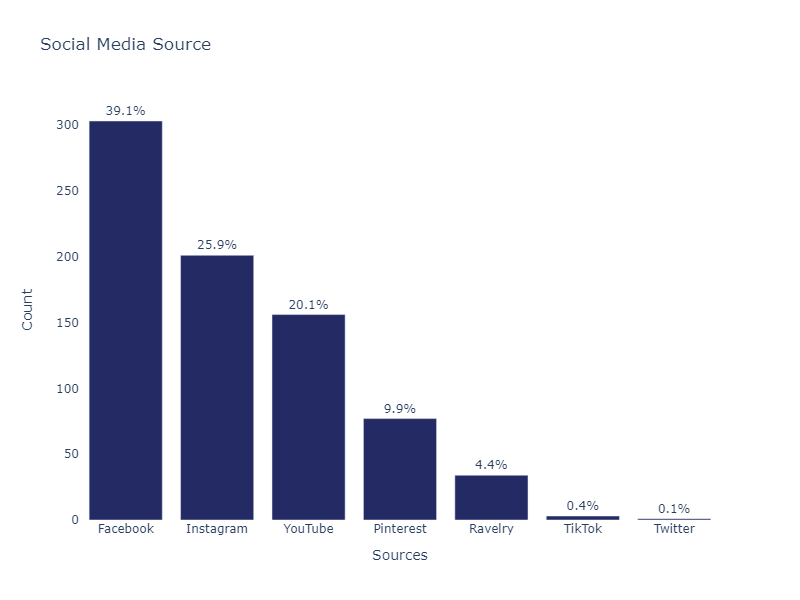

- Of the respondants, the most popular social media platform is: (From 775 responses.)
     - For the group 'Under 18', the most popular social media platform is **YouTube** at **66.7%**, followed by **Instagram** at **33.3%**.
     - For the group '18-24', the most popular social media platform is **YouTube** at **70.0%**, followed by **Instagram** at **20.0%**.
     - For the group '25-34', the most popular social media platform is **Instagram** at **58.0%**, followed by **YouTube** at **24.6%**.
     - For the group '35-44', the most popular social media platform is **Instagram** at **35.1%**, followed by **Facebook** at **30.5%**.
     - For the group '45-54', the most popular social media platform is **Facebook** at **40.1%**, followed by **Instagram** at **24.8%**.
     - For the group '55-64', the most popular social media platform is **Facebook** at **44.5%**, followed by **Instagram** at **20.9%**.
     - For the group '65-74', the most popular social media platform is **Facebook** at **55.3%**, followed by **Pinterest** at **17.4%**.
     - For the group '75 and older', the most popular social media platform is **Facebook** at **69.6%**, followed by **Pinterest** at **13.0%**.

In [88]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular social media platform is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

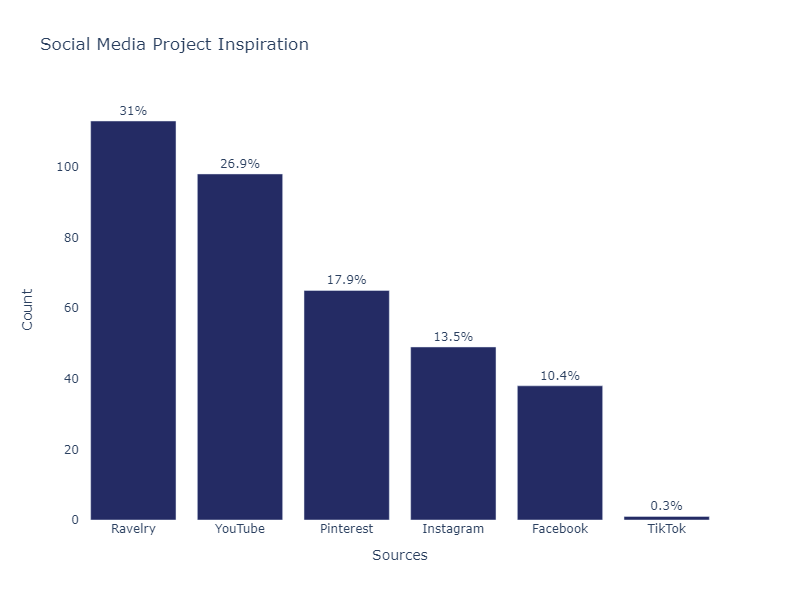

- Of the respondants, the most popular social media platform for inspiration is: (From 364 responses.)
     - For the group 'Under 18', the most popular social media platform for inspiration is **Ravelry** at **100.0%**.
     - For the group '18-24', the most popular social media platform for inspiration is **YouTube** at **33.3%**, followed by **Instagram** at **33.3%**.
     - For the group '25-34', the most popular social media platform for inspiration is **Ravelry** at **34.8%**, followed by **Instagram** at **26.1%**.
     - For the group '35-44', the most popular social media platform for inspiration is **Ravelry** at **37.7%**, followed by **Instagram** at **21.3%**.
     - For the group '45-54', the most popular social media platform for inspiration is **Ravelry** at **26.9%**, followed by **Instagram** at **23.1%**.
     - For the group '55-64', the most popular social media platform for inspiration is **YouTube** at **31.9%**, followed by **Ravelry** at **24.5%**.
     - For the group '65-74', the most popular social media platform for inspiration is **Ravelry** at **31.1%**, followed by **YouTube** at **29.7%**.
     - For the group '75 and older', the most popular social media platform for inspiration is **YouTube** at **39.1%**, followed by **Ravelry** at **39.1%**.

In [89]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondants, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform for inspiration is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', the most popular social media platform for inspiration is **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

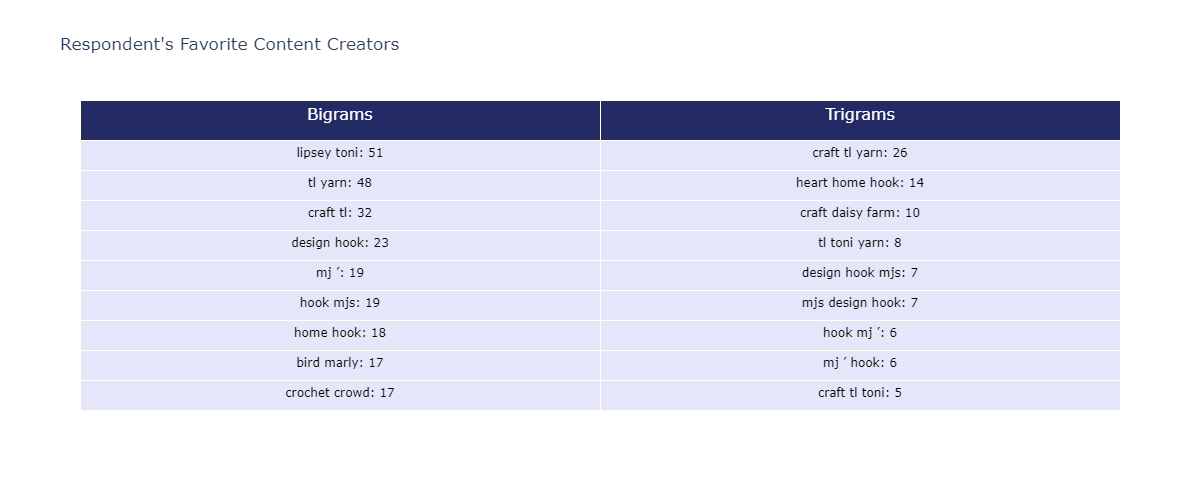

In [90]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[45]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'like',
    'dont know',
    'dont',
    'every',
    'day'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(9)

# Combine uni, bi, and tri grams
#uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Bigrams', 'Trigrams']
ngram_data = [ bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)


# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Respondent\'s Favorite Content Creators',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200
)

fig.update_traces(columnwidth=[15, 15, 15])

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

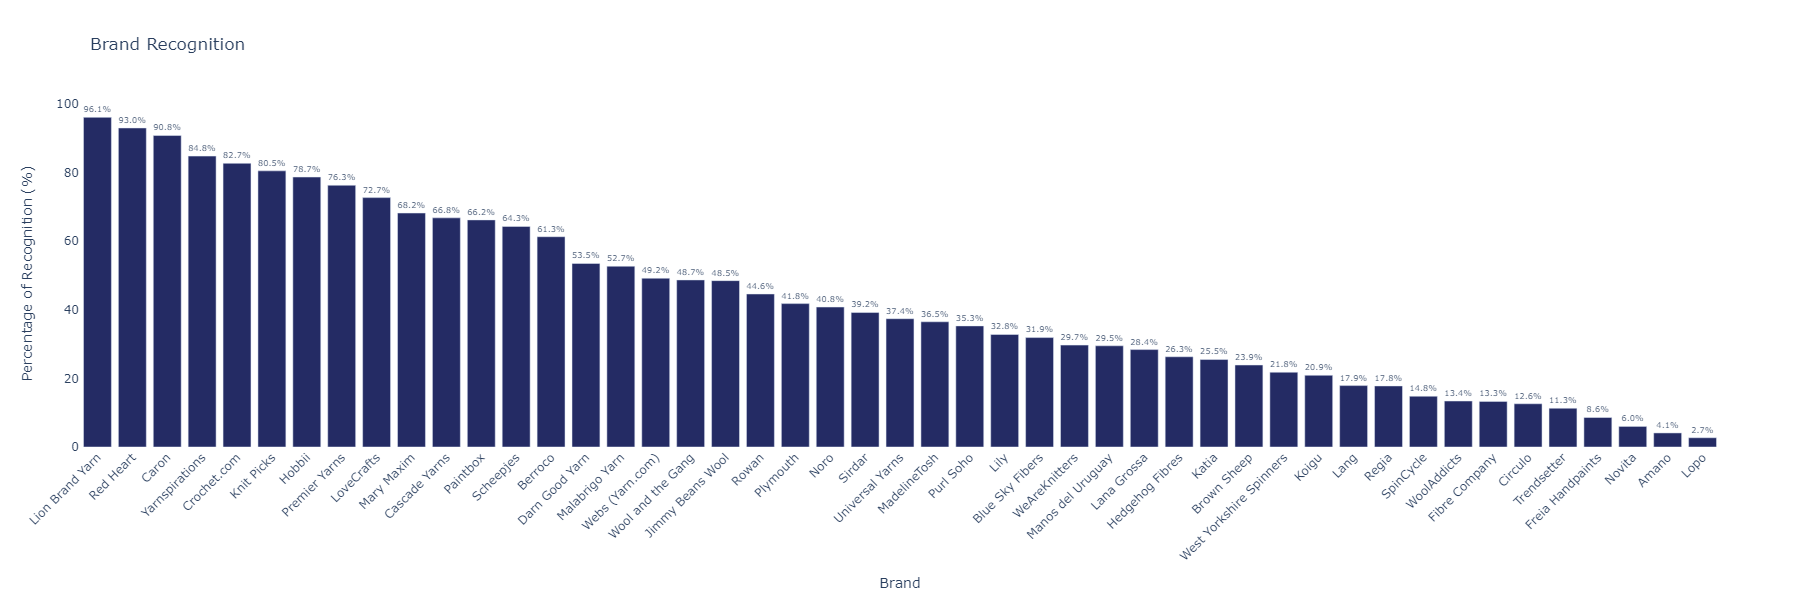

In [91]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

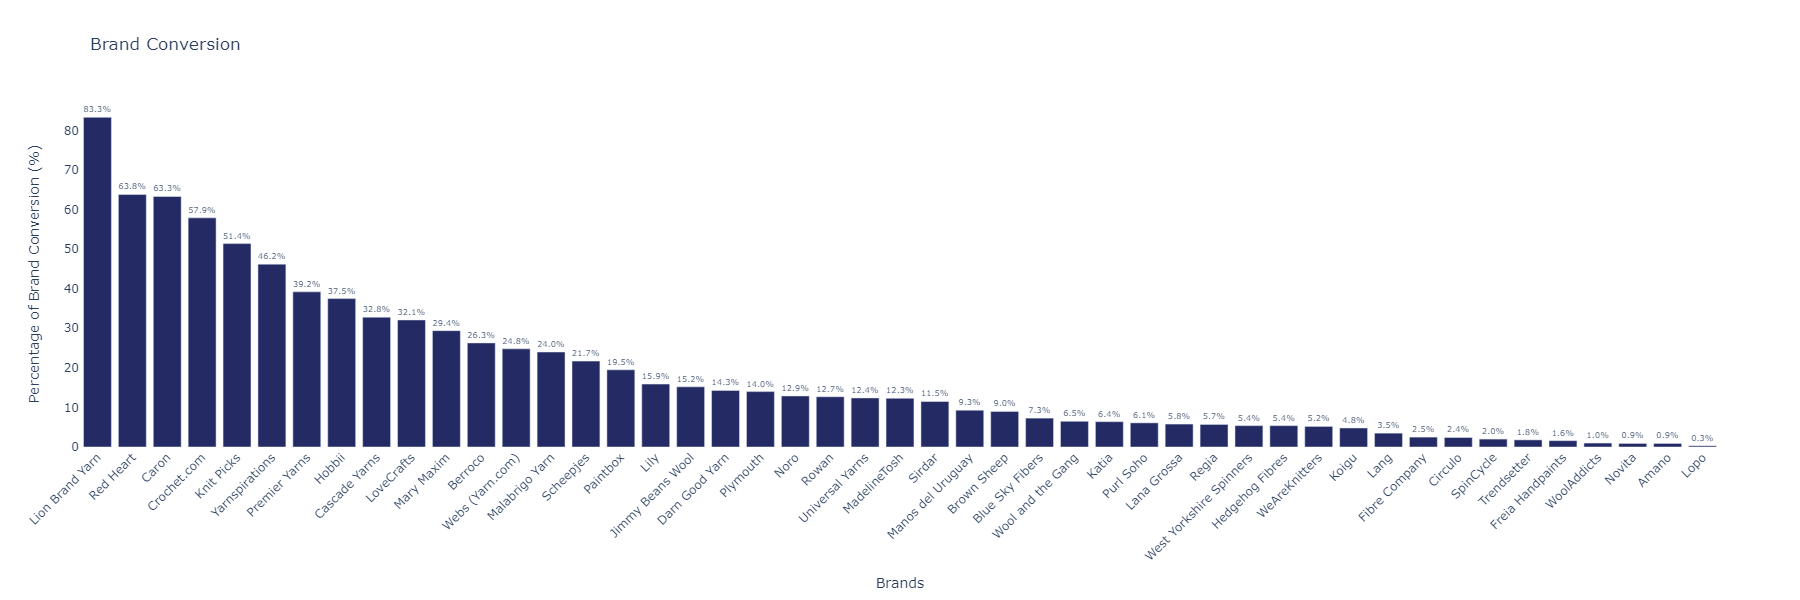

In [92]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

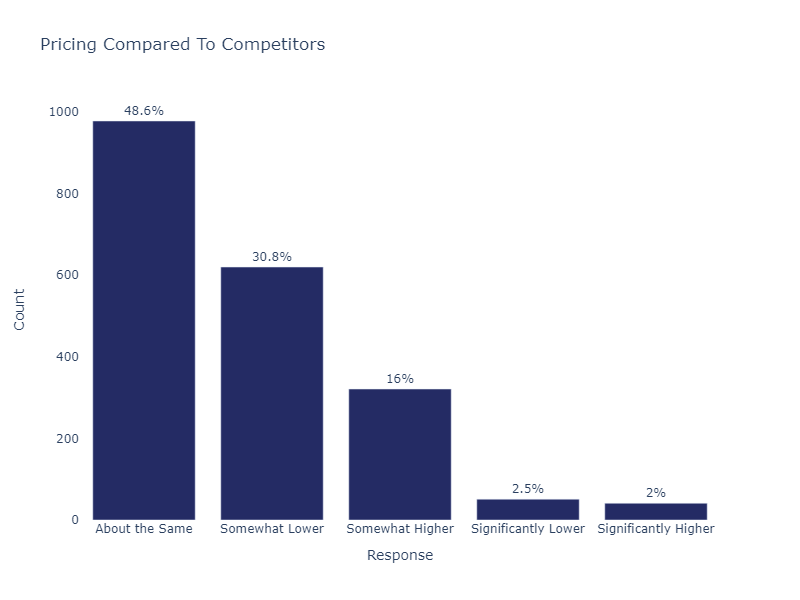

- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From 2011 responses)
    - "About the Same" (49%)
    - "Somewhat Lower" (31%)
    - "Somewhat Higher" (16%)
    - "Significantly Lower" (3%)
    - "Significantly Higher" (2%)


In [93]:
### Employment ###
question = all_responses.columns[31]

column_data = all_responses[all_responses.columns[31]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Pricing Compared To Competitors',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/survey_source.png")
display(Image(filename="./IMG/survey_source.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

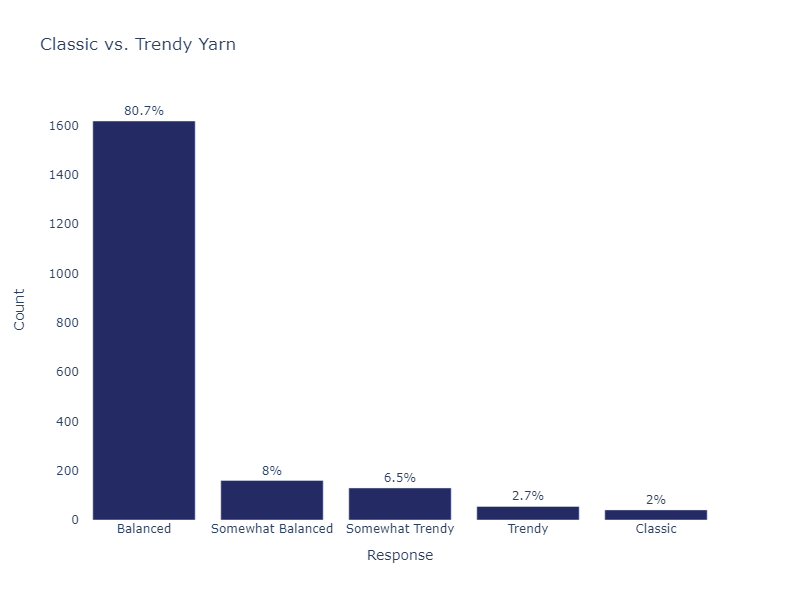

- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From 2004 responses)
    - "Balanced" (81%)
    - "Somewhat Balanced" (8%)
    - "Somewhat Trendy" (6%)
    - "Trendy" (3%)
    - "Classic" (2%)


In [94]:
### Employment ###
question = all_responses.columns[48]

column_data = all_responses[all_responses.columns[48]].dropna()
sample_size = column_data.shape[0]

# Define the function to map income ranges to their midpoints
def map_answer(value):
    if value == 1:
        return 'Classic'
    elif value == 2:
        return 'Somewhat Balanced'
    elif value == 3:
        return 'Balanced'
    elif value == 4:
        return 'Somewhat Trendy'
    elif value == 5:
        return 'Trendy'
    else:
        return np.nan

# Apply the function to the column data
column_data = column_data.map(map_answer)

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Classic vs. Trendy Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/trendy_classic_yarn.png")
display(Image(filename="./IMG/trendy_classic_yarn.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

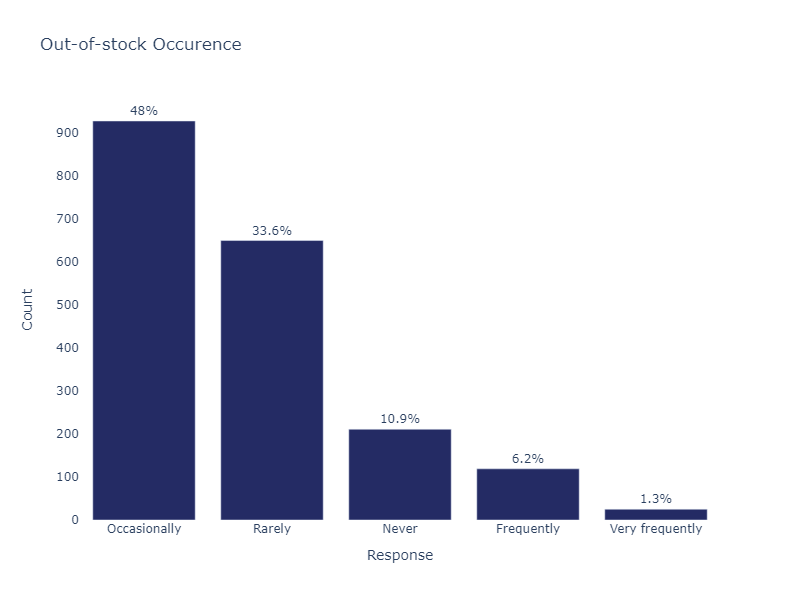

- Of the respondents, when asked about how often is something you want from our website out-of-stock?:  (From 1933 responses)
    - "Occasionally" (48%)
    - "Rarely" (34%)
    - "Never" (11%)
    - "Frequently" (6%)
    - "Very frequently" (1%)


In [95]:
question = all_responses.columns[49]

column_data = all_responses[all_responses.columns[49]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-of-stock Occurence',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/out_of_stock.png")
display(Image(filename="./IMG/out_of_stock.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about how often is something you want from our website out-of-stock?:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

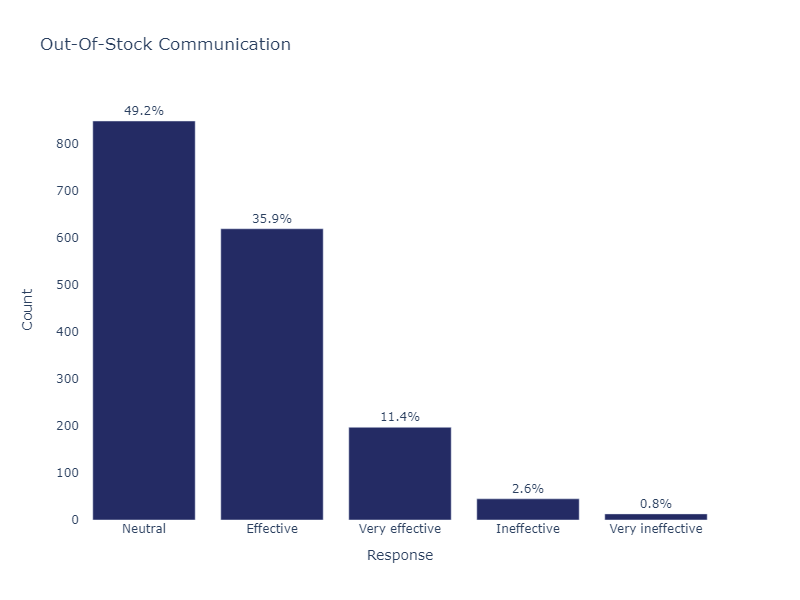

- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication when items are restocked?:  (From 1722 responses)
    - "Neutral" (49%)
    - "Effective" (36%)
    - "Very effective" (11%)
    - "Ineffective" (3%)
    - "Very ineffective" (1%)


In [96]:
question = all_responses.columns[50]

column_data = all_responses[all_responses.columns[50]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-Of-Stock Communication',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/out_of_stock_communication.png")
display(Image(filename="./IMG/out_of_stock_communication.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication when items are restocked?:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

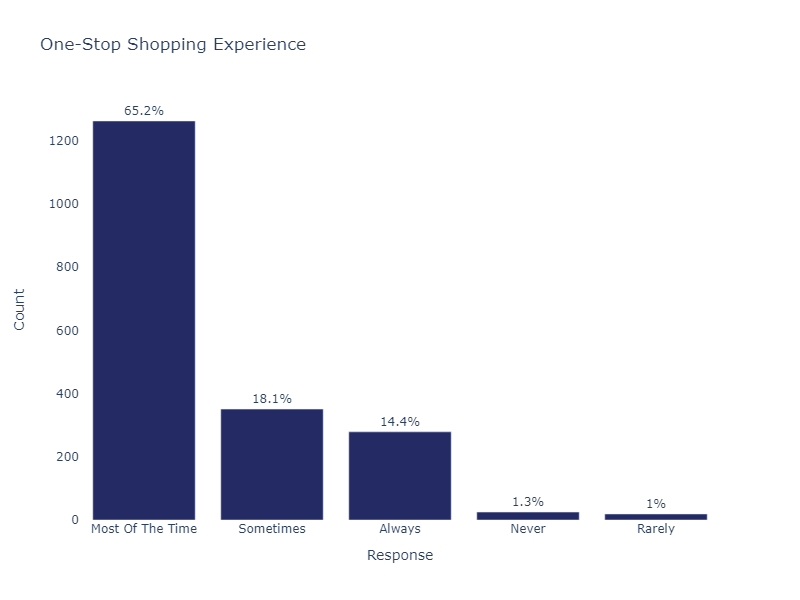

- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From 1937 responses)
    - "Most Of The Time" (65%)
    - "Sometimes" (18%)
    - "Always" (14%)
    - "Never" (1%)
    - "Rarely" (1%)


In [97]:
question = all_responses.columns[51]

column_data = all_responses[all_responses.columns[51]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='One-Stop Shopping Experience',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/one_stop_shop.png")
display(Image(filename="./IMG/one_stop_shop.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

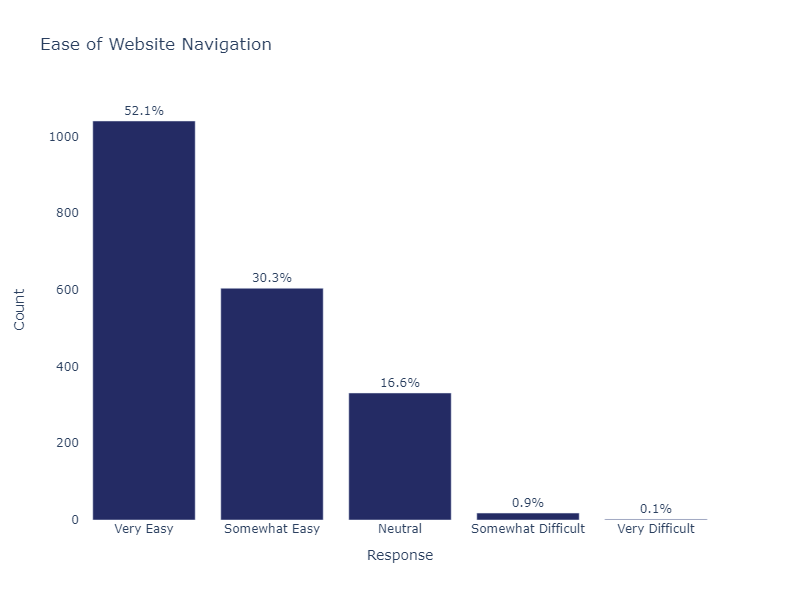

- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From 1995 responses)
    - "Very Easy" (52%)
    - "Somewhat Easy" (30%)
    - "Neutral" (17%)
    - "Somewhat Difficult" (1%)
    - "Very Difficult" (0%)


In [98]:
question = all_responses.columns[53]

column_data = all_responses[all_responses.columns[53]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Ease of Website Navigation',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/website_navigation.png")
display(Image(filename="./IMG/website_navigation.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

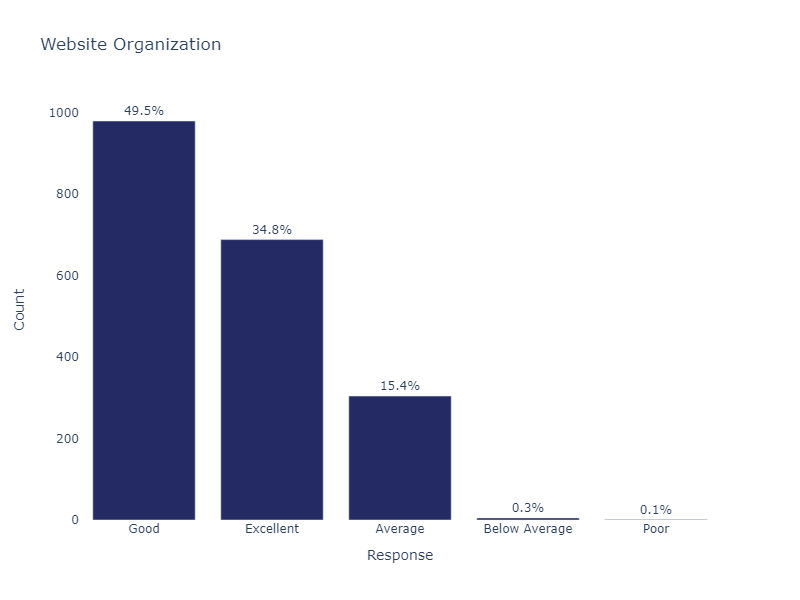

- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From 1977 responses)
    - "Good" (50%)
    - "Excellent" (35%)
    - "Average" (15%)
    - "Below Average" (0%)
    - "Poor" (0%)


In [99]:
question = all_responses.columns[55]

column_data = all_responses[all_responses.columns[55]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Website Organization',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/website_organization.png")
display(Image(filename="./IMG/website_organization.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

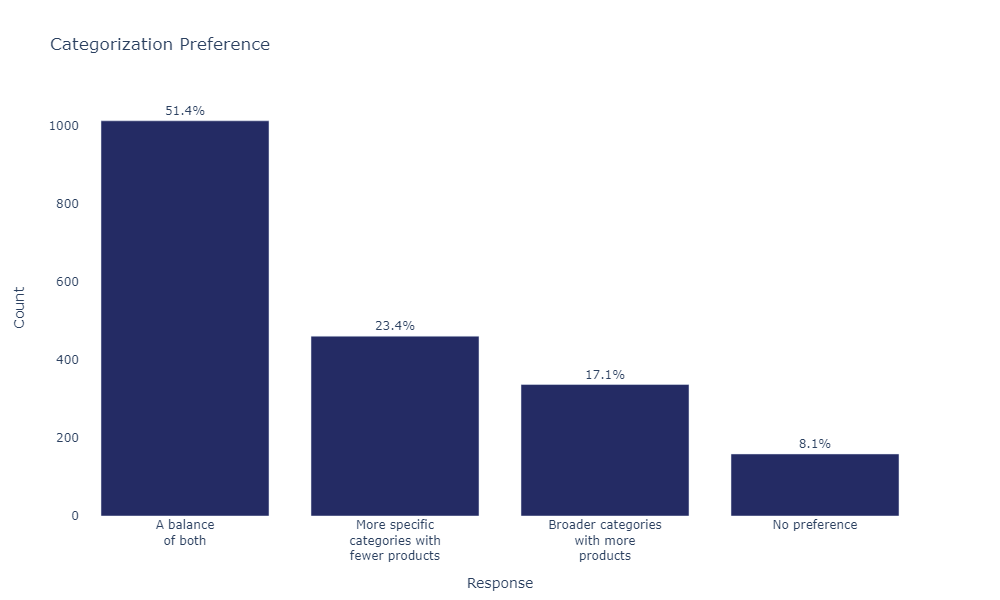

- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From 1970 responses)
    - "A balance of both" (51%)
    - "More specific categories with fewer products" (23%)
    - "Broader categories with more products" (17%)
    - "No preference" (8%)


In [100]:
question = all_responses.columns[56]

column_data = all_responses[all_responses.columns[56]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

def insert_line_breaks(text):
    words = text.split()
    # Insert '<br>' after every two words
    return '<br>'.join(' '.join(words[i:i+2]) for i in range(0, len(words), 2))

# Apply the function to each category to insert line breaks
summary_df['CategoryWrapped'] = summary_df['Category'].apply(insert_line_breaks)

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='CategoryWrapped', y='Count', title='Categorization Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout to improve readability
fig.update_layout(
    xaxis=dict(
        title='Response',
        tickmode='array',
        tickvals=summary_df['CategoryWrapped'],  # Use the wrapped category
        ticktext=summary_df['CategoryWrapped']   # Use the wrapped text for ticktext
    ),
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000,
    margin=dict(t=100)
)
# Show the figure
fig.write_image("./IMG/categorization_preference.png")
display(Image(filename="./IMG/categorization_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

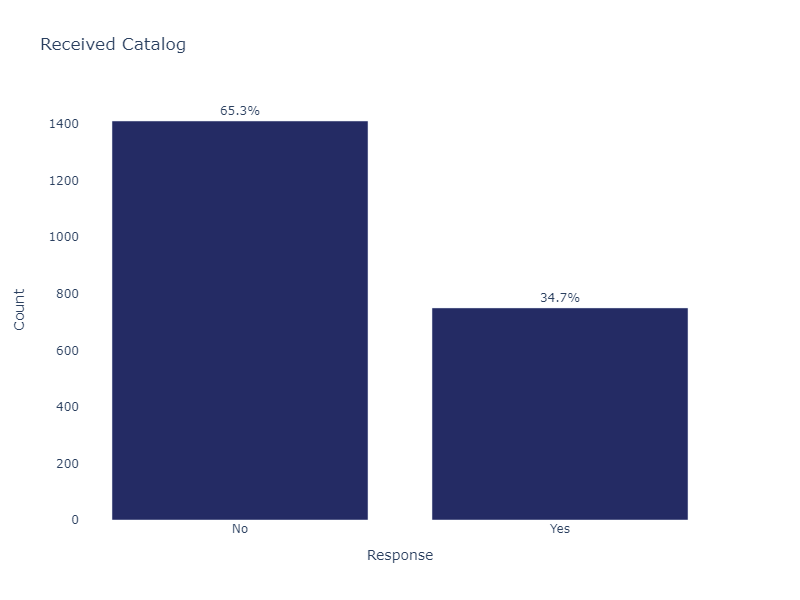

- Of the respondents, when asked if they have received one of our catalogs before:  (From 2161 responses)
    - "No" (65%)
    - "Yes" (35%)


In [101]:
question = all_responses.columns[57]

column_data = all_responses[all_responses.columns[57]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Received Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_received.png")
display(Image(filename="./IMG/catalog_received.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have received one of our catalogs before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

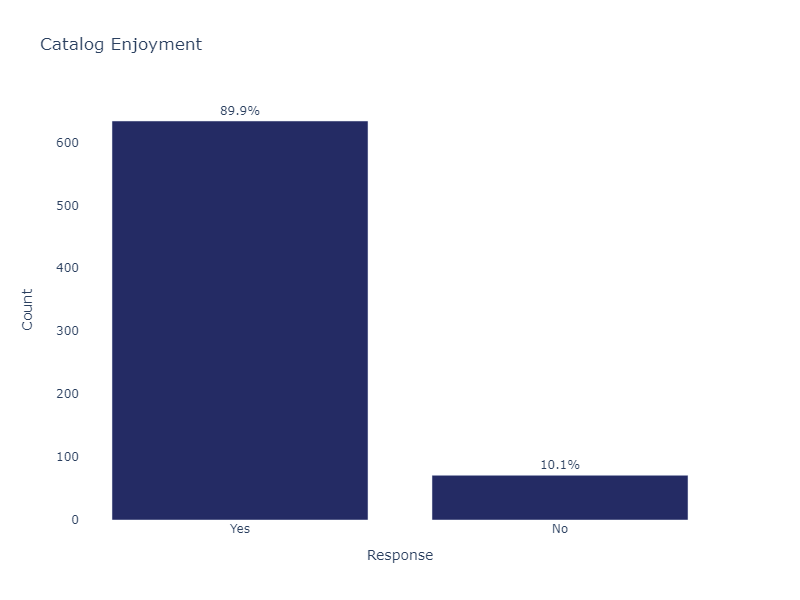

- Of the respondents, when asked if they enjoy receiving our catalog:  (From 705 responses)
    - "Yes" (90%)
    - "No" (10%)


- Of the respondents, when asked if they enjoy receiving our catalog: 
     - For the group 'Under 18', when asked if they enjoy receiving our catalog: **No** at **50.0%**, followed by **Yes** at **50.0%**.
     - For the group '18-24', when asked if they enjoy receiving our catalog: **Yes** at **91.7%**, followed by **No** at **8.3%**.
     - For the group '25-34', when asked if they enjoy receiving our catalog: **Yes** at **87.2%**, followed by **No** at **12.8%**.
     - For the group '35-44', when asked if they enjoy receiving our catalog: **Yes** at **88.5%**, followed by **No** at **11.5%**.
     - For the group '45-54', when asked if they enjoy receiving our catalog: **Yes** at **87.7%**, followed by **No** at **12.3%**.
     - For the group '55-64', when asked if they enjoy receiving our catalog: **Yes** at **93.7%**, followed by **No** at **6.3%**.
     - For the group '65-74', when asked if they enjoy receiving our catalog: **Yes** at **92.9%**, followed by **No** at **7.1%**.
     - For the group '75 and older', when asked if they enjoy receiving our catalog: **Yes** at **90.0%**, followed by **No** at **10.0%**.

In [102]:
column_data = all_responses[all_responses.columns[58]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enjoyment',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_enjoyment.png")
display(Image(filename="./IMG/catalog_enjoyment.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they enjoy receiving our catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[58], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they enjoy receiving our catalog: "

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        # Check if there are at least two platforms to report
        if len(percentages) > 1:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular platforms
            markdown_summary += f"\n     - For the group '{age}', when asked if they enjoy receiving our catalog: **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**, followed by **{percentages.iloc[1, 0]}** at **{percentages.iloc[1, 1]}%**."
        elif len(percentages) == 1:
            # If there's only one platform, mention only the most popular one
            markdown_summary += f"\n     - For the group '{age}', when asked if they enjoy receiving our catalog: **{percentages.iloc[0, 0]}** at **{percentages.iloc[0, 1]}%**."
        else:
            # If there are no platforms, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For the group '{age}', there were no platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

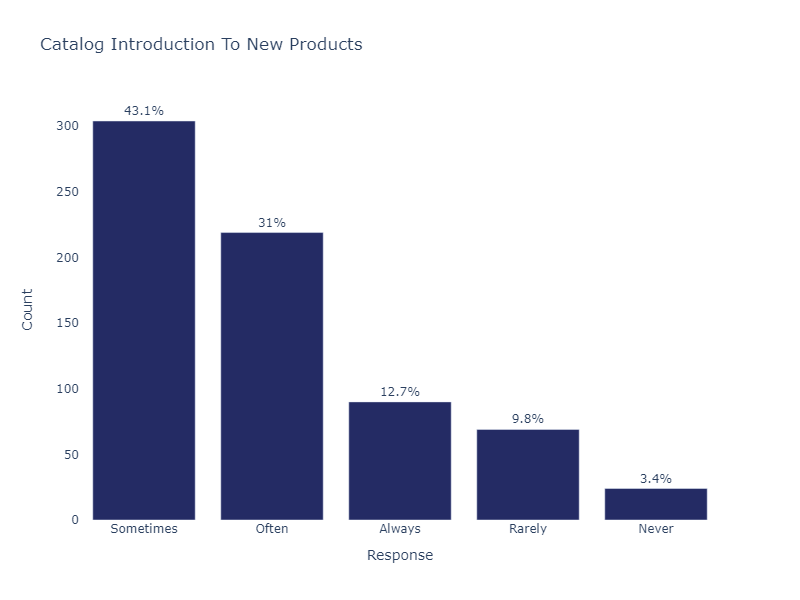

- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From 706 responses)
    - "Sometimes" (43%)
    - "Often" (31%)
    - "Always" (13%)
    - "Rarely" (10%)
    - "Never" (3%)


- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before: (From 706 responses.)
     - For the group 'Under 18', they responded as: **Rarely** at **50.0%**, and **Sometimes** at **50.0%**.
     - For the group '18-24', they responded as: **Sometimes** at **66.7%**, **Often** at **25.0%**, and **Rarely** at **8.3%**.
     - For the group '25-34', they responded as: **Sometimes** at **33.3%**, **Often** at **26.9%**, and **Always** at **16.7%**.
     - For the group '35-44', they responded as: **Sometimes** at **47.7%**, **Often** at **27.7%**, and **Rarely** at **13.8%**.
     - For the group '45-54', they responded as: **Sometimes** at **40.4%**, **Often** at **35.6%**, and **Always** at **10.3%**.
     - For the group '55-64', they responded as: **Sometimes** at **39.8%**, **Often** at **34.2%**, and **Always** at **16.1%**.
     - For the group '65-74', they responded as: **Sometimes** at **50.0%**, **Often** at **27.7%**, and **Always** at **12.5%**.
     - For the group '75 and older', they responded as: **Often** at **40.0%**, **Sometimes** at **40.0%**, and **Always** at **15.0%**.

In [103]:
column_data = all_responses[all_responses.columns[59]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Introduction To New Products',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_new_products.png")
display(Image(filename="./IMG/catalog_new_products.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[59], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

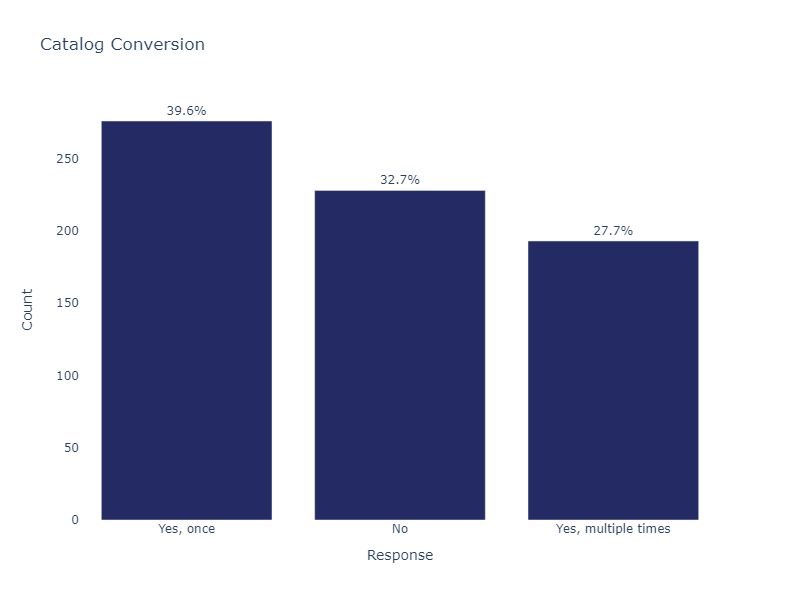

- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From 697 responses)
    - "Yes, once" (40%)
    - "No" (33%)
    - "Yes, multiple times" (28%)


- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From 697 responses.)
     - For the group 'Under 18', they responded as: **No** at **50.0%**, and **Yes, once** at **50.0%**.
     - For the group '18-24', they responded as: **No** at **66.7%**, and **Yes, once** at **33.3%**.
     - For the group '25-34', they responded as: **No** at **44.9%**, **Yes, once** at **43.6%**, and **Yes, multiple times** at **11.5%**.
     - For the group '35-44', they responded as: **No** at **40.3%**, **Yes, once** at **38.0%**, and **Yes, multiple times** at **21.7%**.
     - For the group '45-54', they responded as: **Yes, once** at **40.7%**, **No** at **33.8%**, and **Yes, multiple times** at **25.5%**.
     - For the group '55-64', they responded as: **Yes, once** at **42.9%**, **Yes, multiple times** at **35.3%**, and **No** at **21.8%**.
     - For the group '65-74', they responded as: **Yes, once** at **36.9%**, **Yes, multiple times** at **36.9%**, and **No** at **26.1%**.
     - For the group '75 and older', they responded as: **Yes, multiple times** at **57.9%**, **No** at **21.1%**, and **Yes, once** at **21.1%**.

In [104]:
column_data = all_responses[all_responses.columns[60]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Conversion',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_purchase.png")
display(Image(filename="./IMG/catalog_purchase.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[60], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

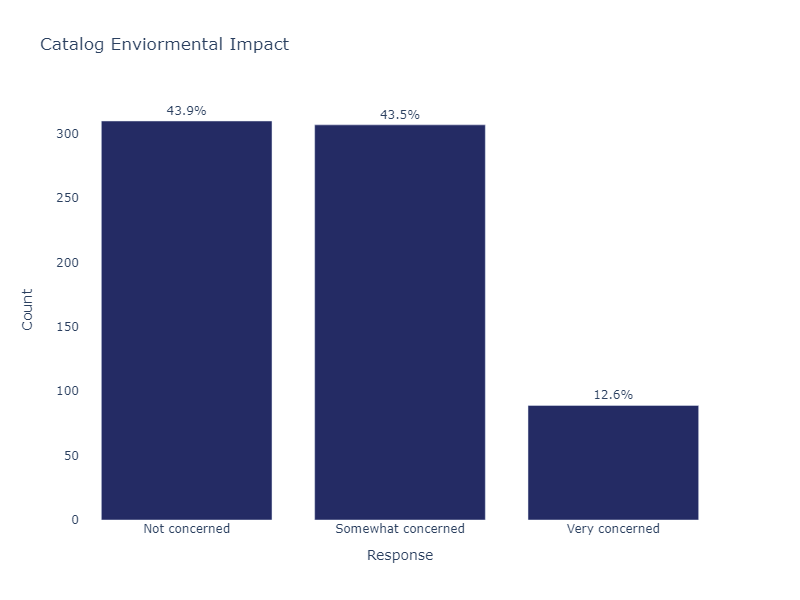

- Of the respondents, when asked if they were concerned about the enviormental impact of catalogs:  (From 706 responses)
    - "Not concerned" (44%)
    - "Somewhat concerned" (43%)
    - "Very concerned" (13%)


- Of the respondents, when asked if they were concerned about the enviormental impact of catalogs: (From 706 responses.)
     - For the group 'Under 18', they responded as: **Somewhat concerned** at **100.0%**
     - For the group '18-24', they responded as: **Somewhat concerned** at **75.0%**, and **Not concerned** at **25.0%**.
     - For the group '25-34', they responded as: **Not concerned** at **44.9%**, **Somewhat concerned** at **35.9%**, and **Very concerned** at **19.2%**.
     - For the group '35-44', they responded as: **Somewhat concerned** at **47.3%**, **Not concerned** at **37.2%**, and **Very concerned** at **15.5%**.
     - For the group '45-54', they responded as: **Somewhat concerned** at **45.9%**, **Not concerned** at **43.8%**, and **Very concerned** at **10.3%**.
     - For the group '55-64', they responded as: **Not concerned** at **49.1%**, **Somewhat concerned** at **44.7%**, and **Very concerned** at **6.2%**.
     - For the group '65-74', they responded as: **Not concerned** at **44.6%**, **Somewhat concerned** at **39.3%**, and **Very concerned** at **16.1%**.
     - For the group '75 and older', they responded as: **Somewhat concerned** at **45.0%**, **Not concerned** at **40.0%**, and **Very concerned** at **15.0%**.

In [105]:
column_data = all_responses[all_responses.columns[61]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enviormental Impact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_enviornmental_impact.png")
display(Image(filename="./IMG/catalog_enviornmental_impact.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they were concerned about the enviormental impact of catalogs:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[61], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they were concerned about the enviormental impact of catalogs: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

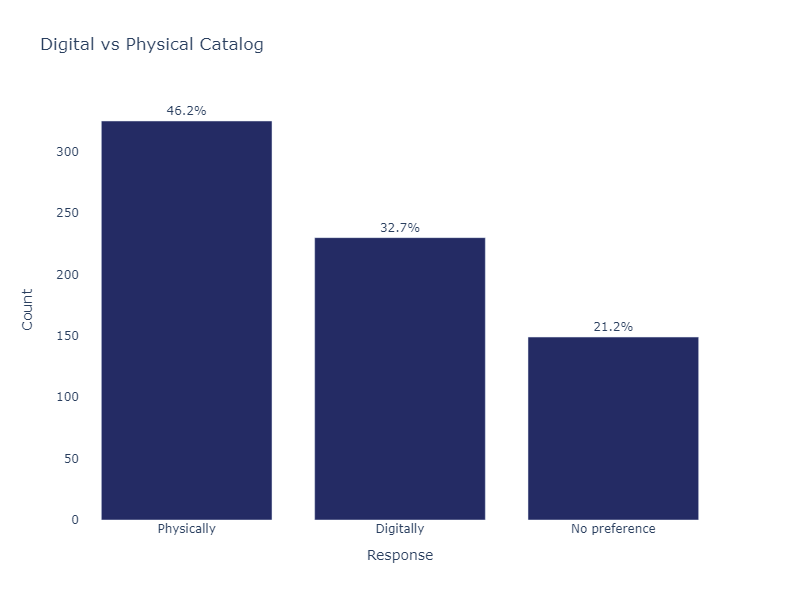

- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From 704 responses)
    - "Physically" (46%)
    - "Digitally" (33%)
    - "No preference" (21%)


- Of the respondents, when asked if they would prefer a physical or digital catalog: (From 704 responses.)
     - For the group 'Under 18', they responded as: **Digitally** at **100.0%**
     - For the group '18-24', they responded as: **Digitally** at **41.7%**, **No preference** at **33.3%**, and **Physically** at **25.0%**.
     - For the group '25-34', they responded as: **Physically** at **43.6%**, **Digitally** at **39.7%**, and **No preference** at **16.7%**.
     - For the group '35-44', they responded as: **Physically** at **43.8%**, **Digitally** at **33.8%**, and **No preference** at **22.3%**.
     - For the group '45-54', they responded as: **Physically** at **44.9%**, **Digitally** at **34.0%**, and **No preference** at **21.1%**.
     - For the group '55-64', they responded as: **Physically** at **50.3%**, **Digitally** at **26.4%**, and **No preference** at **23.3%**.
     - For the group '65-74', they responded as: **Physically** at **47.8%**, **Digitally** at **31.0%**, and **No preference** at **21.2%**.
     - For the group '75 and older', they responded as: **Physically** at **55.0%**, **Digitally** at **30.0%**, and **No preference** at **15.0%**.

In [106]:
column_data = all_responses[all_responses.columns[62]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Digital vs Physical Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/catalog_type_preference.png")
display(Image(filename="./IMG/catalog_type_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[62], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they would prefer a physical or digital catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For the group '{age}',"
        if platform_count > 0:
            markdown_summary += " they responded as:"
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** at **{percentages.iloc[i, 1]}%**"
        else:
            markdown_summary += " there were no platforms with significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

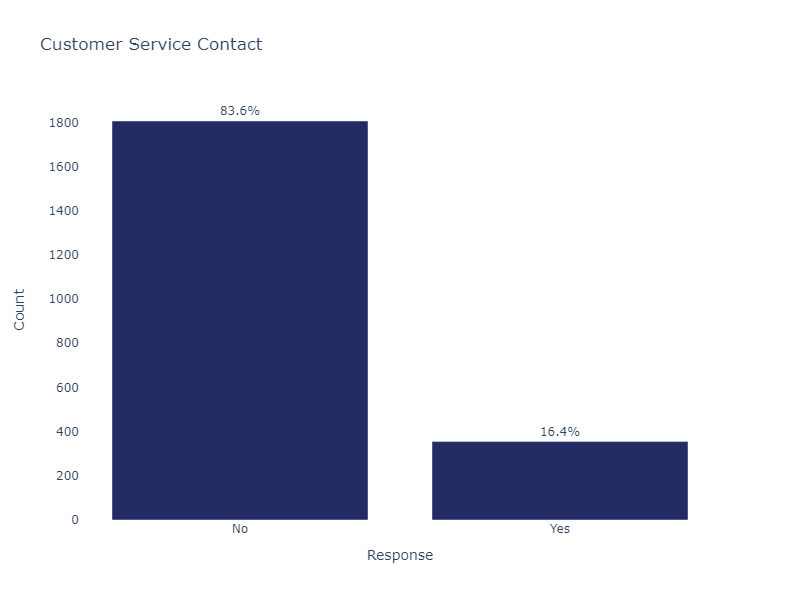

- Of the respondents, when asked if they have contacted customer service before:  (From 2161 responses)
    - "No" (84%)
    - "Yes" (16%)


In [107]:
column_data = all_responses[all_responses.columns[64]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Contact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service.png")
display(Image(filename="./IMG/customer_service.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have contacted customer service before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

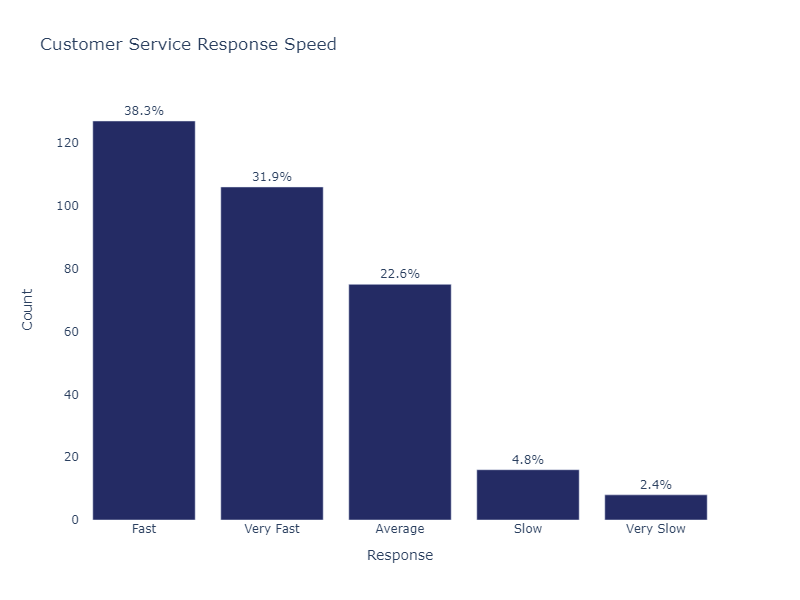

- Of the respondents, when asked about the response speed of our customer service:  (From 332 responses)
    - "Fast" (38%)
    - "Very Fast" (32%)
    - "Average" (23%)
    - "Slow" (5%)
    - "Very Slow" (2%)


In [108]:
column_data = all_responses[all_responses.columns[65]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Response Speed',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_speed.png")
display(Image(filename="./IMG/customer_service_speed.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the response speed of our customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

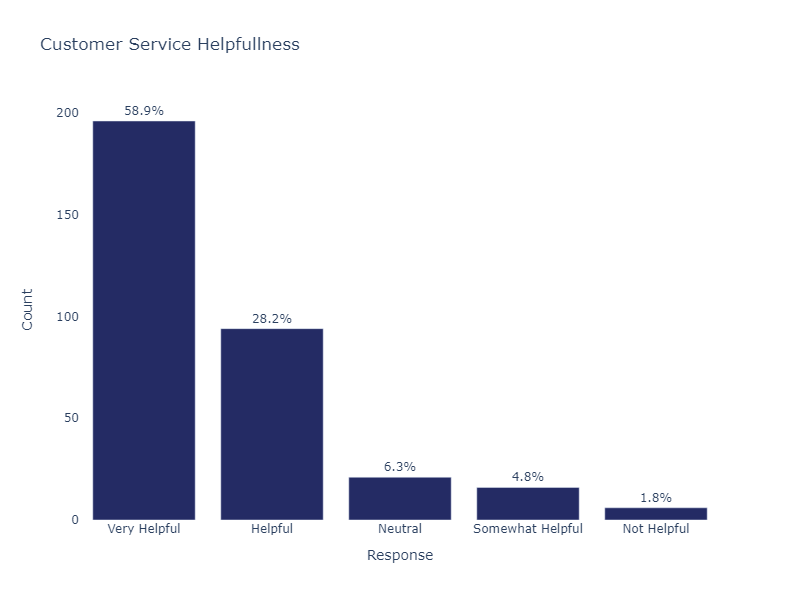

- Of the respondents, when asked how helpful our customer service is:  (From 333 responses)
    - "Very Helpful" (59%)
    - "Helpful" (28%)
    - "Neutral" (6%)
    - "Somewhat Helpful" (5%)
    - "Not Helpful" (2%)


In [109]:
column_data = all_responses[all_responses.columns[66]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Helpfullness',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how helpful our customer service is:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

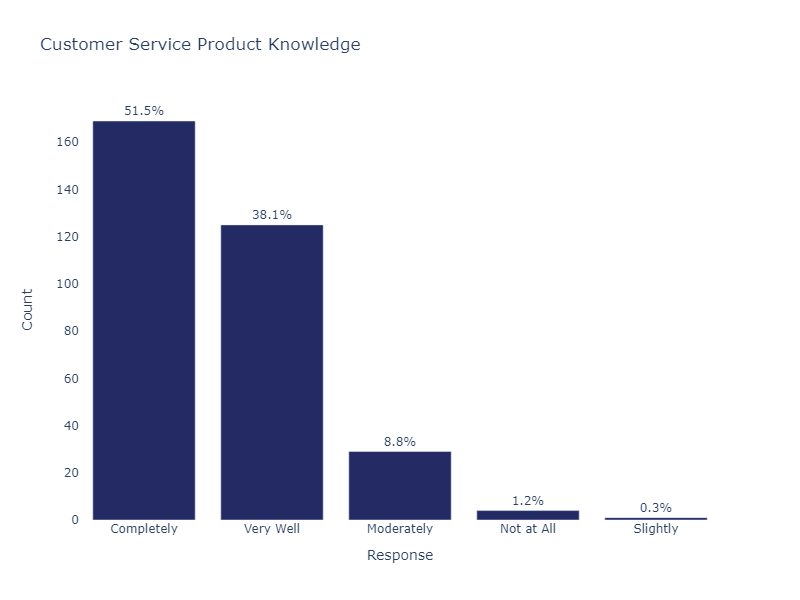

- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From 328 responses)
    - "Completely" (52%)
    - "Very Well" (38%)
    - "Moderately" (9%)
    - "Not at All" (1%)
    - "Slightly" (0%)


In [110]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Product Knowledge',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

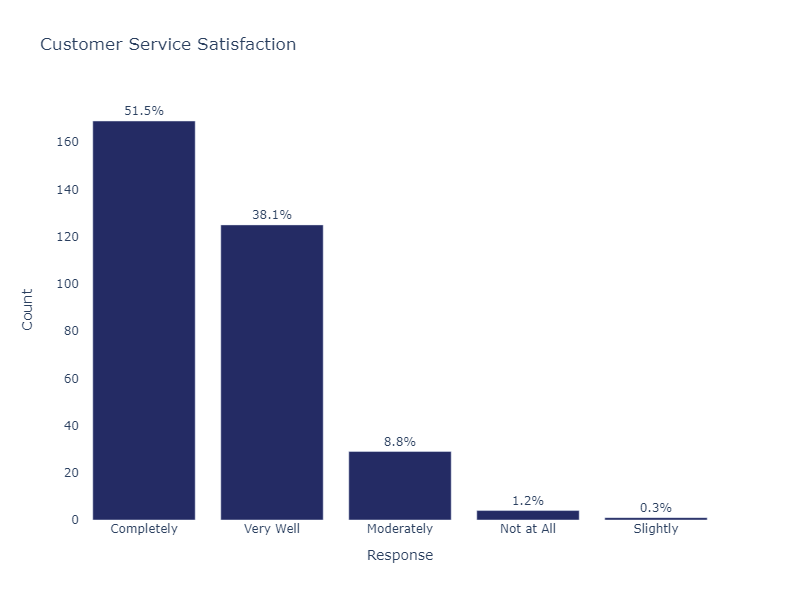

- Of the respondents, when asked how satisfied they were with out customer service:  (From 328 responses)
    - "Completely" (52%)
    - "Very Well" (38%)
    - "Moderately" (9%)
    - "Not at All" (1%)
    - "Slightly" (0%)


In [111]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Satisfaction',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/customer_service_satisfaction.png")
display(Image(filename="./IMG/customer_service_satisfaction.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how satisfied they were with out customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))